All models to predict local values of total strain 


In [1]:
Data_sims_file = "C:\\Users\\Mehdi-GHRABLI\\Desktop\\New_Launch\\New_launch_files\\user_files" #Data_sims_file is the folder containing the simulation results

In [2]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import pandas as pd #Used to create dataframe
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import scipy.interpolate

import time
from datetime import timedelta
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.colors as mcolors
import os #Used to get Data path
from sklearn.svm import SVR 
from sklearn.tree import  DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RF ,GradientBoostingRegressor as GBR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
import sklearn.model_selection as skm
import statsmodels.api as sm
from ISLP.models import ModelSpec as MS
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Sequential
from keras.layers import Dense
import keras
np.random.seed(1)


In [3]:
# Defining metrics : 
def metric_MSE(ground_truth,predictions):
    return mean_squared_error(ground_truth,predictions)
def metric_MAE(ground_truth,predictions):
    return mean_absolute_error(ground_truth,predictions)
def metric_R2(ground_truth,predictions):
    return r2_score(ground_truth,predictions)
def metric_adjusted_R2(ground_truth,predictions,n_obs,n_indep_variables):
    return 1-(1-r2_score(ground_truth,predictions))*(n_obs-1)/(n_obs-n_indep_variables-1)
# def metric_MAPE(ground_truth,predictions):
#     return np.mean(np.abs((ground_truth - predictions) / ground_truth))*100

def metric_MAPE(ground_truth, predictions, eps=1e-8):
    ground_truth, predictions = np.array(ground_truth).ravel(), np.array(predictions).ravel()
    return np.mean(np.abs((ground_truth - predictions) / np.maximum(np.abs(ground_truth), eps))) * 100

def metric_MSPE(ground_truth, predictions, eps=1e-8):
    ground_truth, predictions = np.array(ground_truth).ravel(), np.array(predictions).ravel()
    return np.mean(np.square((ground_truth - predictions) / np.maximum(np.abs(ground_truth), eps))) * 100

def adaptive_MAPE(y_true, y_pred, min_eps=1e-8):
    y_true = np.ravel(np.array(y_true, dtype=np.float64))
    y_pred = np.ravel(np.array(y_pred, dtype=np.float64))    
    scale_eps = max(min_eps, np.mean(np.abs(y_true)) * 1e-6)
    perc_error = np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), scale_eps)
    return np.mean(perc_error) * 100

def adaptive_MSPE(y_true, y_pred, min_eps=1e-8):
    y_true = np.ravel(np.array(y_true, dtype=np.float64))
    y_pred = np.ravel(np.array(y_pred, dtype=np.float64))
    
    scale_eps = max(min_eps, np.mean(np.abs(y_true)) * 1e-6)
    perc_error_sq = np.square((y_true - y_pred) / np.maximum(np.abs(y_true), scale_eps))
    return np.mean(perc_error_sq) * 100

In [4]:
def plot_residuals(X_test,y_hat,y_test,local_contact_data,Input_names,Output_names):
    def plot_residuals_per_variable(X_test,Variable_name,e):
        plt.scatter(np.array(X_test)[:,e].reshape(-1)*float(local_contact_data[Variable_name].max()-local_contact_data[Variable_name].min())+float(local_contact_data[Variable_name].min()),residuals*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
        plt.axhline(0, c='k', ls='--')
        plt.xlabel(Variable_name)
        plt.grid()
        plt.ylabel("Residuals")
        plt.show()
        return
    residuals = y_hat-y_test.reshape(-1)
    plt.scatter(y_test.reshape(-1)*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),residuals*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
    plt.axhline(0, c='k', ls='--')
    plt.xlabel("Total strain")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

    plt.scatter(y_test.reshape(-1)*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),y_hat*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]))
    plt.plot(y_test*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),y_test*float(local_contact_data[Output_names].max().iloc[0]-local_contact_data[Output_names].min().iloc[0])+float(local_contact_data[Output_names].min().iloc[0]),color='red')
    plt.xlabel("Total strain")
    plt.ylabel("predicted strain")
    plt.grid()
    plt.show()
    for e,input_name in enumerate(Input_names):
        plot_residuals_per_variable(X_test,input_name,e)

    
    return

In [5]:
def plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0): 
    def return_predictions_for_plotting(X_plot,model_name,predictor,des_lin,Input_names):
        # design_lin = MS(Input_names)
        if model_name == "Linear":
            X_plot = des_lin.transform(pd.DataFrame(X_plot,columns=Input_names))
            Y_plot = predictor.get_prediction(X_plot).predicted_mean
        elif model_name == "LASSO":
            X_plot = des_lin.transform(pd.DataFrame(X_plot,columns=Input_names))
            Y_plot = predictor.predict(X_plot)
        elif model_name == "Ridge":
            X_plot = des_lin.transform(pd.DataFrame(X_plot,columns=Input_names))
            Y_plot = predictor.predict(X_plot)
        elif model_name == "ElasticNet":
            X_plot = des_lin.transform(pd.DataFrame(X_plot,columns=Input_names))
            Y_plot = predictor.predict(X_plot)
        elif model_name == "Polynomial":
            X_plot = des_lin.fit_transform(pd.DataFrame(X_plot,columns=Input_names))
            # X_plot = des_lin.transform(pd.DataFrame(X_plot,columns=Input_names))
            Y_plot = predictor.get_prediction(X_plot).predicted_mean
        elif model_name == "DecisionTree":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "RandomForest":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "Boosting":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "Bagging":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "SVR":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "KNN":
            Y_plot = predictor.predict(X_plot)
        elif model_name == "Neural Network":
            Y_plot = predictor.predict(X_plot)
        return X_plot, Y_plot

    # design_lin = MS(Input_names)
    Test_contact_data = Test_data_to_plot[index_data]
    Total_strain_values = Test_contact_data["ETS_C1"]
    X_values = Test_contact_data["X (mm)"]
    Y_values = Test_contact_data["Y (mm)"]
    X_values_sq = Test_contact_data["X2 (mm)"]
    Y_values_sq = Test_contact_data["Y2 (mm)"]

    X_plot =np.zeros((len(X_values),12))
    X_plot[:,0]= (Test_contact_data["Temperature (°C)"]-local_contact_data["Temperature (°C)"].min())/(local_contact_data["Temperature (°C)"].max()-local_contact_data["Temperature (°C)"].min())
    X_plot[:,1]= (Test_contact_data["Contact major radius (mm)"]-local_contact_data["Contact major radius (mm)"].min())/(local_contact_data["Contact major radius (mm)"].max()-local_contact_data["Contact major radius (mm)"].min())
    X_plot[:,2]= (X_values-local_contact_data["X (mm)"].min())/(local_contact_data["X (mm)"].max()-local_contact_data["X (mm)"].min())
    X_plot[:,3]= (Y_values-local_contact_data["Y (mm)"].min())/(local_contact_data["Y (mm)"].max()-local_contact_data["Y (mm)"].min())

    X_plot[:,4]= (X_values_sq-local_contact_data["X2 (mm)"].min())/(local_contact_data["X2 (mm)"].max()-local_contact_data["X2 (mm)"].min())
    X_plot[:,5]= (Y_values_sq-local_contact_data["Y2 (mm)"].min())/(local_contact_data["Y2 (mm)"].max()-local_contact_data["Y2 (mm)"].min())

    
    X_plot, Y_plot = return_predictions_for_plotting(X_plot,model_name,predictor,des_lin,Input_names)

    ETS_renorm = (local_contact_data["ETS_C1"].max()-local_contact_data["ETS_C1"].min())*(Y_plot+local_contact_data["ETS_C1"].min())


    vmin = min(ETS_renorm.min(), Total_strain_values.min())
    vmax = max(ETS_renorm.max(), Total_strain_values.max())
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.cm.viridis  # Choose any colormap
    epsilon = 1. + 1e-9  # Add a little to include the endpoint in np.arange

    



    z_interpolator = scipy.interpolate.CloughTocher2DInterpolator(np.array([X_values,Y_values]).T, 
                                                                np.array(ETS_renorm))
    d_xy = np.sqrt((X_values.max() - X_values.min()) * 
                (Y_values.max() - Y_values.min()) / len(X_values))
    
    x_uniform = np.arange(X_values.min(), X_values.max()*epsilon, d_xy)
    y_uniform = np.arange(Y_values.min(), Y_values.max()*epsilon, d_xy)
    X_coords, Y_coords = np.meshgrid(x_uniform, y_uniform)


    z_interpolator_ground_truth = scipy.interpolate.CloughTocher2DInterpolator(np.array([X_values,Y_values]).T, 
                                                                np.array(Total_strain_values))
    d_xy_ground_truth = np.sqrt((X_values.max() - X_values.min()) * 
                (Y_values.max() - Y_values.min()) / len(X_values))

    fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[12,6])





    z_interpolator_error = scipy.interpolate.CloughTocher2DInterpolator(np.array([X_values,Y_values]).T, 
                                                                np.array(Total_strain_values)-np.array(ETS_renorm))

    cbe = ax[2].tricontourf(X_values, Y_values, np.abs(np.array(Total_strain_values)-np.array(ETS_renorm.ravel())),cmap=cmap,norm=norm)


    # plt.colorbar(cb, ax=ax, label='Total strain prediction absolute error')

    # ax.scatter(X_values,Y_values, color='black', alpha=.5, s=3)
        
    # ax.set_title('Absolute error of total strain prediction in contact area')

    # plt.show()


    # # Subplot 1: Scatter plot with tricontourf, which takes randomly positioned points
    cb0 = ax[0].tricontourf(X_values, Y_values, np.array(ETS_renorm.ravel()),cmap=cmap,norm=norm)
    # plt.colorbar(cb, ax=ax[0], label='Predicted total strain')

    # # Subplot 2: Contour plot, which takes only points positioned on a grid
    cb = ax[1].tricontourf(X_values, Y_values,  np.array(Total_strain_values),cmap=cmap,norm=norm)

    # Scatter the original data points on both subplots
    for ax_i in ax:
        ax_i.set_xlabel('x')
        ax_i.set_ylabel('y')
        ax_i.scatter(X_values, Y_values, color='black', alpha=.5, s=3)

    X_coords, Y_coords = np.meshgrid(x_uniform, y_uniform)
    Z = z_interpolator(np.dstack((X_coords, Y_coords)))

    # cbar = fig.colorbar(cb0, ax=ax, orientation="vertical", fraction=0.02, pad=0.04,norm=norm)
    # cbar.set_label("Value")

    ax[0].set_title('Predicted total strain \n in contact area')
    ax[1].set_title('Simulated total strain \n in contact area')
    ax[2].set_title('Absolute error')

    sm_plot = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm_plot.set_array([])  # Dummy array for colorbar

    # Shared colorbar
    cbar = fig.colorbar(sm_plot, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    if np.max(Test_contact_data["EPS_C1"])>Epsilon_plasticity:
        added_st = "(Plastic regime)"
    else : 
        added_st = "(Elastic regime)"
    cbar.set_label("Total strain "+added_st)

    plt.show()

In [6]:
n_exp = 1000#Number of experiments to use 
Eps_plas =1e-10#Small non-zero number indicating the presence of plasticity 

Importing Data

In [7]:

Design_point_folders = [ f.path for f in os.scandir(Data_sims_file) if f.is_dir() ]


In [8]:
Names_list = []
Current_list = []
Rh_list = []
Rw_list = []
Alpha_list = []
Temperature_list = []


Suff_contact= [" Contact Time 1.txt"," Contact Time 2.txt"]
Suff_metal= [" Metal Time 1.txt"," Metal Time 2.txt"]

Initial_local_names = [
    "Directional Deformation X",
    "Directional Deformation Y",
    "Directional Deformation Z",
    "Elastic Strain Intensity",
    "Equivalent Elastic Strain",
    "Equivalent Plastic Strain",
    "Equivalent Stress",
    "Equivalent Total Strain",
    "Maximum Principal Elastic Strain",
    "Maximum Principal Stress",
    "Maximum Shear Elastic Strain",
    "Maximum Shear Stress",
    "Middle Principal Elastic Strain",
    "Middle Principal Stress",
    "Minimum Principal Elastic Strain",
    "Minimum Principal Stress",
    "Normal Elastic Strain X",
    "Normal Elastic Strain Y",
    "Normal Elastic Strain Z",
    "Normal Stress X",
    "Normal Stress Y",
    "Normal Stress Z",
    "Shear Elastic Strain XY",
    "Shear Elastic Strain XZ",
    "Shear Elastic Strain YZ",
    "Shear Stress XY",
    "Shear Stress XZ",
    "Shear Stress YZ",
    "Stress Intensity",
    "Thermal Strain X",
    "Thermal Strain Y",
    "Thermal Strain Z",
    "Total Deformation"
]

Suff_ab_contact = ["_C1","_C2"]
Suff_ab_metal = ["_M1","_M2"]
Initial_local_names_ab = ["DDX","DDY","DDZ","ESI","EES","EPS","ES","ETS","MaxPES","MaxPS","MaxSES","MaxSS","MidPES","MidPS","MinPES","MinPS","NESX","MESY","NESZ","NSX","NSY","NSZ","SESXY","SESXZ","SESYZ","SSXY","SSXZ","SSYZ","SI","TSX","TSY","TSZ","TD"]

Final_local_names_contact = []
Final_local_names_metal = []

Final_local_ab_contact = []
Final_local_ab_metal = []



for i in Initial_local_names:
  for sC in Suff_contact:
    Final_local_names_contact.append(i+sC)
  for sM in Suff_metal:
    Final_local_names_metal.append(i+sM)

for i in Initial_local_names_ab:
  for sC in Suff_ab_contact:
    Final_local_ab_contact.append(i+sC)
  for sM in Suff_ab_metal:
    Final_local_ab_metal.append(i+sM)




In [9]:
#Contact
local_contact_data = pd.DataFrame()
#Add origin
for sf in tqdm(Design_point_folders[:n_exp]):
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  local_contact_data =pd.concat([local_contact_data,inst_df])




100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


Pre-processing

In [10]:
local_contact_data = local_contact_data.loc[local_contact_data["Temperature (°C)"]>20]#Remove anomalies

Feature engineering: adding quadratic features

In [11]:
#Square terms
local_contact_data["X2 (mm)"] = local_contact_data["X (mm)"]**2
local_contact_data["Y2 (mm)"] = local_contact_data["Y (mm)"]**2
local_contact_data["Temperature2 (°C)"] = local_contact_data["Temperature (°C)"]**2
local_contact_data["Contact major radius2 (mm)"] = local_contact_data["Contact major radius (mm)"]**2
#Interraction terms
local_contact_data["XY"]=local_contact_data["X (mm)"]*local_contact_data["Y (mm)"]
local_contact_data["XT"]=local_contact_data["X (mm)"]*local_contact_data["Temperature (°C)"]
local_contact_data["XRh"]=local_contact_data["X (mm)"]*local_contact_data["Contact major radius (mm)"]
local_contact_data["YT"]=local_contact_data["Temperature (°C)"]*local_contact_data["Y (mm)"]
local_contact_data["YRh"]=local_contact_data["Contact major radius (mm)"]*local_contact_data["Y (mm)"]
local_contact_data["TRh"]=local_contact_data["Temperature (°C)"]*local_contact_data["Contact major radius (mm)"]



Defining variable names

In [12]:
Input_names = ["Temperature (°C)","Contact major radius (mm)","X (mm)","Y (mm)","X2 (mm)","Y2 (mm)","XY","XT","XRh","YT","YRh","TRh"]
Residual_variable_names = ["Temperature (°C)","Contact major radius (mm)","X (mm)","Y (mm)"]
Output_names = ["ETS_C1"]
Reduced_full = local_contact_data[Input_names+Output_names]
Reduced_full = Reduced_full.sample(frac=1).reset_index(drop=True)

Normalizing data

In [13]:
Reduced_full = (Reduced_full-Reduced_full.min())/(Reduced_full.max()-Reduced_full.min()) #(Try normalizing afterwards to avoid contamination)
Input_data =  Reduced_full[Input_names]
Output_data = Reduced_full[Output_names]


Getting a working code (Can remove)

In [14]:
model_lin = MS(Input_data.columns, intercept=False)
D_lin = model_lin.fit_transform(Reduced_full)
feature_names = list(D_lin.columns)
X_lin = np.asarray(D_lin)


In [15]:
(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(X_lin,
np.array(Output_data),
test_size =0.3,
random_state =0)

X_train_df = pd.DataFrame(X_train,columns=Input_names)
X_test_df = pd.DataFrame(X_test,columns=Input_names)

Initializing metric tables 

In [16]:
Time_df = pd.DataFrame(columns=["Model","Fitting time","Prediction time"])
Metrics_df = pd.DataFrame(columns=["Model","MSE","MAE","R2","Adj_R2","MSPE","MAPE"])

Selecting one simulation for each regime (plasticity and elasticity) to visualize outputs 

In [17]:
#Contact
Epsilon_plasticity =1e-10
Random_contact_index = np.random.randint(n_exp,len(Design_point_folders),10)
Test_data_to_plot = []
#Add origin
count_plas = 0 
count_elast = 0
count_safe = 0
while (count_plas<1 or count_elast<1) and (count_safe<10) : 
  count_safe+=1
  Random_contact_index = np.random.randint(n_exp,len(Design_point_folders))
  sf = Design_point_folders[Random_contact_index]
  subfolder_name = sf.split('\\')[-1]
  Names_list.append(subfolder_name)
  #Get average temperature
  try:
    file = open(sf + "/Average_Chip_Temperature.txt", "r")
    file_content=file.readlines()[0]
    str_temp = file_content.split(" ")[0]
    temp = float(str_temp)
    Temperature_list.append(temp)
    file.close()
  except :
    pass


  try:
    file = open(sf + "/Params.txt", "rb")
    content=file.readlines()
    Current_st = content[4]
    Current_value = float(Current_st.decode("utf-8").split(" ")[-1][:-3])
    Current_list.append(Current_value)
    Rh_st = content[5]
    Rh_value = float(Rh_st.decode("utf-8").split(" ")[-1][:-3])
    Rh_list.append(Rh_value)
    Rw_st = content[6]
    Rw_value = float(Rw_st.decode("utf-8").split(" ")[-1][:-3])
    Rw_list.append(Rw_value)
    alpha_st = content[7]
    Alpha_value = float(alpha_st.decode("utf-8").split(" ")[-1][:-3])
    Alpha_list.append(Alpha_value)
    file.close()
  except :
    pass

  inst_df = pd.DataFrame()
  for ind, inst in enumerate(Final_local_names_contact):
    f_data = pd.read_csv(sf + "/"+inst,sep = "\t")
    inst_df[Final_local_ab_contact[ind]]=f_data[f_data.columns[-1]].str.replace(',','.').astype(float)

  file = open(sf + "/Origin.txt", "r")
  file_content=file.readlines()
  X_or = float(file_content[0].split(" ")[-1][:-2])
  Y_or = float(file_content[1].split(" ")[-1][:-2])
  Z_or = float(file_content[2].split(" ")[-1][:-2])
  file.close()

  inst_df["Names"] = subfolder_name
  inst_df["Temperature (°C)"] = temp
  inst_df["Current (mA)"] = Current_value
  inst_df["Contact major radius (mm)"] = Rh_value
  inst_df["Contact minor radius (mm)"] = Rw_value
  inst_df["Alpha"] = Alpha_value
  inst_df["X (mm)"]=(f_data[f_data.columns[1]].str.replace(',','.').astype(float)-X_or)/Rw_value
  inst_df["Y (mm)"]=(f_data[f_data.columns[2]].str.replace(',','.').astype(float)-Y_or)/Rh_value
  inst_df["Z (mm)"]=f_data[f_data.columns[3]].str.replace(',','.').astype(float)-Z_or
  inst_df["X2 (mm)"] = inst_df["X (mm)"]**2
  inst_df["Y2 (mm)"] = inst_df["Y (mm)"]**2

  inst_df["XY"]=inst_df["X (mm)"]*inst_df["Y (mm)"]
  inst_df["XT"]=inst_df["X (mm)"]*inst_df["Temperature (°C)"]
  inst_df["XRh"]=inst_df["X (mm)"]*inst_df["Contact major radius (mm)"]

  inst_df["YT"]=inst_df["Temperature (°C)"]*inst_df["Y (mm)"]
  inst_df["YRh"]=inst_df["Contact major radius (mm)"]*inst_df["Y (mm)"]

  inst_df["TRh"]=inst_df["Temperature (°C)"]*inst_df["Contact major radius (mm)"]


  if np.max(np.abs(inst_df["EPS_C1"])) > Eps_plas and count_plas<1 and temp>20: 
    Test_data_to_plot.append(inst_df)
    count_plas+=1
  if np.max(np.abs(inst_df["EPS_C1"]))< Eps_plas and count_elast<1 and temp>20:
    count_elast+=1
    Test_data_to_plot.append(inst_df)





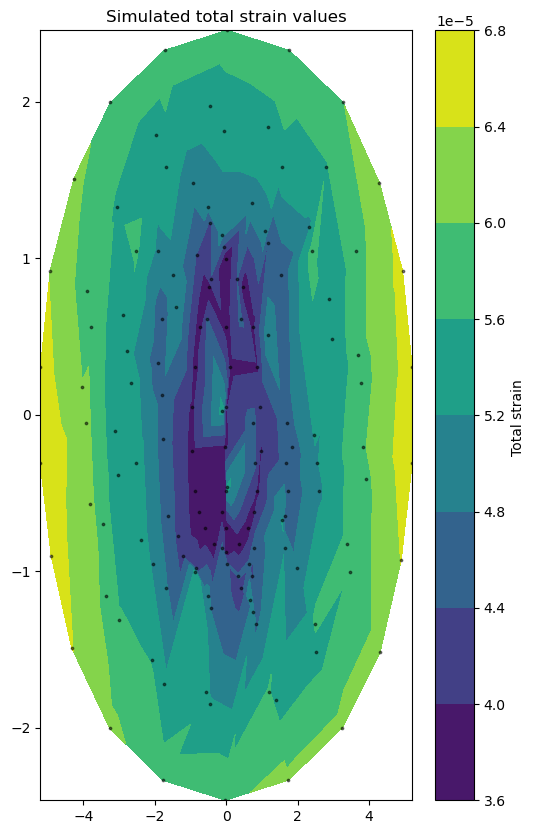

In [18]:
Total_strain_values = Test_data_to_plot[0]["ETS_C1"]
X_values = Test_data_to_plot[0]["X (mm)"]
Y_values = Test_data_to_plot[0]["Y (mm)"]
z_interpolator = scipy.interpolate.CloughTocher2DInterpolator(np.array([X_values,Y_values]).T, 
                                                              np.array(Total_strain_values))
d_xy = np.sqrt((X_values.max() - X_values.min()) * 
               (Y_values.max() - Y_values.min()) / len(X_values))
epsilon = 1. + 1e-9  # Add a little to include the endpoint in np.arange
# x_uniform = np.arange(X_values.min(), X_values.max()*epsilon, d_xy)
# y_uniform = np.arange(Y_values.min(), Y_values.max()*epsilon, d_xy)

# X, Y = np.meshgrid(x_uniform, y_uniform)
# Z = z_interpolator(np.dstack((X, Y)))


# Plot


fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=[6,10])
# fig,ax = plt.plot()
# Subplot 1: Scatter plot with tricontourf, which takes randomly positioned points
# cb = ax[0].tricontourf(X_values, Y_values, Total_strain_values)
cb = ax.tricontourf(X_values, Y_values, Total_strain_values)
# plt.colorbar(cb, ax=ax[0], label='intensity')
plt.colorbar(cb, ax=ax, label='Total strain ')


# Subplot 2: Contour plot, which takes only points positioned on a grid
# cb = ax[1].contourf(X, Y, Z)
# plt.colorbar(cb, ax=ax[1], label='intensity')

# Scatter the original data points on both subplots
# for ax_i in ax:
#     ax_i.set_xlabel('x')
#     ax_i.set_ylabel('y')
#     ax_i.scatter(X_values, Y_values, color='black', alpha=.5, s=3)
ax.scatter(X_values,Y_values, color='black', alpha=.5, s=3)
# ax_i.scatter(X, Y, alpha=.5, s=3, marker='x')
    
# ax[0].set_title('Positions randomly')
ax.set_title('Simulated total strain values')
# ax[1].set_title('Positions on regular grid')

plt.show()

# Fitting models 

## Linear model 

In [19]:
design_lin = MS(Input_names)
X_Linear = design_lin.fit_transform(X_train_df)
Linear_model = sm.OLS(y_train, X_Linear)
start_time_fit = time.monotonic()
results_lin = Linear_model.fit()
end_time_fit = time.monotonic()
print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Linear = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

X_test_Linear = design_lin.transform(X_test_df)#
start_time_predict = time.monotonic()
y_hat = results_lin.get_prediction(X_test_Linear).predicted_mean
end_time_predict = time.monotonic()
print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Linear = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["Linear",Fitting_time_Linear,Prediction_time_Linear]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index


Fitting time is  0.063
Prediction time is  0.016


## Metrics

In [20]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_linear = metric_MAPE(y_test,y_hat)
MSPE_linear = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_linear)
print("MSPE is :", MSPE_linear)

Metrics_df.loc[-1] =["Linear",MSE,MAE,R2,Adjusted_R2,MSPE_linear,MAPE_linear]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.0015409455526292244
sqrt MSE is :  0.0392548793480406
MAE is :  0.02223159853492083
R2 is :  0.6650589991389583
Adjusted R2 is :  0.6650468989971319
MAPE is : 1583.9941456038432
MSPE is : 1108019.783937656


## Residuals

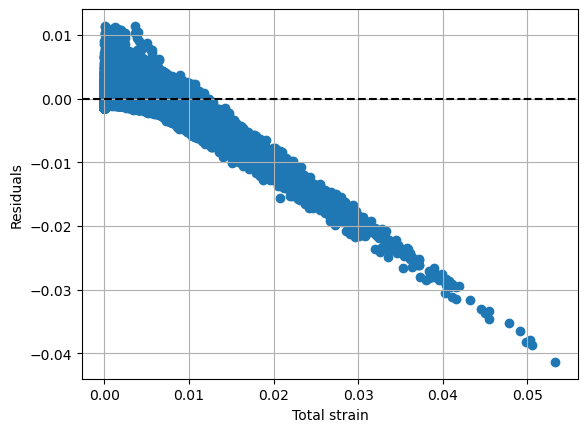

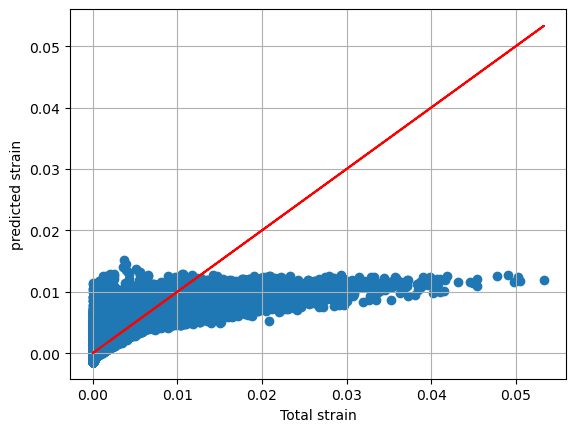

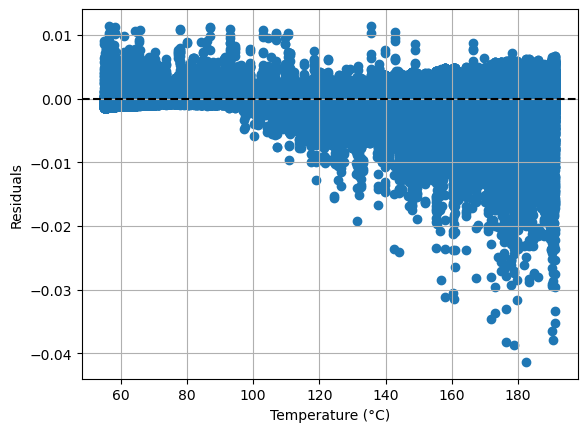

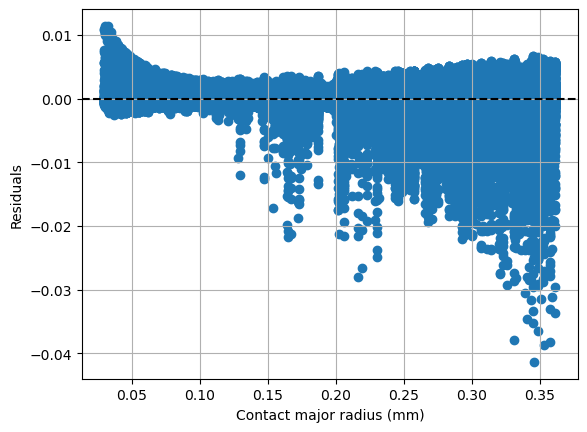

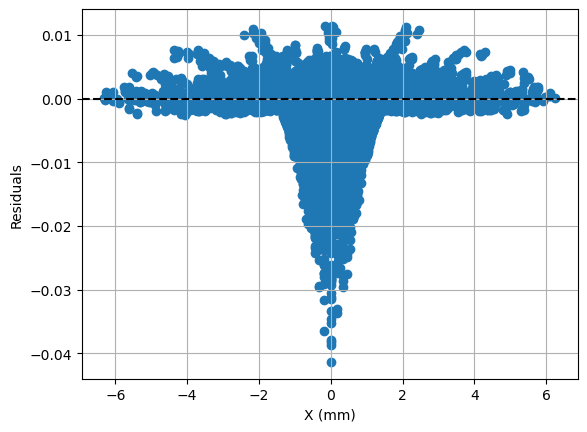

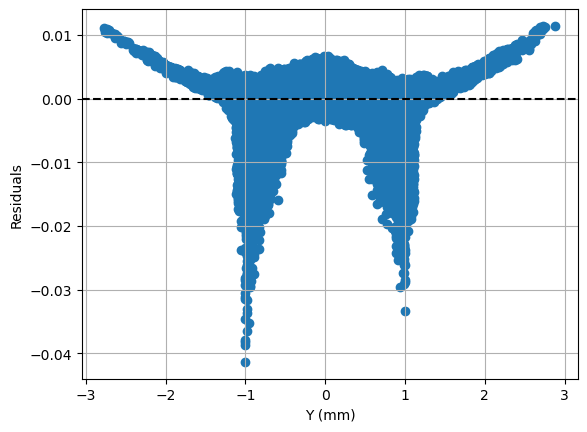

In [21]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

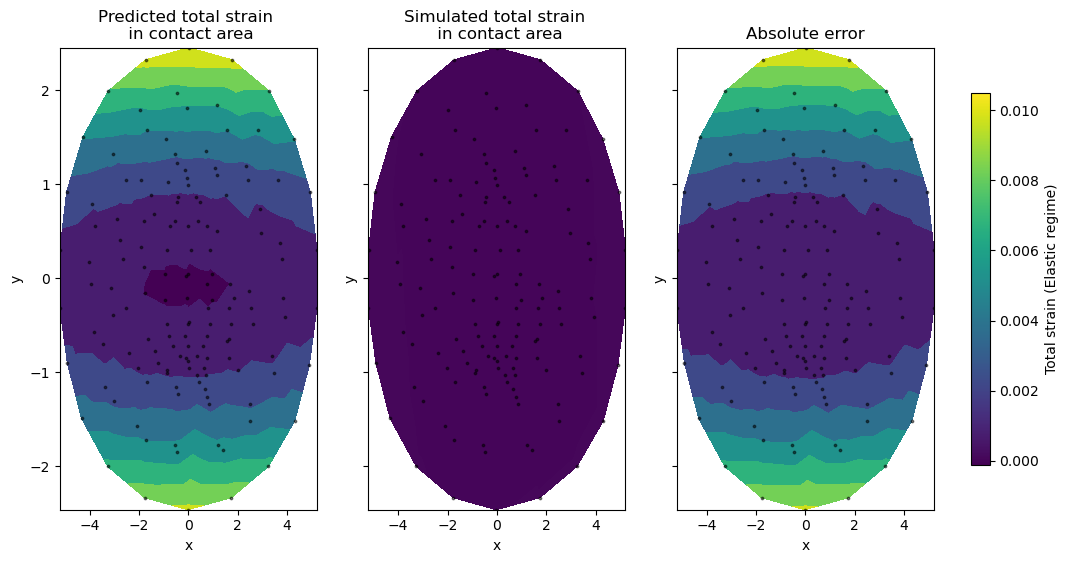

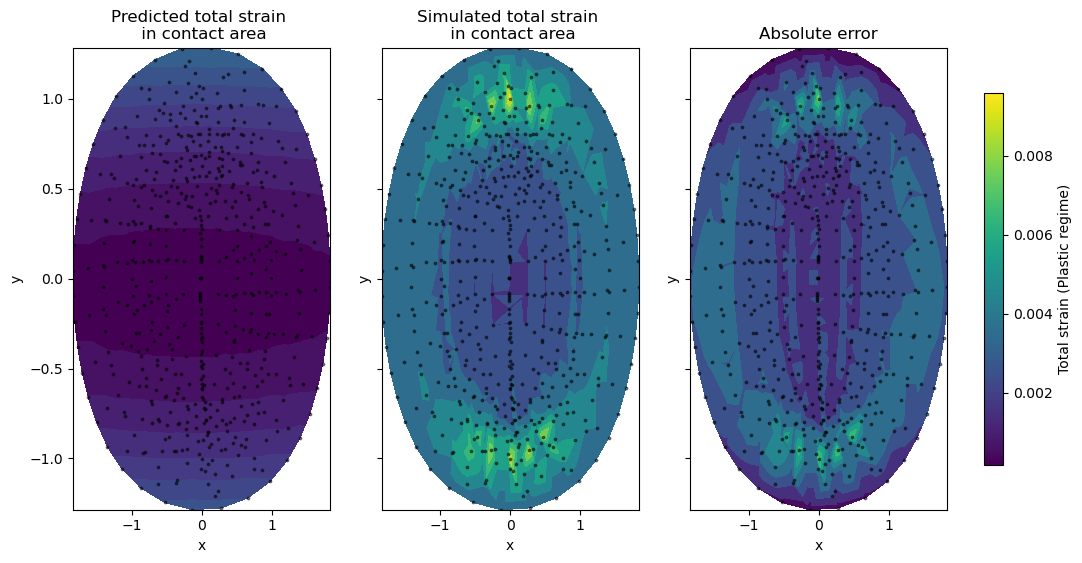

In [22]:
model_name = "Linear";predictor = results_lin;des_lin = design_lin
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# LASSO

In [23]:

# Define RidgeCV model with multiple alpha values to test
alphas = 10**np.linspace(6, -6, 1000)
Lasso_model = LassoCV(alphas=alphas)  # Cross-validation is built-in

# Fit the model
start_time_fit = time.monotonic()

Lasso_model.fit(X_Linear, y_train)
end_time_fit = time.monotonic()
# Best alpha value
best_alpha = Lasso_model.alpha_

# Predictions
start_time_predict = time.monotonic()
y_hat = Lasso_model.predict(X_test_Linear)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Lasso = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Lasso = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["LASSO",Fitting_time_Lasso,Prediction_time_Lasso]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\SurrogateAI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting time is  3.156
Prediction time is  0.016


## Metrics


In [24]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_LASSO = metric_MAPE(y_test,y_hat)
MSPE_LASSO = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_LASSO)
print("MSPE is :", MSPE_LASSO)

Metrics_df.loc[-1] =["LASSO",MSE,MAE,R2,Adjusted_R2,MSPE_LASSO,MAPE_LASSO]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.0015409588326882858
sqrt MSE is :  0.03925504849937503
MAE is :  0.022226957485177123
R2 is :  0.6650561125760516
Adjusted R2 is :  0.6650440123299446
MAPE is : 1582.031864580812
MSPE is : 1103797.4410687438


## Residuals 

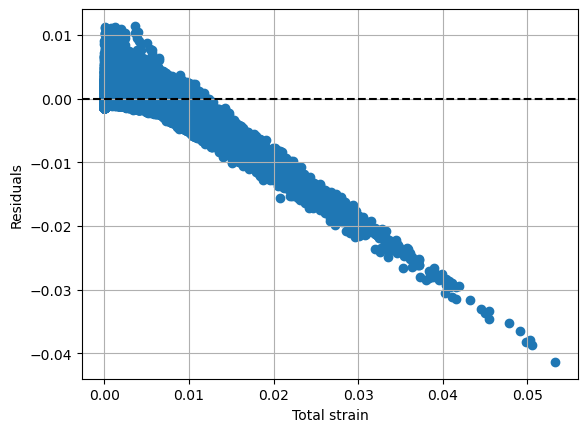

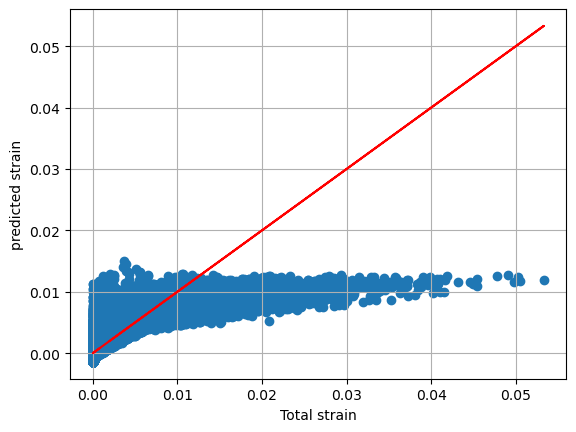

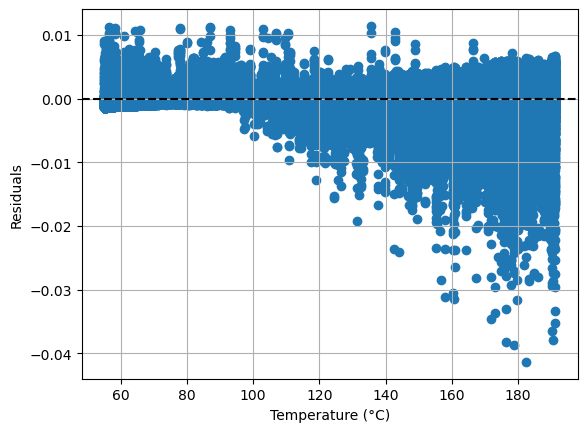

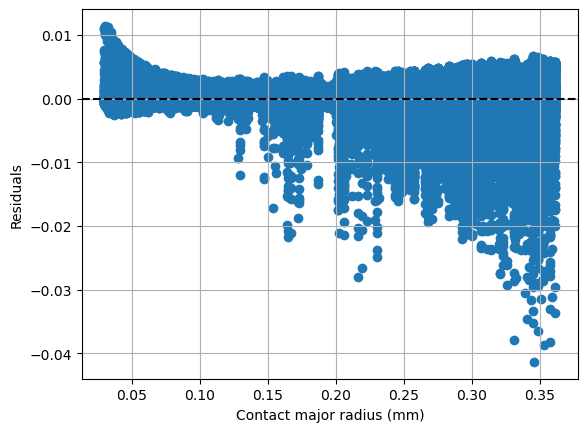

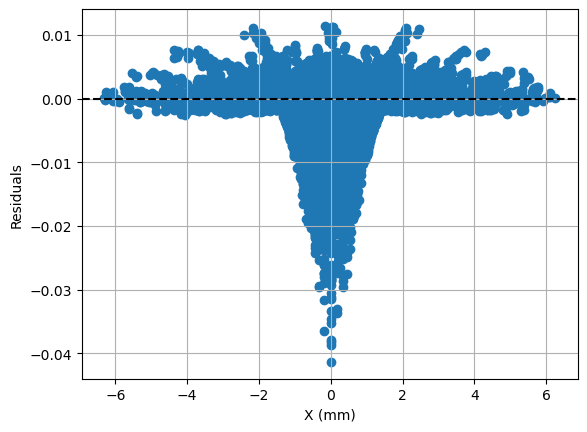

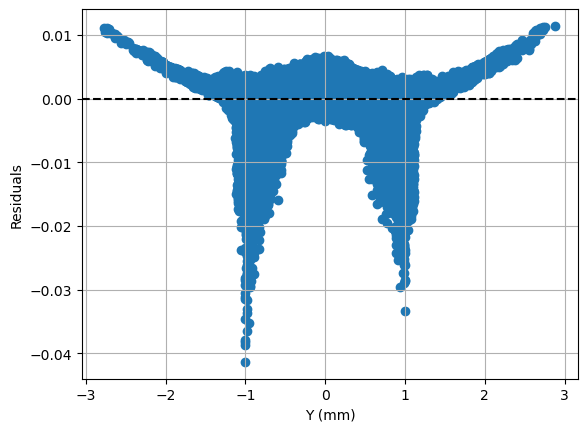

In [25]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

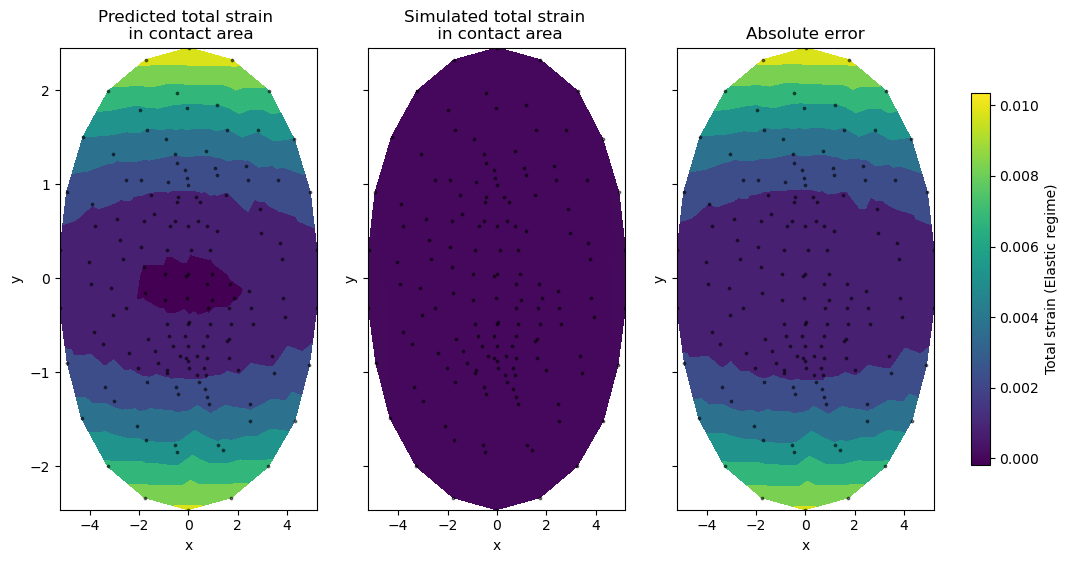

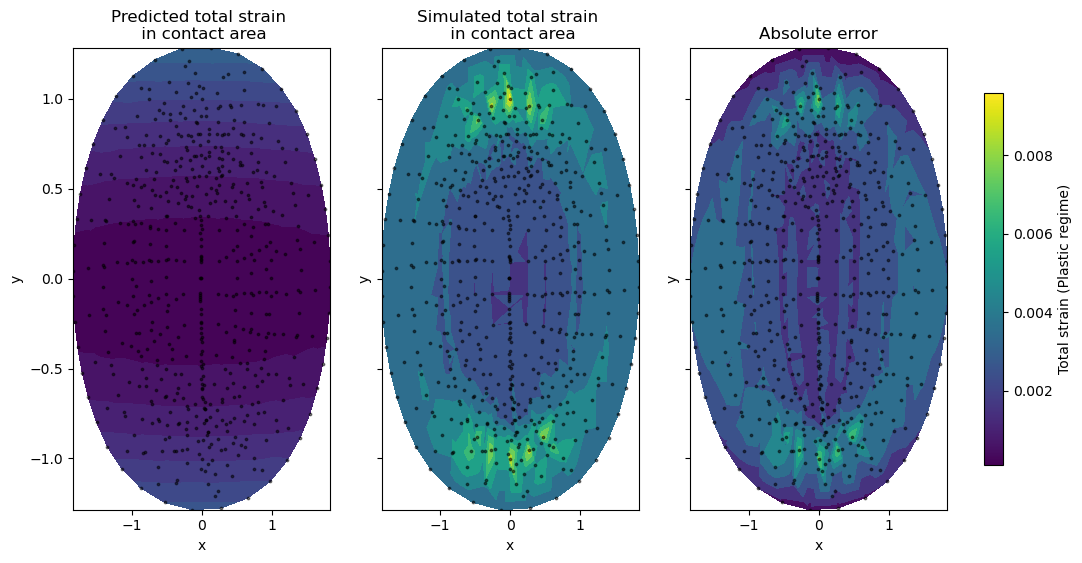

In [26]:
model_name = "LASSO";predictor = Lasso_model;des_lin = design_lin
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Ridge


In [27]:

# Define RidgeCV model with multiple alpha values to test
alphas = 10**np.linspace(4, -4, 100)
# Ridge_model = RidgeCV(alphas=alphas, store_cv_values=True)
Ridge_model = RidgeCV(alphas=alphas)
# Fit the model
start_time_fit = time.monotonic()

Ridge_model.fit(X_Linear, y_train)
end_time_fit = time.monotonic()
# Best alpha value
best_alpha = Ridge_model.alpha_

# Predictions
start_time_predict = time.monotonic()
y_hat = Ridge_model.predict(X_test_Linear)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Ridge = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Ridge = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["Ridge",Fitting_time_Ridge,Prediction_time_Ridge]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index


Fitting time is  2.562
Prediction time is  0.0


## Metrics

In [28]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Ridge = metric_MAPE(y_test,y_hat)
MSPE_Ridge = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Ridge)
print("MSPE is :", MSPE_Ridge)

Metrics_df.loc[-1] =["Ridge",MSE,MAE,R2,Adjusted_R2,MSPE_Ridge,MAPE_Ridge]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.00154094352395796
sqrt MSE is :  0.039254853508298305
MAE is :  0.0222276485512867
R2 is :  0.6650594400923603
Adjusted R2 is :  0.6650473399664638
MAPE is : 1583.0718518241379
MSPE is : 1106694.002431604


## Residuals 

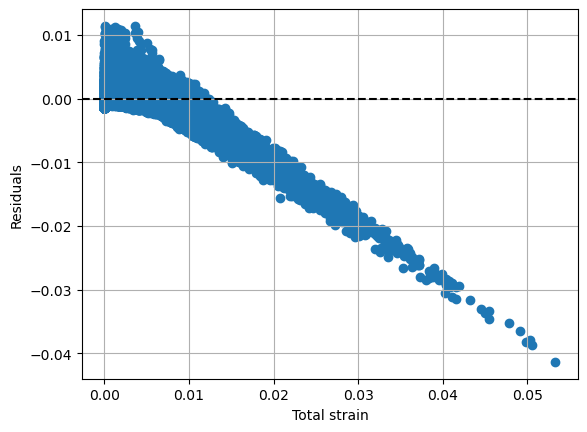

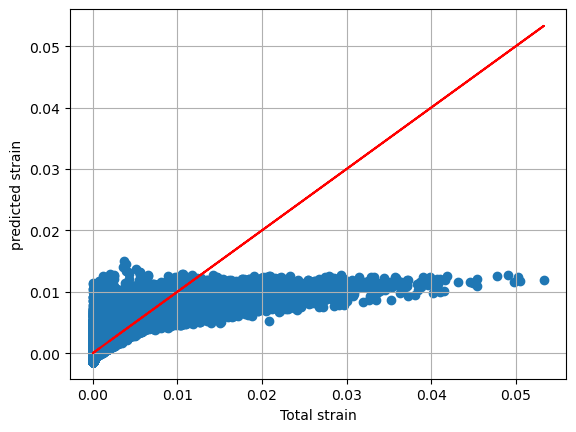

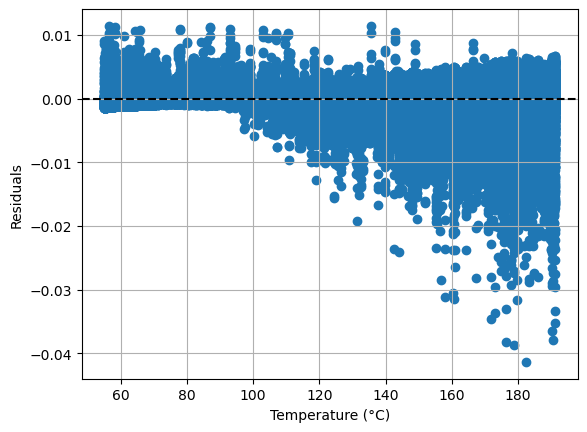

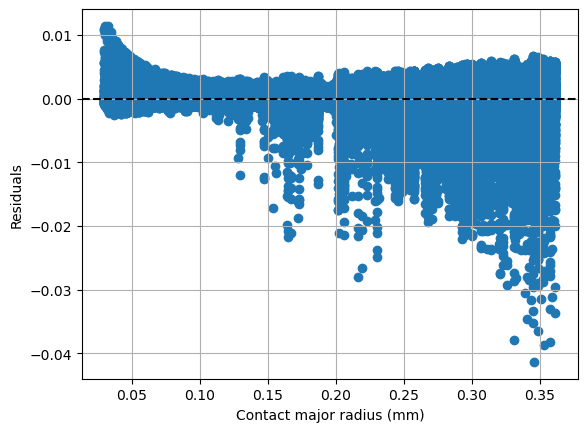

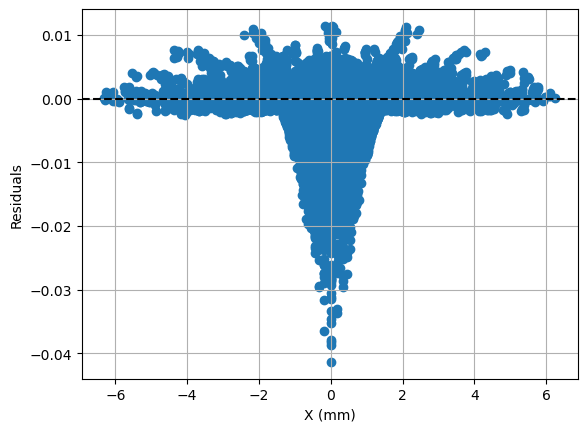

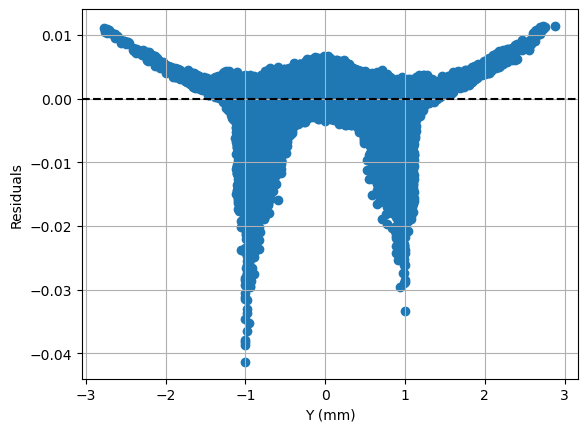

In [29]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

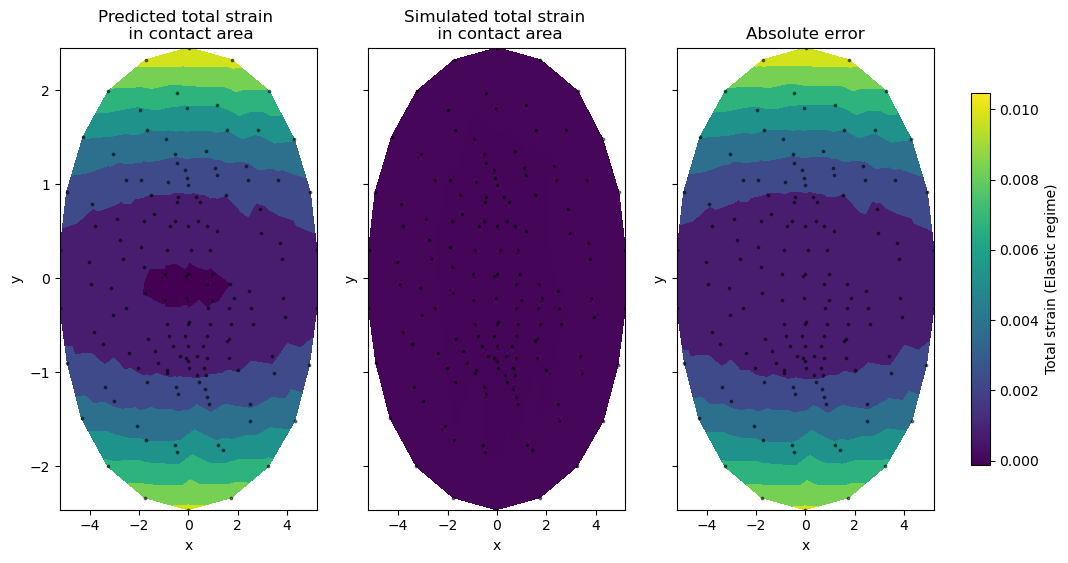

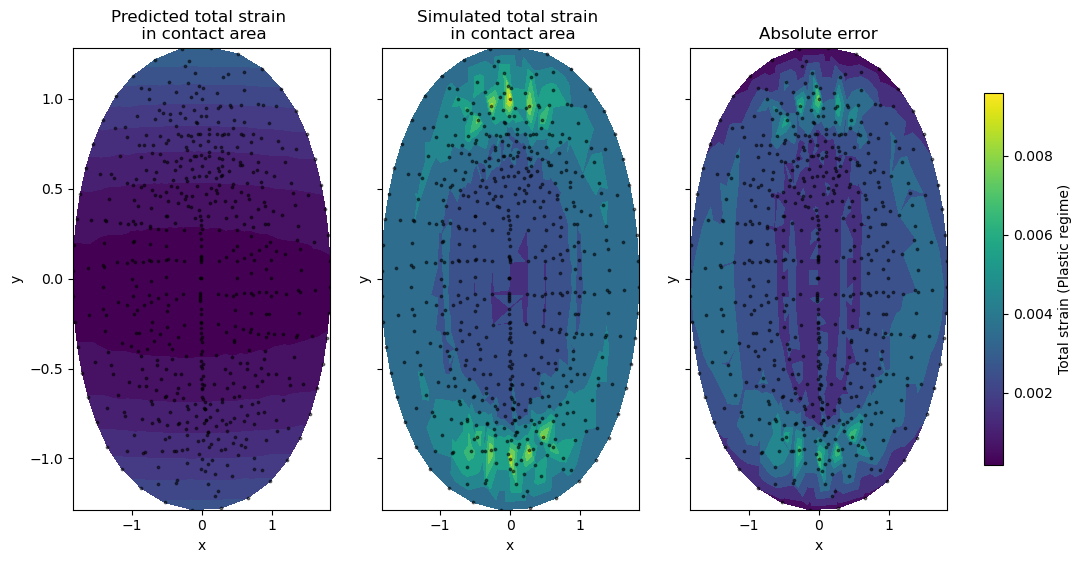

In [30]:
model_name = "Ridge";predictor = Ridge_model;des_lin = design_lin
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# ElasticNet

In [31]:
alphas = np.logspace(-10, 1, 250)  # 50 alphas between 0.001 and 10
l1_ratios = np.linspace(0.01, 10.0, 100)  # 10 values between 0.1 and 1 (Lasso to Elastic Net)

ElasticNet_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42)  # 5-fold cross-validation

# Fit the model
start_time_fit = time.monotonic()

ElasticNet_model.fit(X_Linear, y_train)
end_time_fit = time.monotonic()
# Best alpha value
best_alpha = ElasticNet_model.alpha_

# Predictions
start_time_predict = time.monotonic()
y_hat = ElasticNet_model.predict(X_test_Linear)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_ElasticNet = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_ElasticNet = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["ElasticNet",Fitting_time_ElasticNet,Prediction_time_ElasticNet]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\SurrogateAI\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting time is  90.75
Prediction time is  0.016


## Metrics

In [32]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Elastic = metric_MAPE(y_test,y_hat)
MSPE_Elastic = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Elastic)
print("MSPE is :", MSPE_Elastic)

Metrics_df.loc[-1] =["ElasticNet",MSE,MAE,R2,Adjusted_R2,MSPE_Elastic,MAPE_Elastic]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.0015409518412322952
sqrt MSE is :  0.039254959447594585
MAE is :  0.02222928331627081
R2 is :  0.6650576322438055
Adjusted R2 is :  0.6650455320525985
MAPE is : 1582.8905629263672
MSPE is : 1105488.313232741


## Residuals 

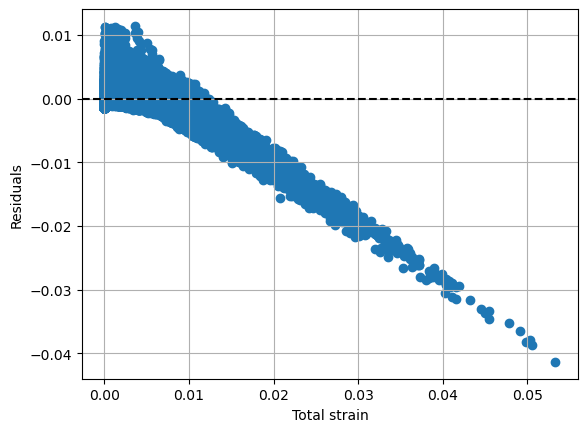

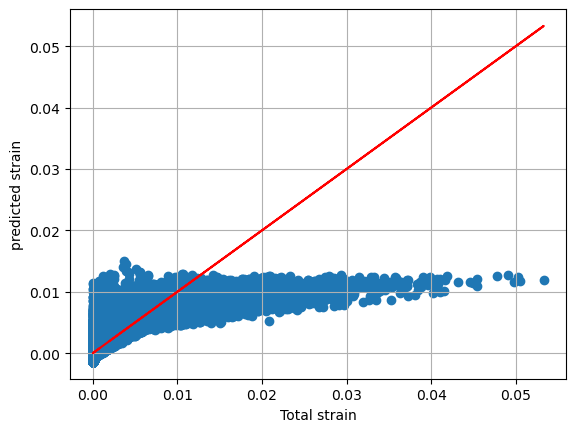

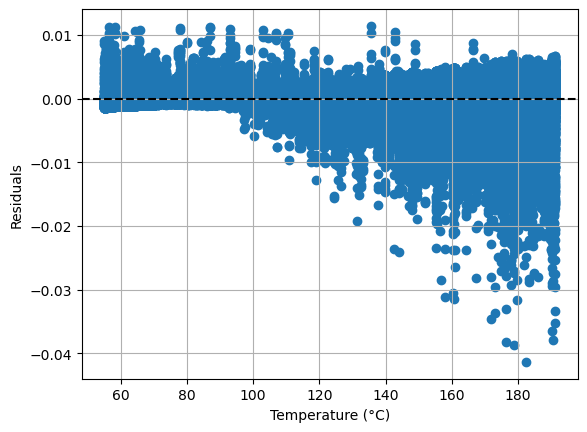

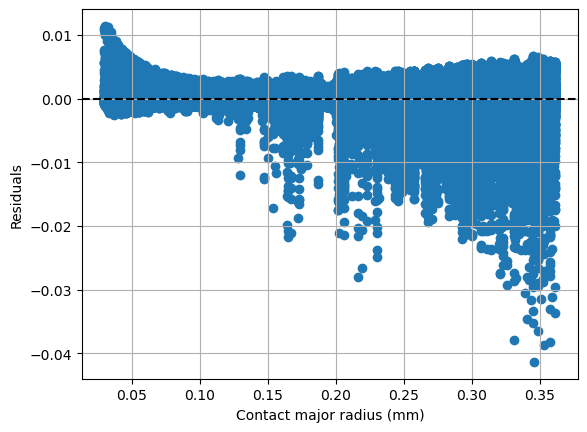

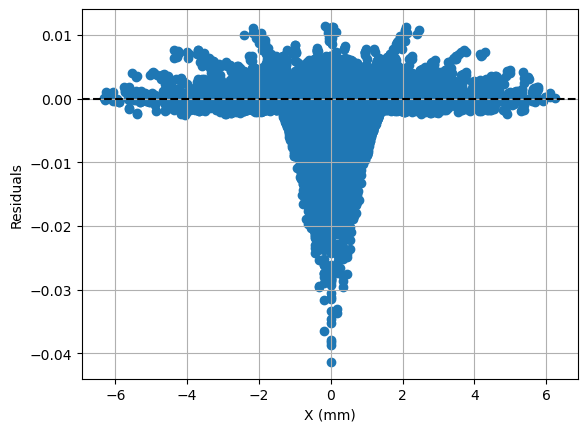

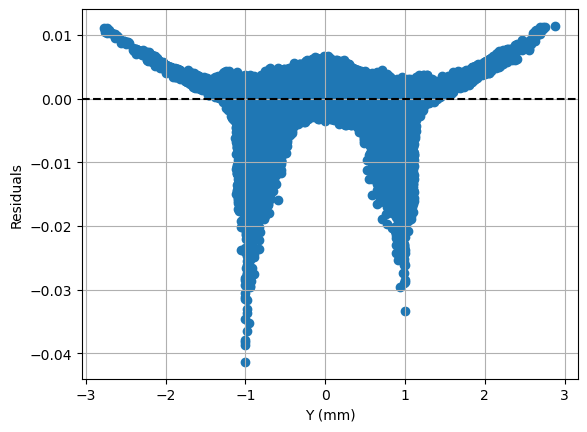

In [33]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

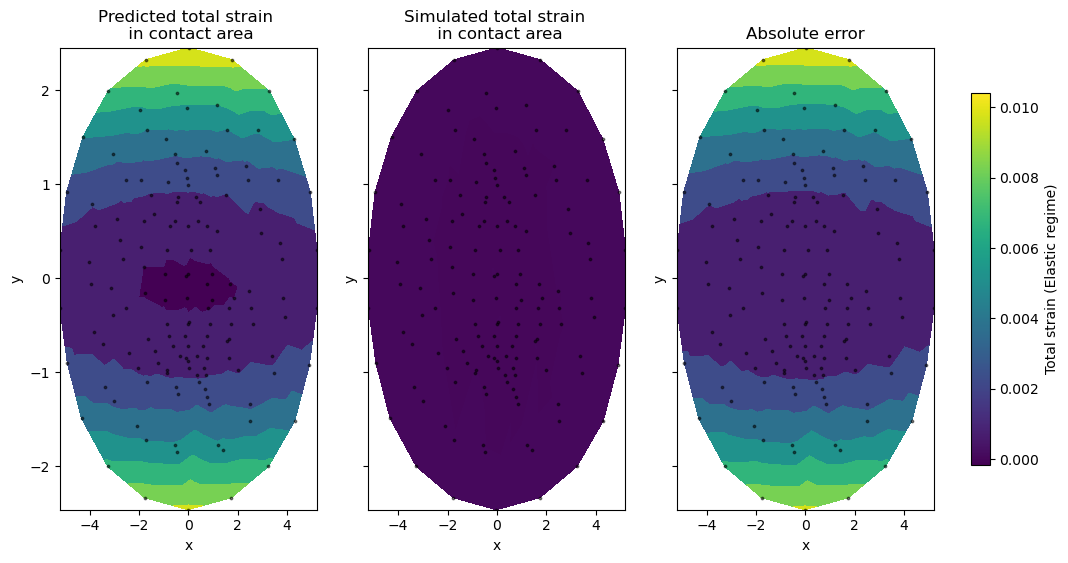

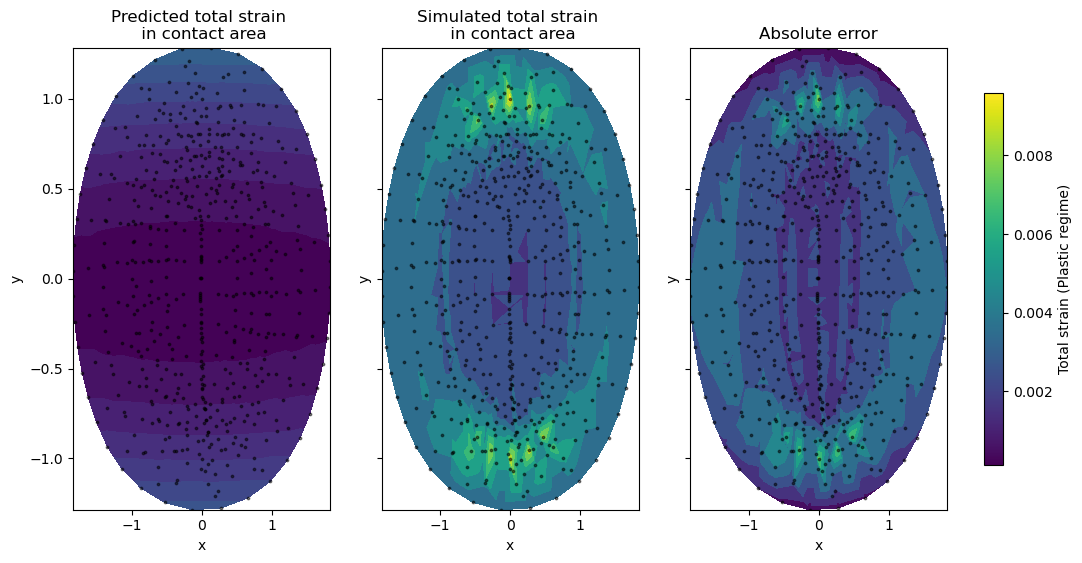

In [34]:
model_name = "ElasticNet";predictor = ElasticNet_model;des_lin = design_lin
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Polynomial regression

In [35]:
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=True)
# design = MS(Input_names)
X_Poly = poly.fit_transform(pd.DataFrame(X_train,columns=Input_names))
Poly_model = sm.OLS(y_train, X_Poly)
start_time_fit = time.monotonic()
results_poly = Poly_model.fit()
end_time_fit = time.monotonic()


X_test_Poly = poly.fit_transform(pd.DataFrame(X_test,columns=Input_names))
start_time_predict = time.monotonic()
new_predictions = results_poly.get_prediction(X_test_Poly)
end_time_predict = time.monotonic()
print("Prediction time is " , timedelta(end_time_predict - start_time_predict))
y_hat = new_predictions.predicted_mean


print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Poly = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Poly = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()
Time_df.loc[-1] =["Poly",Fitting_time_Poly,Prediction_time_Poly]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index




Prediction time is  4 days, 22:53:45.600002
Fitting time is  43.437
Prediction time is  4.954


## Metrics

In [36]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Poly = metric_MAPE(y_test,y_hat)
MSPE_Poly = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Poly)
print("MSPE is :", MSPE_Poly)
Metrics_df.loc[-1] =["Polynomial Regression",MSE,MAE,R2,Adjusted_R2,MSPE_Poly,MAPE_Poly]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.0005222980368196693
sqrt MSE is :  0.022853840745477975
MAE is :  0.009877827533123005
R2 is :  0.8864729341658768
Adjusted R2 is :  0.8864688328656651
MAPE is : 342.72196404883033
MSPE is : 51795.08050525257


## Residuals 

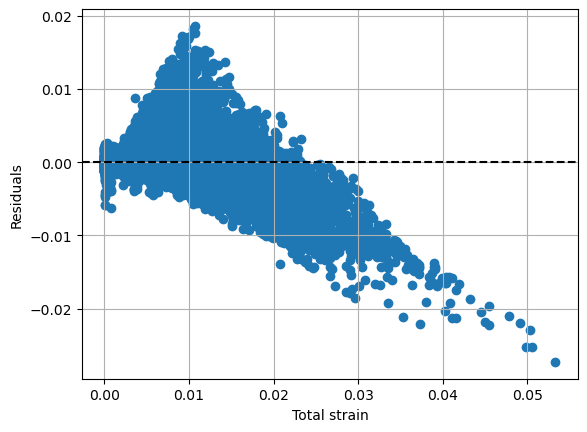

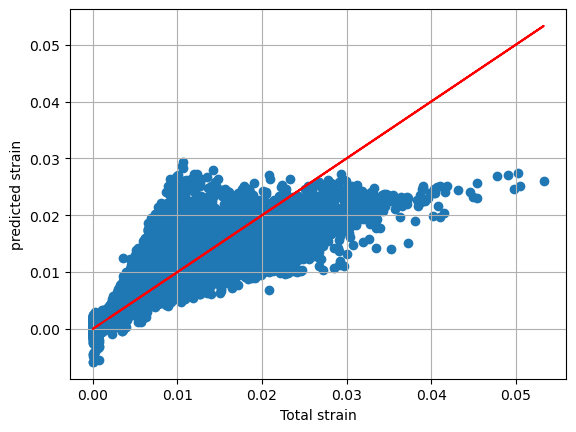

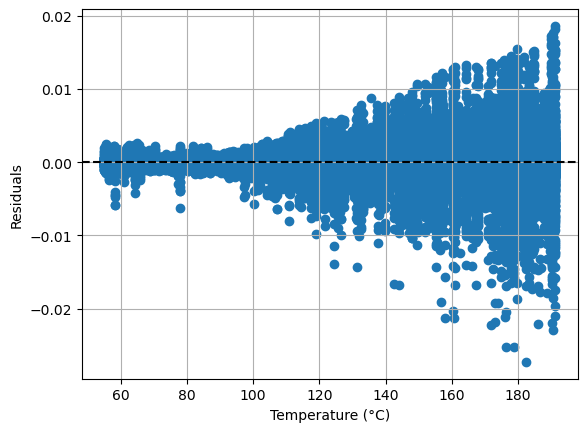

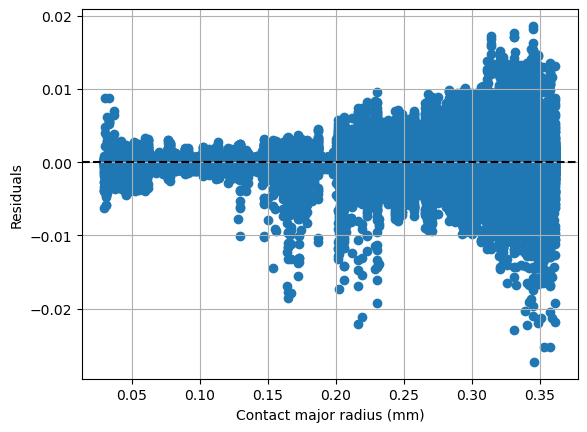

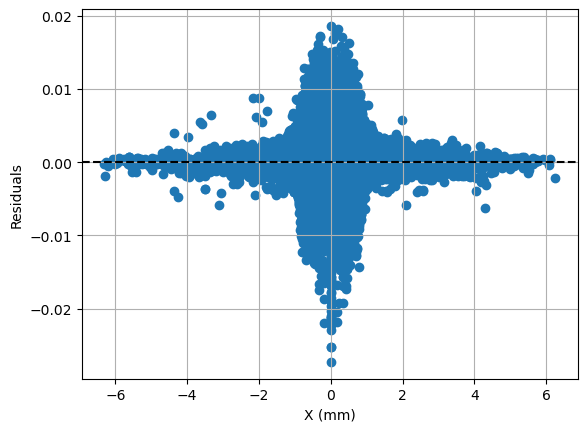

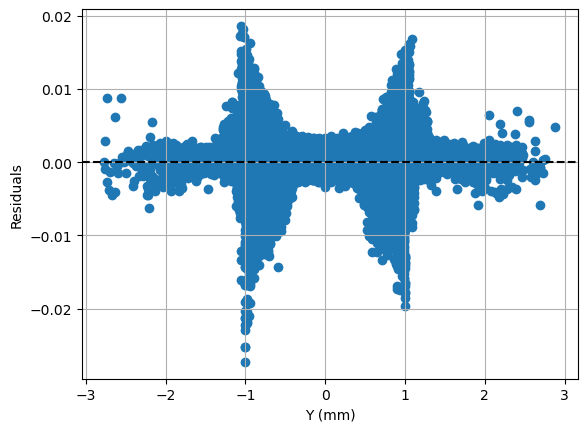

In [37]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

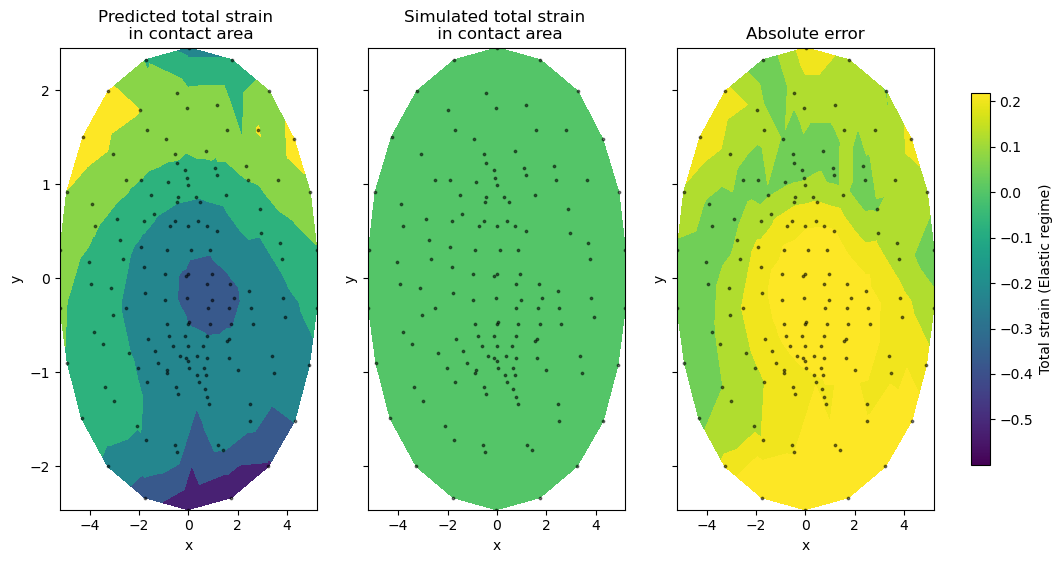

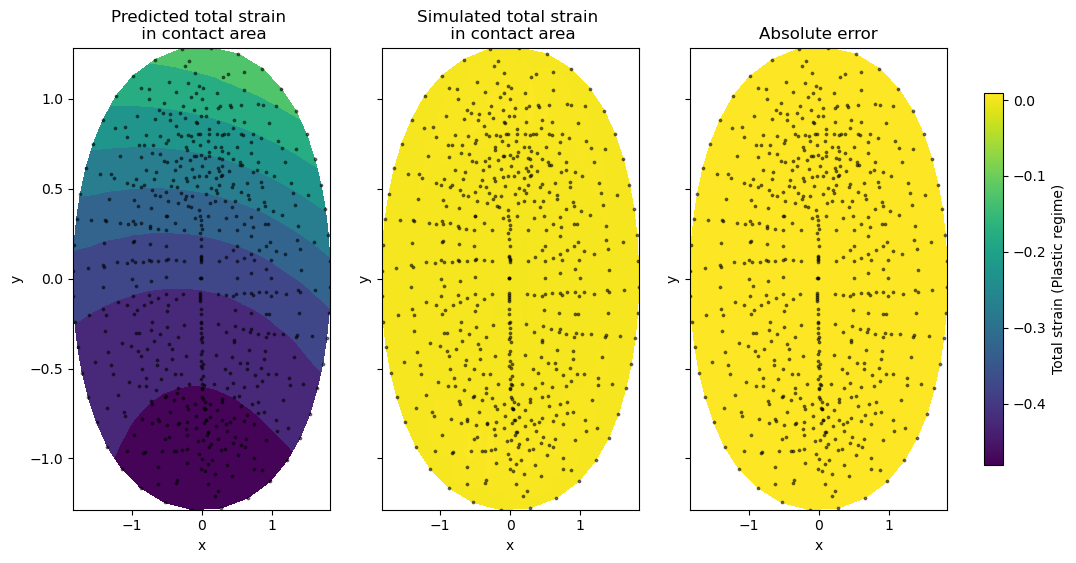

In [38]:
model_name = "Polynomial";predictor = results_poly;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)


# Decision Tree

In [39]:
DecisionTree_model = DTR(max_depth =10)
start_time_fit = time.monotonic()
DecisionTree_model.fit(X_train , y_train)
end_time_fit = time.monotonic()


# Predictions
start_time_predict = time.monotonic()
y_hat = DecisionTree_model.predict(X_test)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_DecisionTree = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_DecisionTree = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["Decision Tree",Fitting_time_DecisionTree,Prediction_time_DecisionTree]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



Fitting time is  2.938
Prediction time is  0.015


## Metrics

In [40]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Tree = metric_MAPE(y_test,y_hat)
MSPE_Tree = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Tree)
print("MSPE is :", MSPE_Tree)

Metrics_df.loc[-1] =["Decision Tree",MSE,MAE,R2,Adjusted_R2,MSPE_Tree,MAPE_Tree]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.0003897440357237027
sqrt MSE is :  0.019741935966963896
MAE is :  0.0074474313280124575
R2 is :  0.9152849643634821
Adjusted R2 is :  0.9152819039321124
MAPE is : 12.802325348998684
MSPE is : 4.363896305930008


## Residuals 

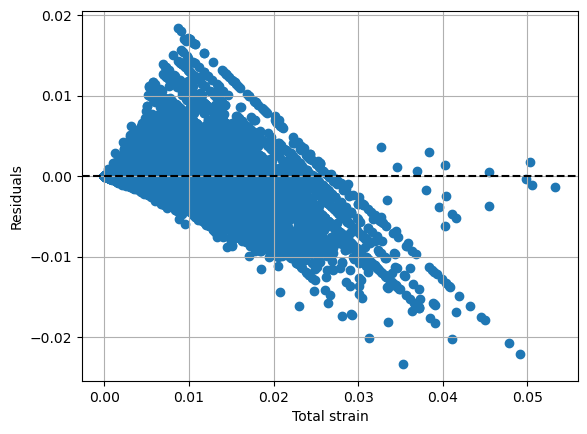

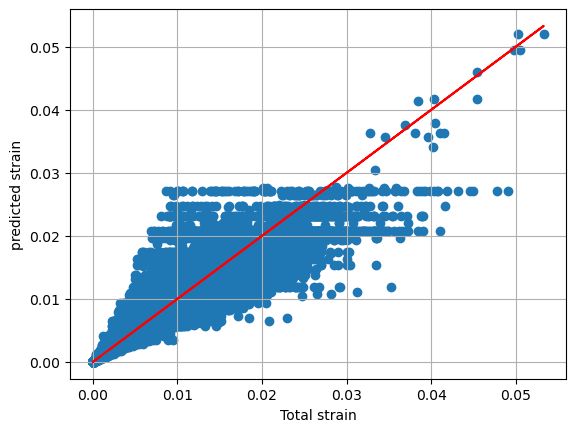

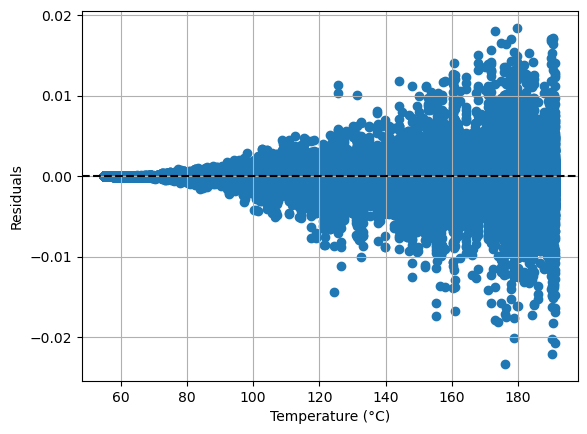

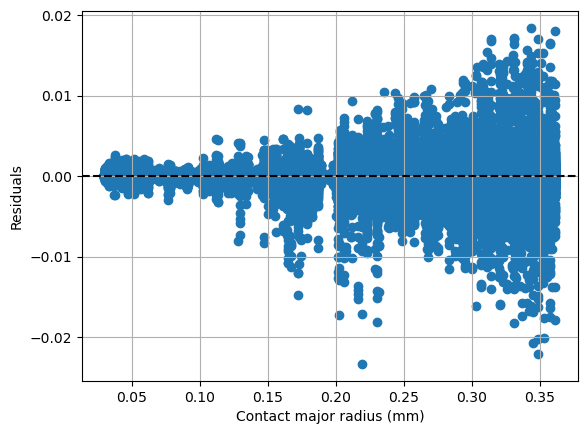

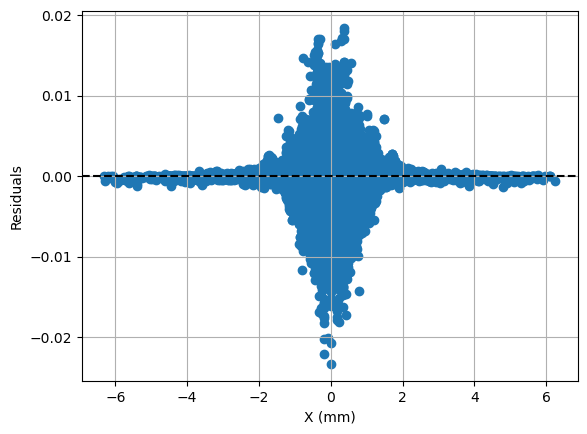

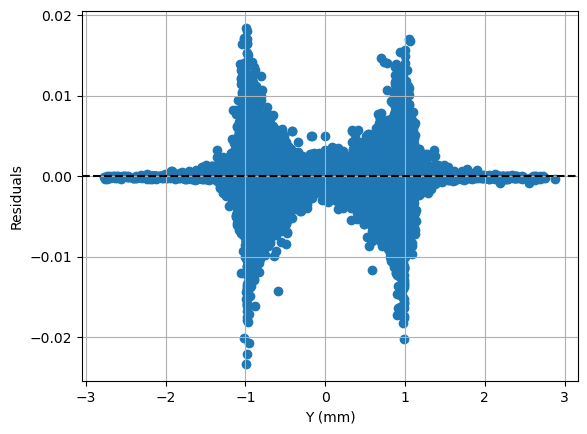

In [41]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

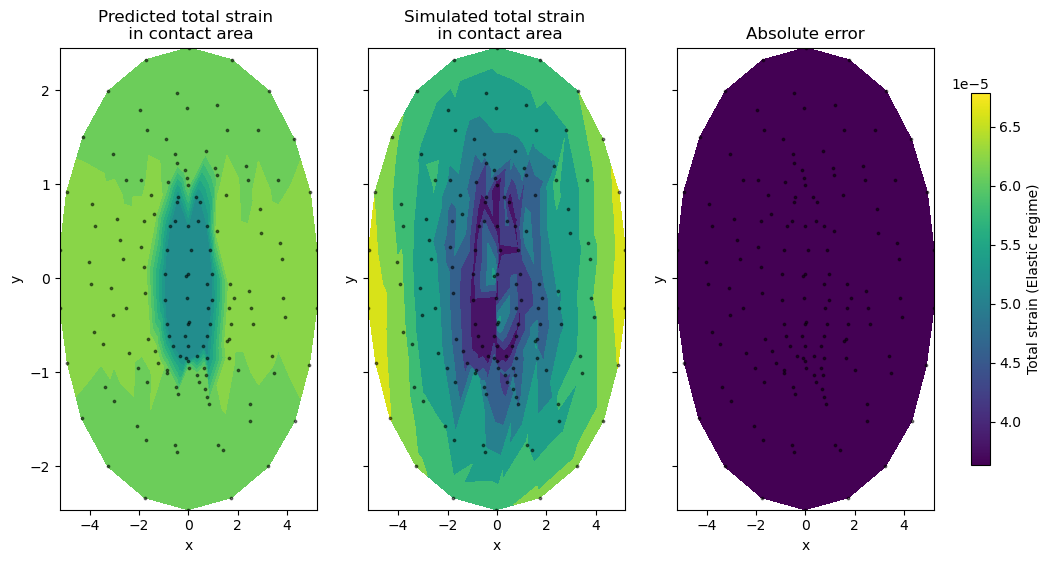

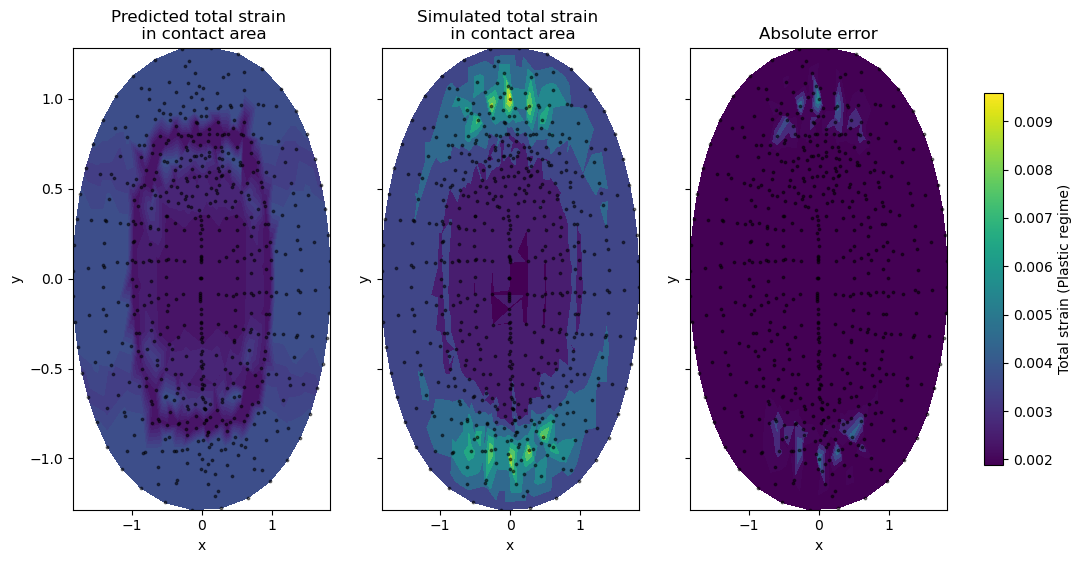

In [42]:
model_name = "DecisionTree";predictor = DecisionTree_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)


# Random forest

In [43]:
RandomForest_model = RF(max_features=10,
n_estimators =500,
random_state =0)
# Fit the model
start_time_fit = time.monotonic()

RandomForest_model.fit(X_train , y_train.ravel())
end_time_fit = time.monotonic()
# Best alpha value

# Predictions
start_time_predict = time.monotonic()
y_hat = RandomForest_model.predict(X_test)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_RandomForest = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds =end_time_predict - start_time_predict).total_seconds())
Prediction_time_RandomForest = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()
Time_df.loc[-1] =["RandomForest",Fitting_time_RandomForest,Prediction_time_RandomForest]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index

Fitting time is  1614.656
Prediction time is  23.312


## Metrics

In [44]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_RF = metric_MAPE(y_test,y_hat)
MSPE_RF = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_RF)
print("MSPE is :", MSPE_RF)
Metrics_df.loc[-1] =["Random Forest",MSE,MAE,R2,Adjusted_R2,MSPE_RF,MAPE_RF]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.00012437554565391135
sqrt MSE is :  0.01115237847519135
MAE is :  0.003960602207559454
R2 is :  0.9729656445856378
Adjusted R2 is :  0.9729646679374107
MAPE is : 6.21876323174391
MSPE is : 0.9901601252847251


## Residuals 

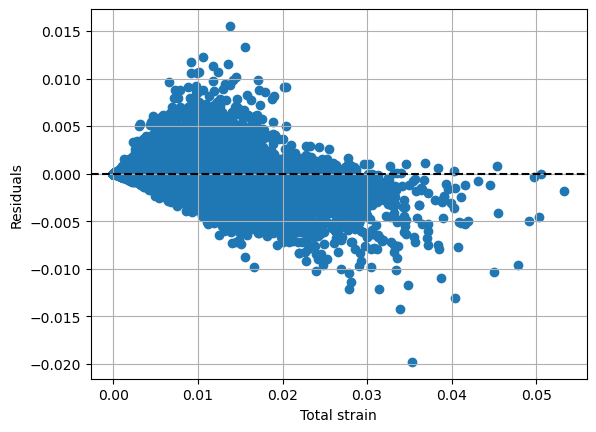

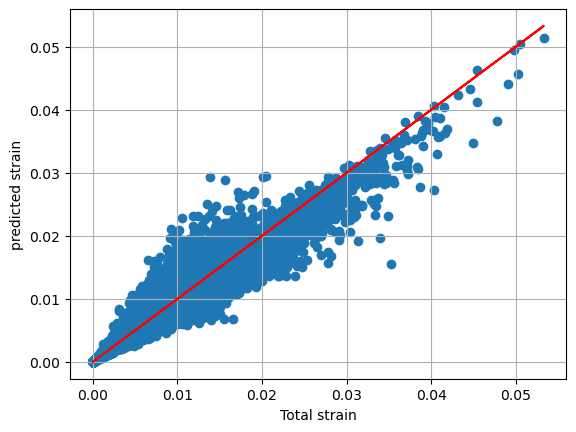

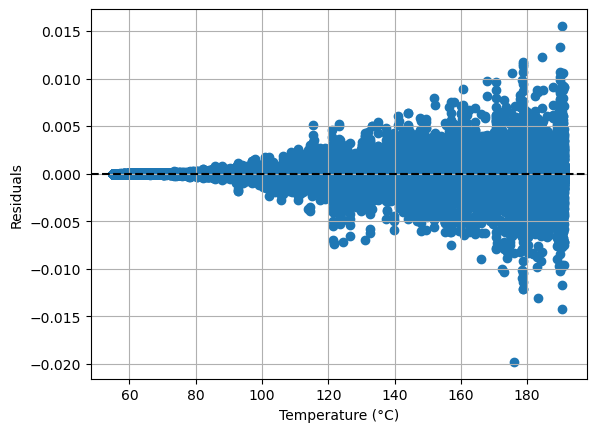

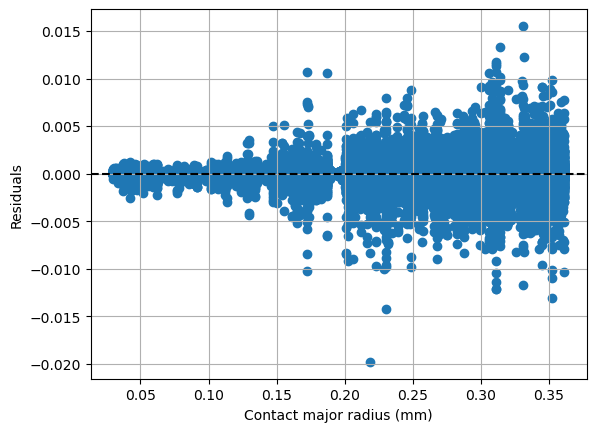

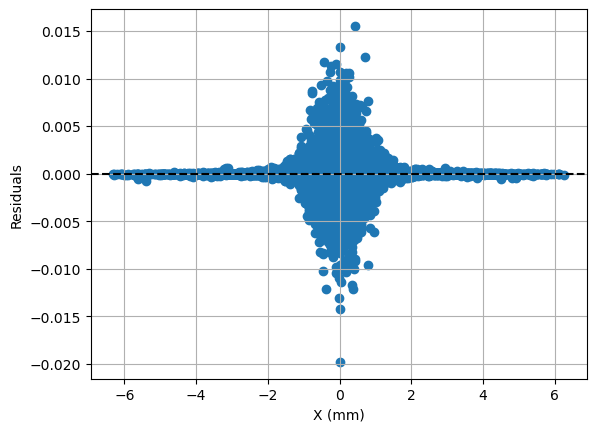

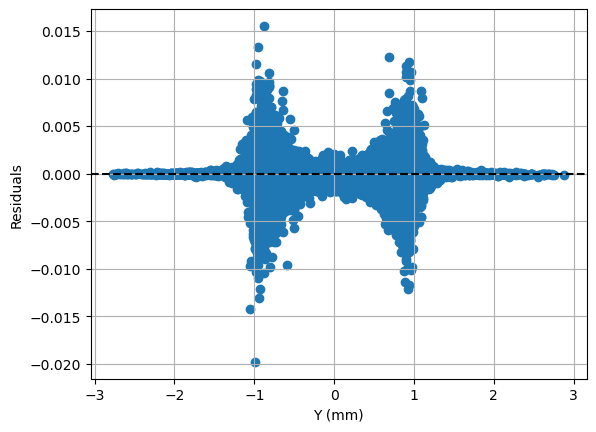

In [45]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

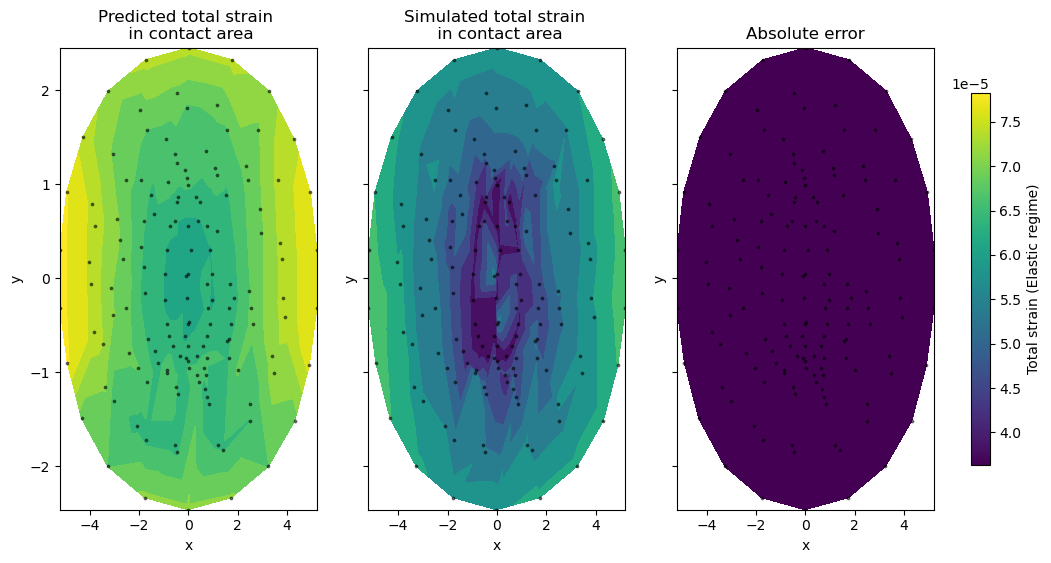

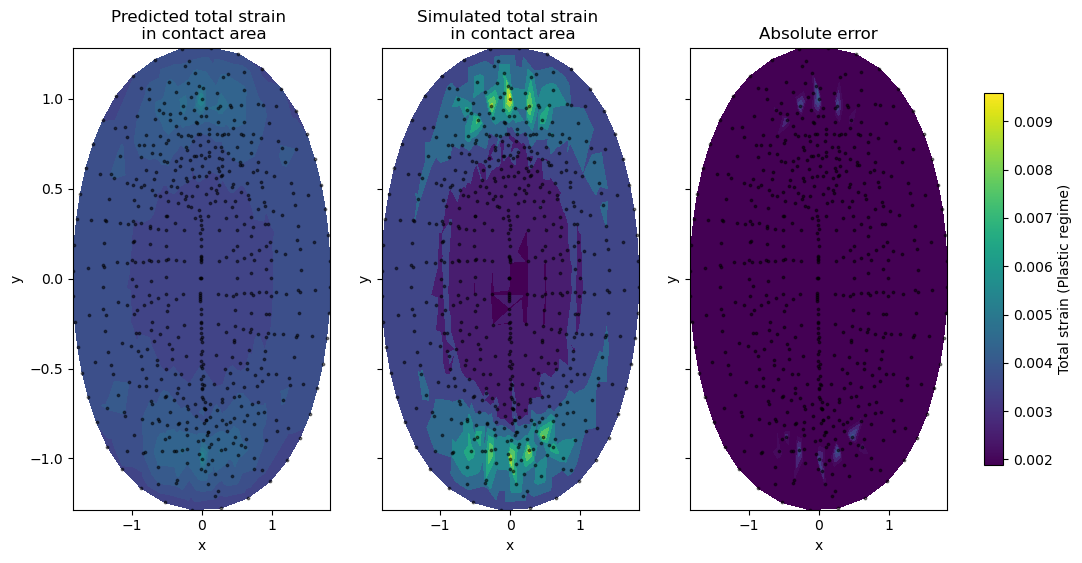

In [46]:
model_name = "RandomForest";predictor = RandomForest_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Boosting

In [47]:
Boosting_model = GBR(n_estimators =100 ,
learning_rate =0.1 ,
max_depth =5,
random_state =0)

start_time_fit = time.monotonic()
Boosting_model.fit(X_train , y_train)
end_time_fit = time.monotonic()


# Predictions
start_time_predict = time.monotonic()
y_hat = Boosting_model.predict(X_test)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Boosting = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Boosting = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["Boosting",Fitting_time_Boosting,Prediction_time_Boosting]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\SurrogateAI\lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Fitting time is  181.266
Prediction time is  0.109


## Metrics

In [48]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Boosting = metric_MAPE(y_test,y_hat)
MSPE_Boosting = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Boosting)
print("MSPE is :", MSPE_Boosting)

Metrics_df.loc[-1] =["Boosting",MSE,MAE,R2,Adjusted_R2,MSPE_Boosting,MAPE_Boosting]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.00029312857930362734
sqrt MSE is :  0.017120998198225105
MAE is :  0.0070133110885441125
R2 is :  0.9362853674061279
Adjusted R2 is :  0.9362830656392829
MAPE is : 91.01447054833332
MSPE is : 3493.162660732484


## Residuals 

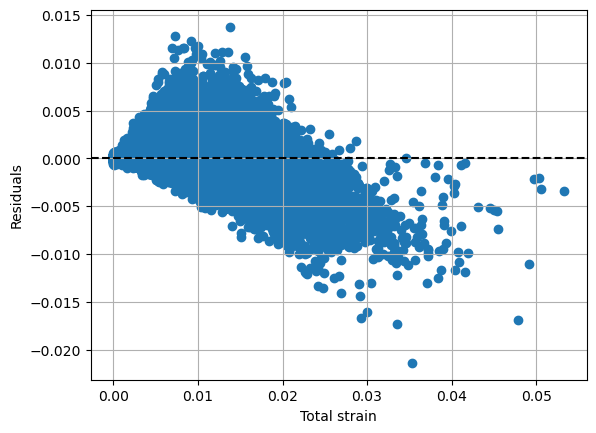

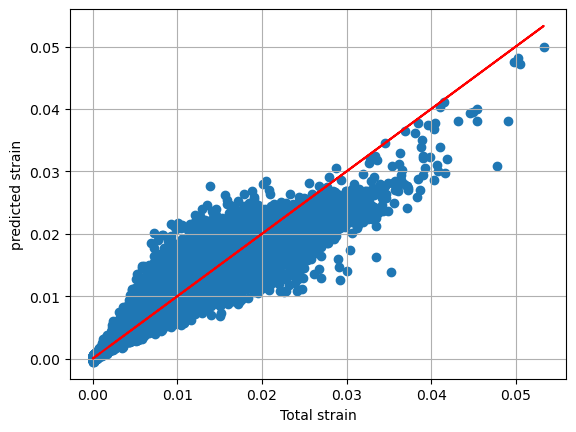

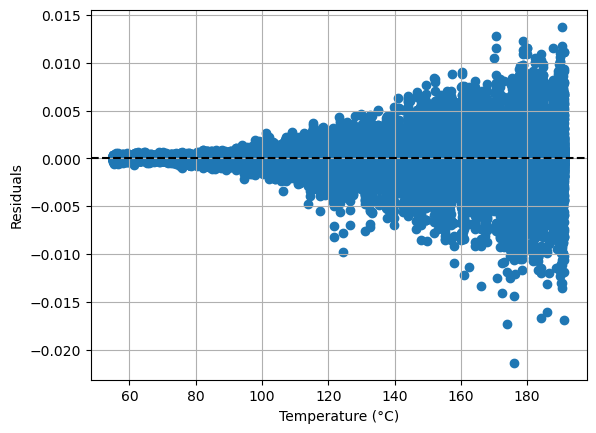

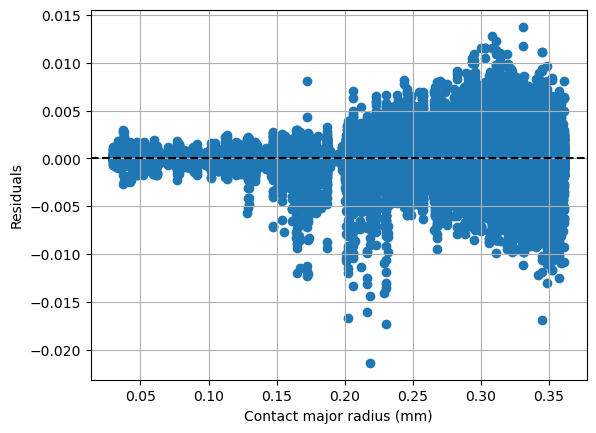

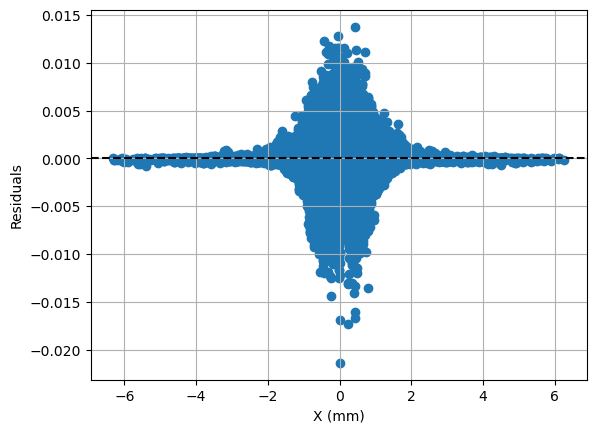

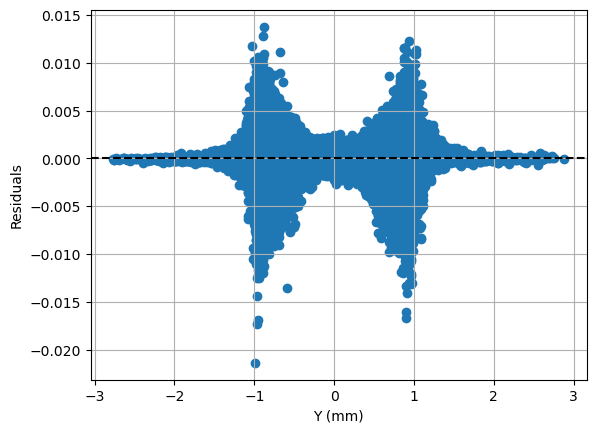

In [49]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

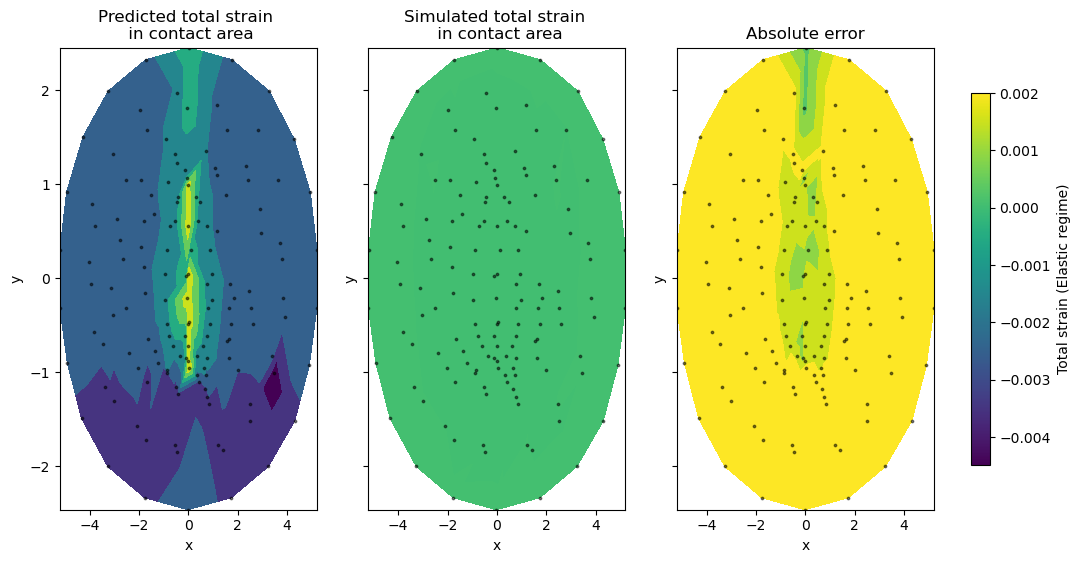

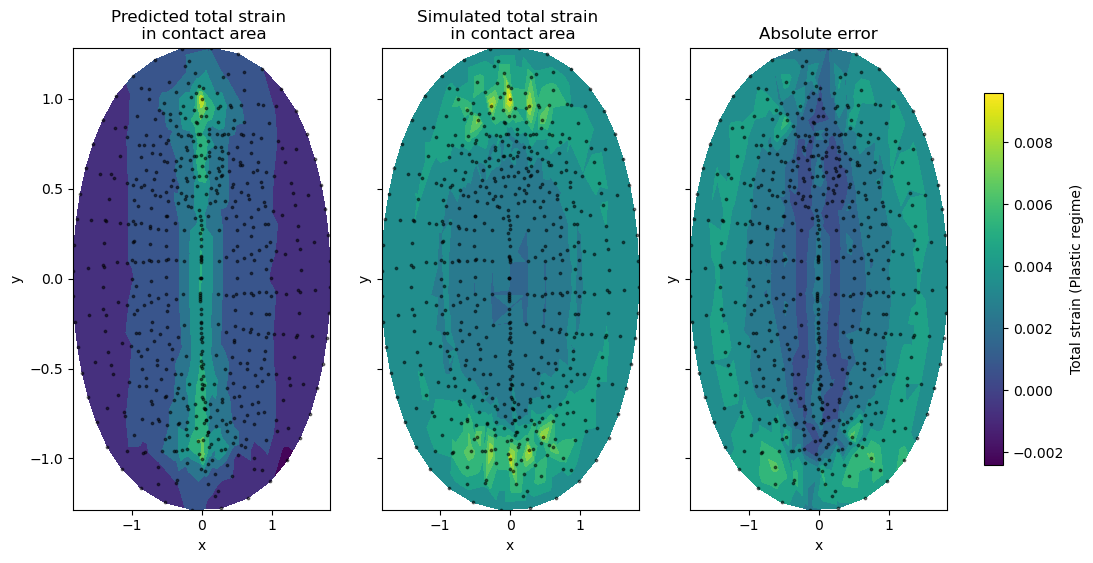

In [50]:
model_name = "Boosting";predictor = Boosting_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Bagging

In [51]:
Bagging_model = RF(max_features=X_train.shape[1],
n_estimators =500,
random_state =0)

start_time_fit = time.monotonic()
Bagging_model.fit(X_train , y_train.ravel())
end_time_fit = time.monotonic()


# Predictions
start_time_predict = time.monotonic()
y_hat = Bagging_model.predict(X_test)
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_Bagging = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_Bagging = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["Bagging",Fitting_time_Bagging,Prediction_time_Bagging]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



Fitting time is  1884.016
Prediction time is  23.515


## Metrics

In [52]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_Bagging = metric_MAPE(y_test,y_hat)
MSPE_Bagging = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_Bagging)
print("MSPE is :", MSPE_Bagging)

Metrics_df.loc[-1] =["Bagging",MSE,MAE,R2,Adjusted_R2,MSPE_Bagging,MAPE_Bagging]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.00012150649917348266
sqrt MSE is :  0.011022998647077965
MAE is :  0.0038772217647215935
R2 is :  0.9735892625311466
Adjusted R2 is :  0.9735883084118591
MAPE is : 6.142851419737068
MSPE is : 0.9755230524876168


## Residuals 

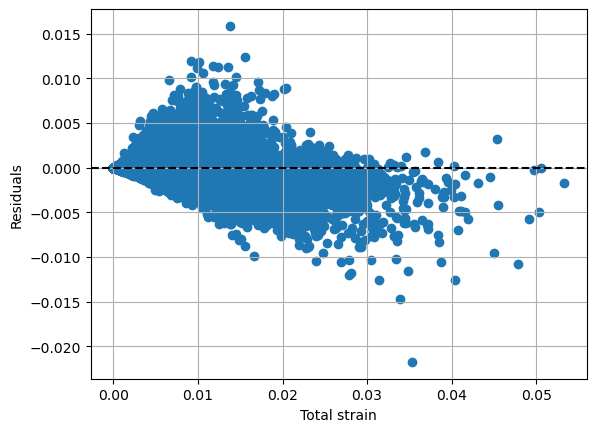

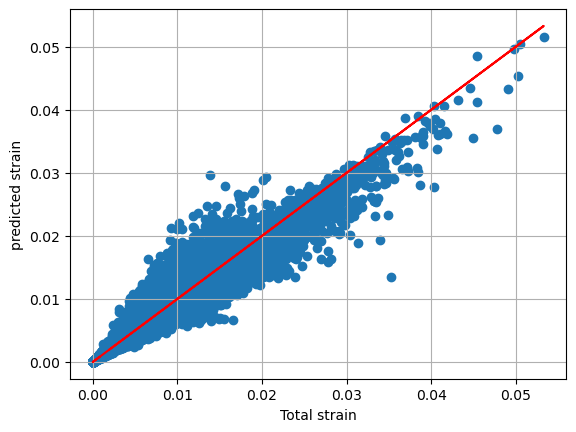

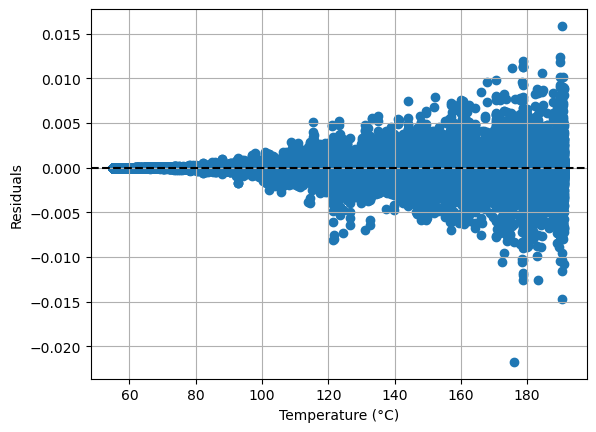

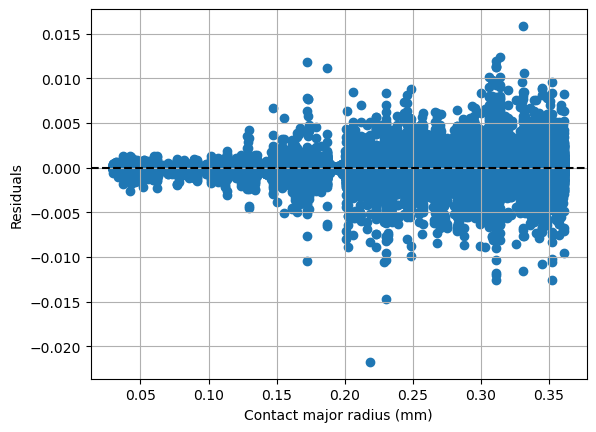

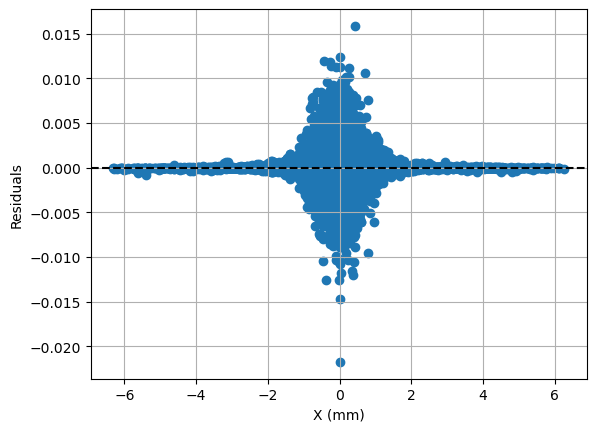

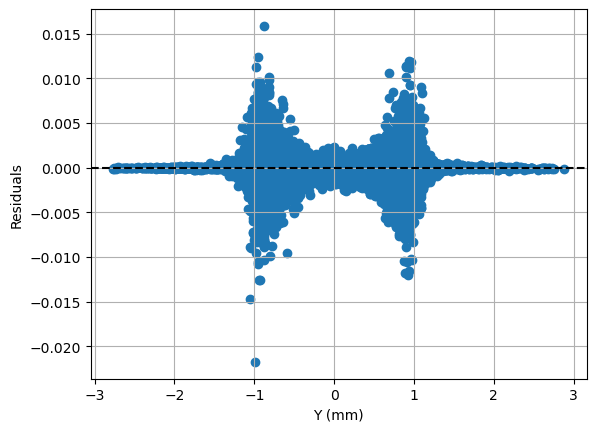

In [53]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

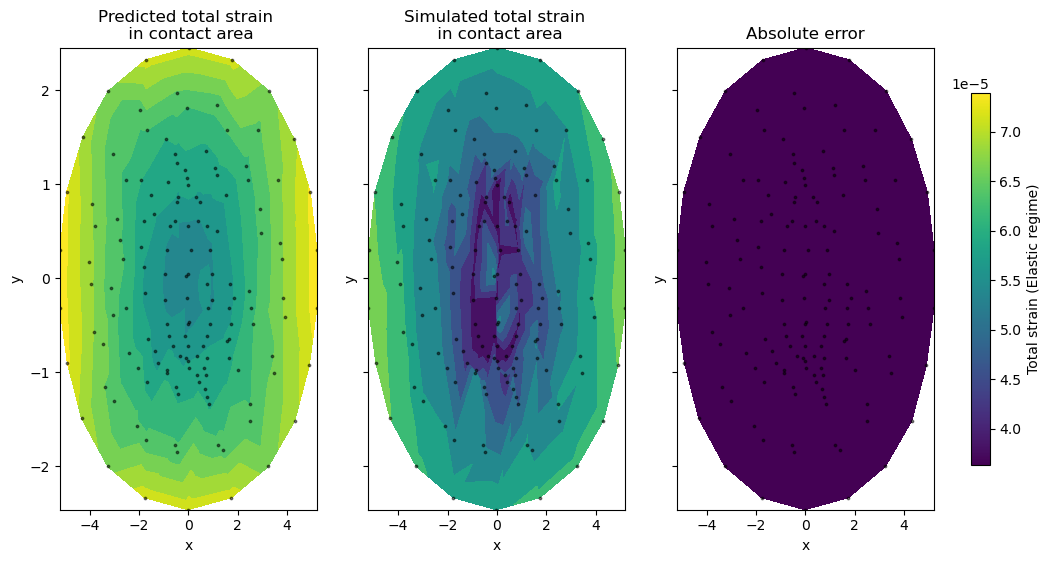

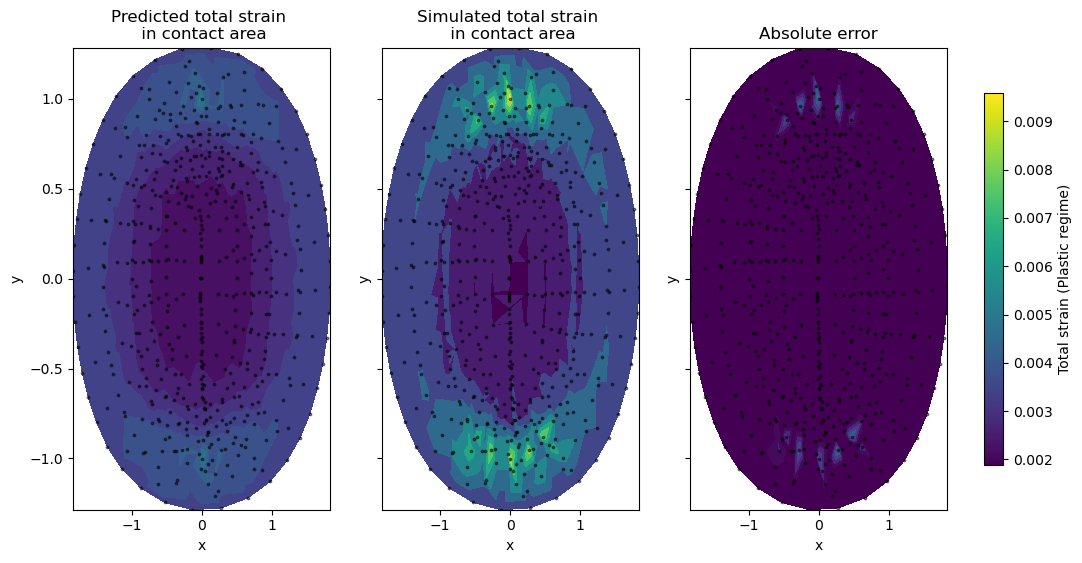

In [54]:
model_name = "Bagging";predictor = Bagging_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# KNN

In [55]:

KNN_model = KNeighborsRegressor(n_neighbors=15)

start_time_fit = time.monotonic()
KNN_model.fit(X_train, y_train)
end_time_fit = time.monotonic()

# Predictions
start_time_predict = time.monotonic()
y_hat = KNN_model.predict(X_test).ravel()
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_KNN = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_KNN = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["KNN",Fitting_time_KNN,Prediction_time_KNN]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



Fitting time is  0.594
Prediction time is  3.812


## Metrics

In [56]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_KNN = metric_MAPE(y_test,y_hat)
MSPE_KNN = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_KNN)
print("MSPE is :", MSPE_KNN)

Metrics_df.loc[-1] =["K-NN",MSE,MAE,R2,Adjusted_R2,MSPE_KNN,MAPE_KNN]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.00040109886606877476
sqrt MSE is :  0.020027452810299537
MAE is :  0.006960839978552196
R2 is :  0.912816870514289
Adjusted R2 is :  0.9128137209200949
MAPE is : 42.11750186492452
MSPE is : 623.0952170056863


## Residuals 

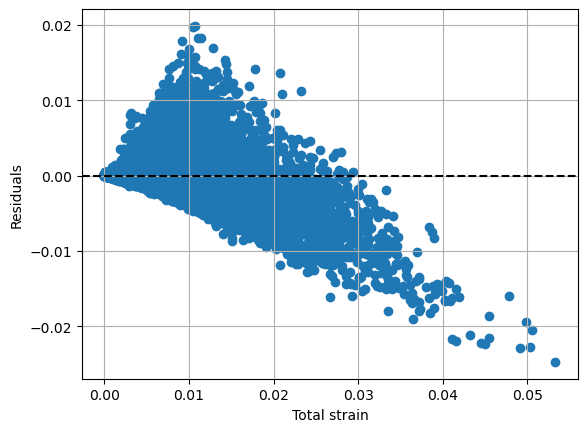

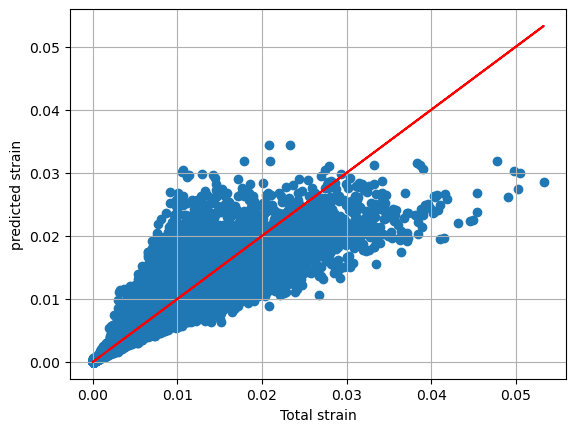

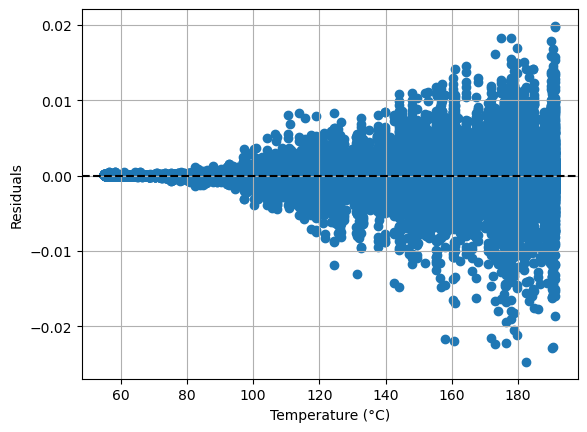

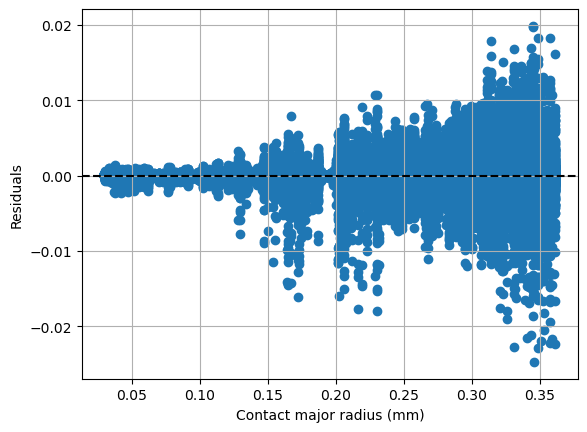

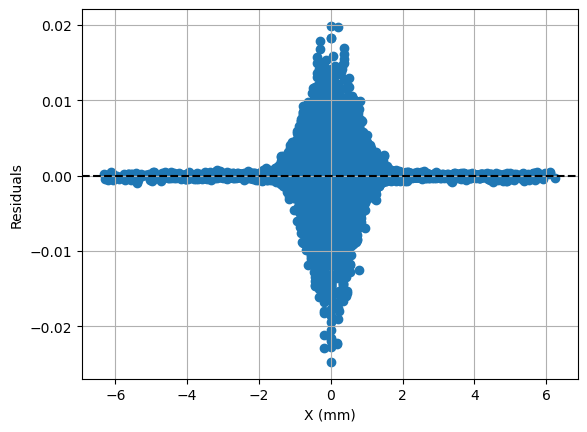

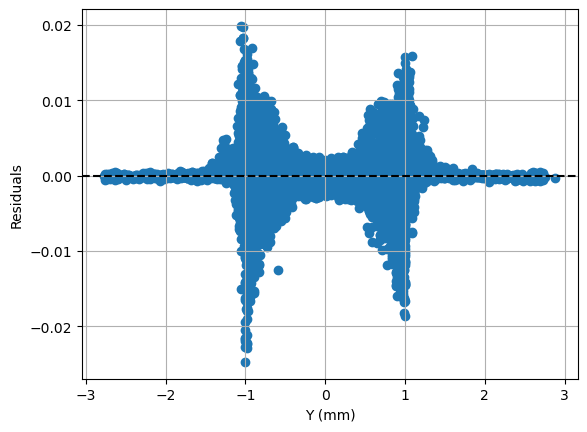

In [57]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

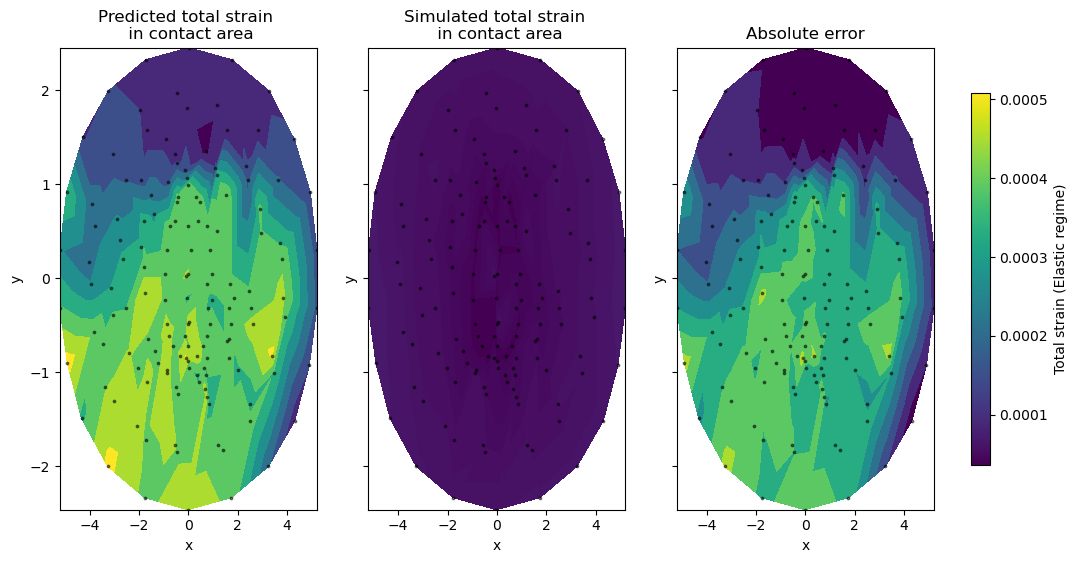

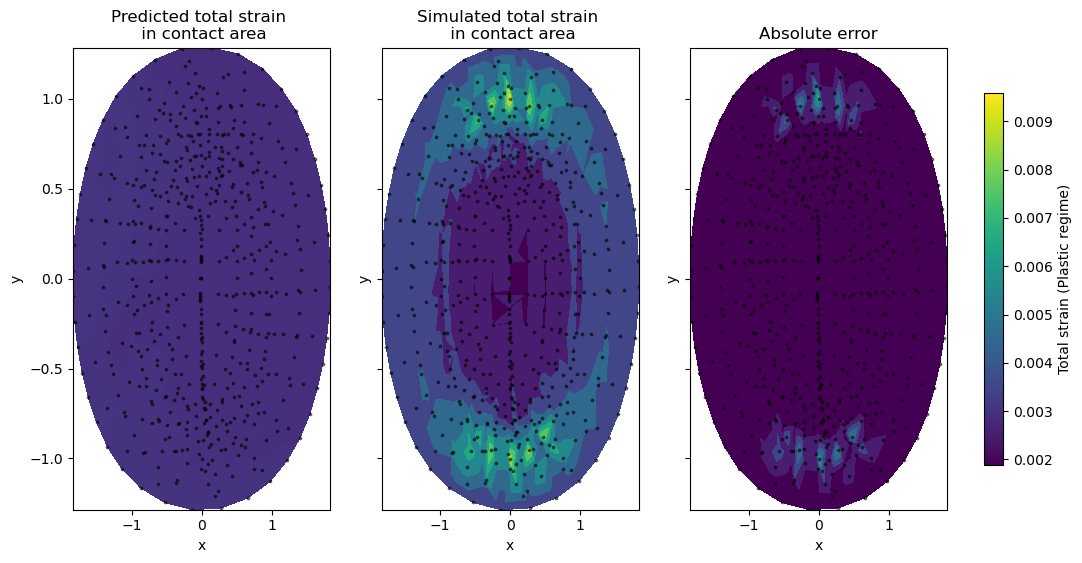

In [58]:
model_name = "KNN";predictor = KNN_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Neural Network

In [59]:
Optimal_learning_rate = 0.00025
NeuralNetwork_model = Sequential()

NeuralNetwork_model.add(Dense(50, input_shape=(X_train.shape[1],),activation="relu"))
NeuralNetwork_model.add(Dense(50, input_shape=50,activation="relu"))
NeuralNetwork_model.add(Dense(50, input_shape=50,activation="relu"))
NeuralNetwork_model.add(Dense(1, input_shape=50,activation="relu"))

optimizer = keras.optimizers.Adam(learning_rate=Optimal_learning_rate)
NeuralNetwork_model.compile(loss='mse',
              optimizer=optimizer)

start_time_fit = time.monotonic()

history = NeuralNetwork_model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_test, y_test))
end_time_fit = time.monotonic()



start_time_predict = time.monotonic()
y_hat = NeuralNetwork_model.predict(X_test).ravel()
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_NeuralNetwork = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_NeuralNetwork = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["NeuralNetwork",Fitting_time_NeuralNetwork,Prediction_time_NeuralNetwork]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



Epoch 1/100


c:\Users\Mehdi-GHRABLI\AppData\Local\anaconda3\envs\SurrogateAI\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10381/10381 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 6.4433e-04 - val_loss: 5.4058e-04
Epoch 2/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 5.3181e-04 - val_loss: 5.0252e-04
Epoch 3/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.9330e-04 - val_loss: 5.1003e-04
Epoch 4/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.7393e-04 - val_loss: 4.5288e-04
Epoch 5/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 4.5924e-04 - val_loss: 4.7097e-04
Epoch 6/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.5189e-04 - val_loss: 4.5007e-04
Epoch 7/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 997us/step - loss: 4.4000e-04 - val_loss: 4.3677e-04
Epoch 8/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.3795e-04 - val_loss: 4.8087e-04
Epoch 9/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 4.2925e-04 - val_loss: 3.9873e-04
Epoch 10/100
10381/10381 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 4.2101e-04 - val_loss: 4.3728e-04
Epoch 11/

## Metrics

In [60]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_NeuralNet = metric_MAPE(y_test,y_hat)
MSPE_NeuralNet = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_NeuralNet)
print("MSPE is :", MSPE_NeuralNet)

Metrics_df.loc[-1] =["Neural Network",MSE,MAE,R2,Adjusted_R2,MSPE_NeuralNet,MAPE_NeuralNet]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.000270777555329799
sqrt MSE is :  0.01645531997044722
MAE is :  0.006717874878787256
R2 is :  0.9411436015775364
Adjusted R2 is :  0.9411414753201762
MAPE is : 36.854207631675706
MSPE is : 28.066300783150734


## Residuals 

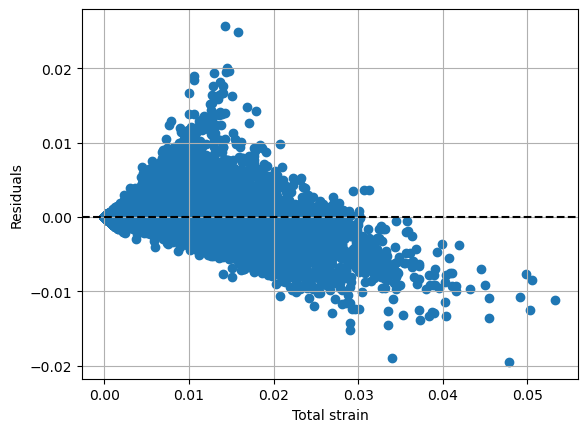

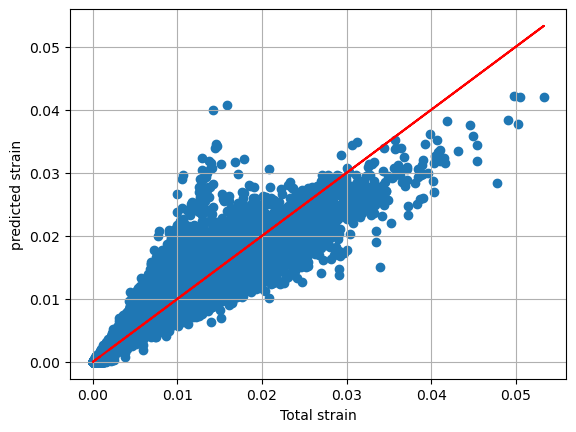

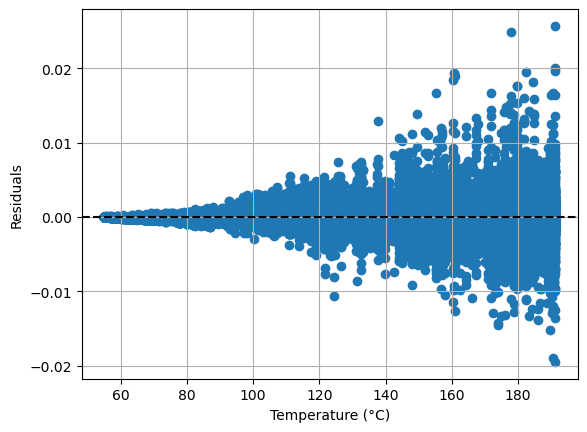

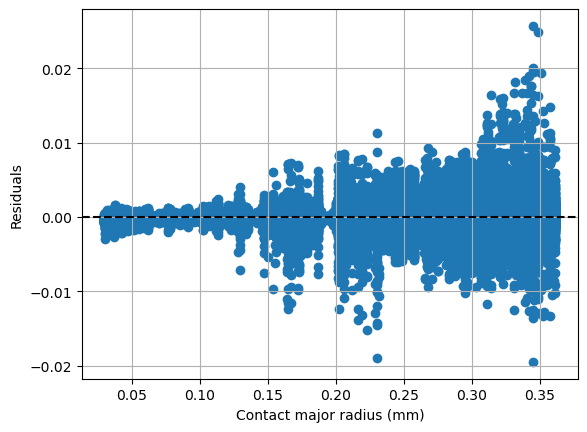

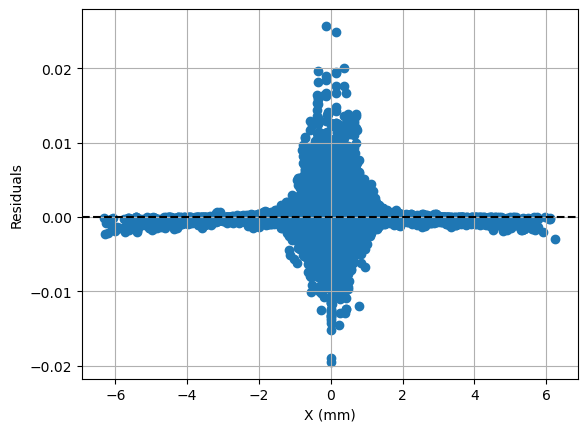

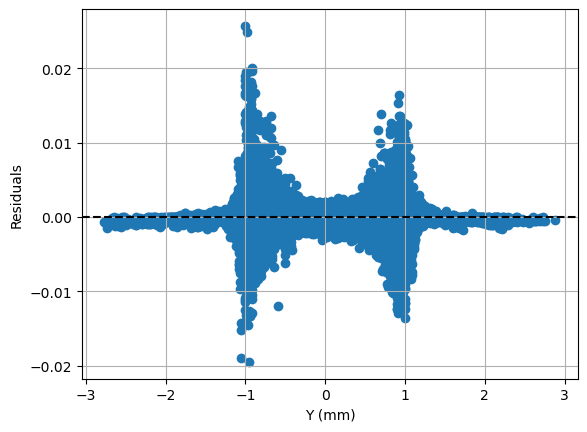

In [61]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


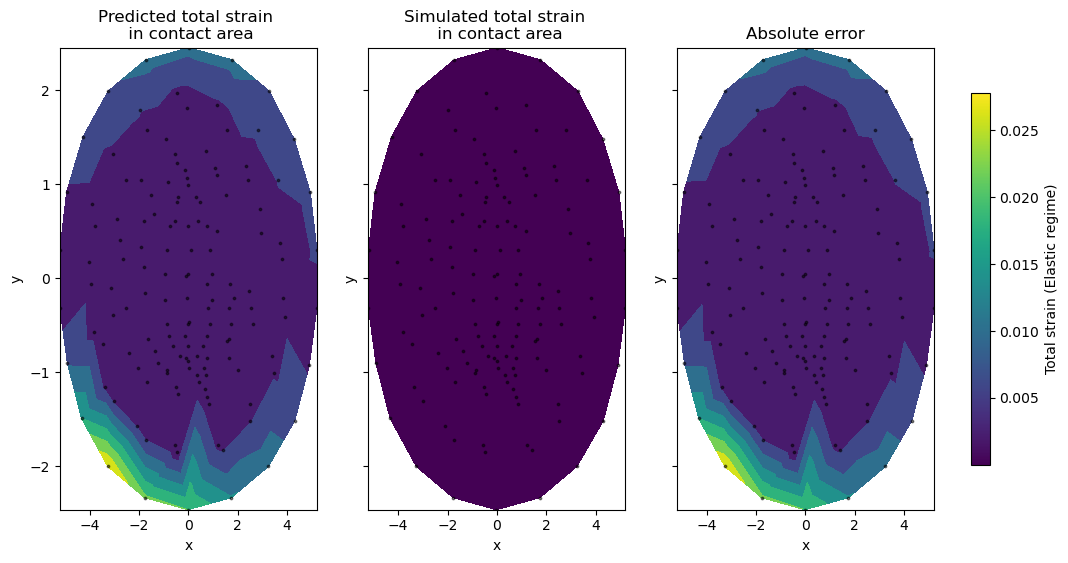

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step


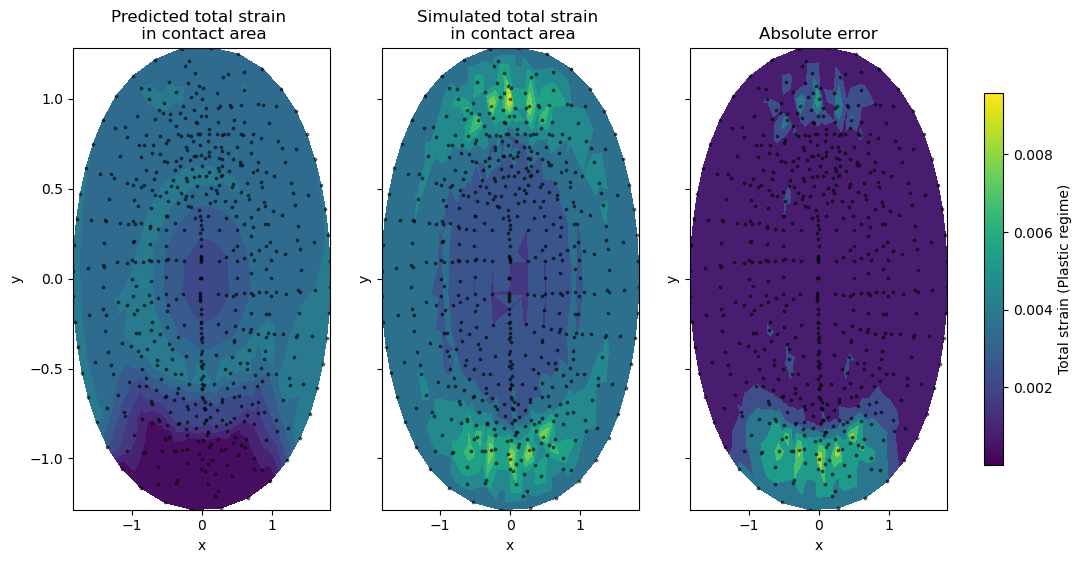

In [62]:
model_name = "Neural Network";predictor = NeuralNetwork_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Support Vector Regression

In [63]:
C_svr = 1
Gamma_svr = 1
SVR_model = SVR(kernel='rbf',C=C_svr, gamma=Gamma_svr) 
start_time_fit =time.monotonic()
SVR_model.fit(X_train, y_train.ravel()) 
end_time_fit =time.monotonic()


# Predictions
start_time_predict = time.monotonic()
y_hat = SVR_model.predict(X_test) 
end_time_predict = time.monotonic()

print("Fitting time is " , timedelta(seconds=end_time_fit - start_time_fit).total_seconds())
Fitting_time_SVR = timedelta(seconds=end_time_fit - start_time_fit).total_seconds()

print("Prediction time is " , timedelta(seconds = end_time_predict - start_time_predict).total_seconds())
Prediction_time_SVR = timedelta(seconds = end_time_predict - start_time_predict).total_seconds()

Time_df.loc[-1] =["SVR",Fitting_time_SVR,Prediction_time_SVR]# adding a row
Time_df.index = Time_df.index + 1  # shifting index
Time_df = Time_df.sort_index()  # sorting by index



Fitting time is  3522.187
Prediction time is  26.266


## Metrics

In [64]:
MSE = metric_MSE(y_test,y_hat)
MAE = metric_MAE(y_test,y_hat)
R2 = metric_R2(y_test,y_hat)
Adjusted_R2 = metric_adjusted_R2(y_test,y_hat,len(y_train),X_train.shape[1])
MAPE_SVR = metric_MAPE(y_test,y_hat)
MSPE_SVR = metric_MSPE(y_test,y_hat)
print("MSE is : ",MSE)
print("sqrt MSE is : ",np.sqrt(MSE))
print("MAE is : ",MAE)
print("R2 is : ",R2)
print("Adjusted R2 is : ",Adjusted_R2)
print("MAPE is :", MAPE_SVR)
print("MSPE is :", MSPE_SVR)

Metrics_df.loc[-1] =["Support vector Regression",MSE,MAE,R2,Adjusted_R2,MSPE_SVR,MAPE_SVR]# adding a row
Metrics_df.index = Metrics_df.index + 1  # shifting index
Metrics_df = Metrics_df.sort_index()  # sorting by index

MSE is :  0.001835246270687586
sqrt MSE is :  0.042839774400521606
MAE is :  0.035164316319362045
R2 is :  0.6010895896472336
Adjusted R2 is :  0.6010751785344439
MAPE is : 2607.1252454933333
MSPE is : 9287919.53928696


## Residuals 

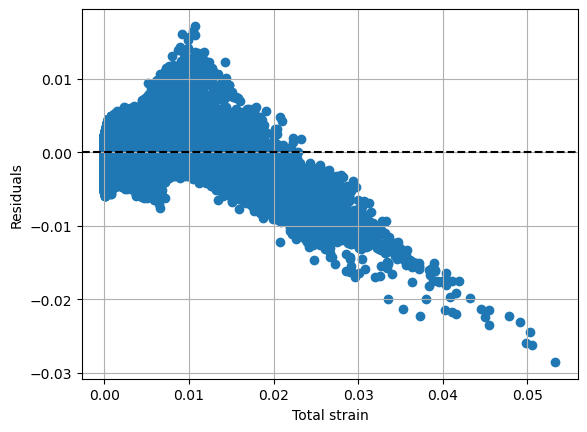

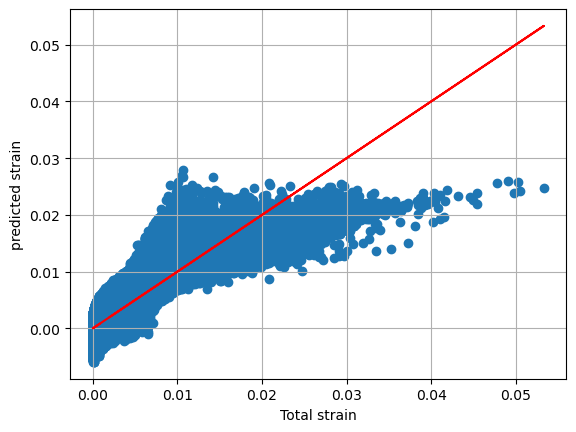

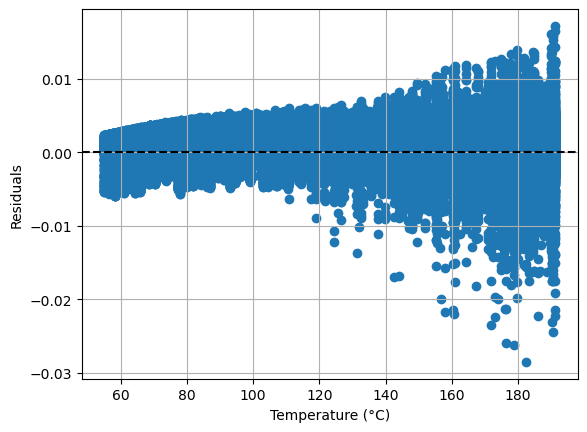

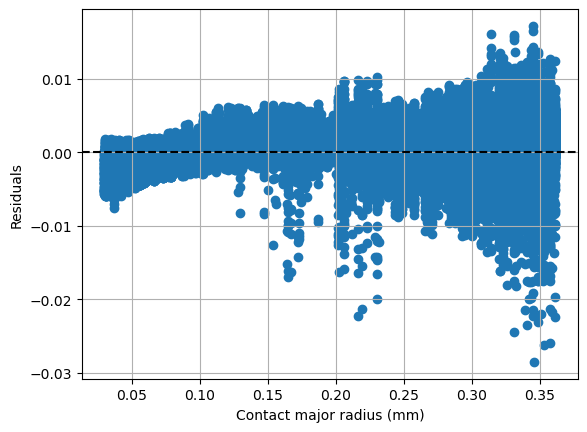

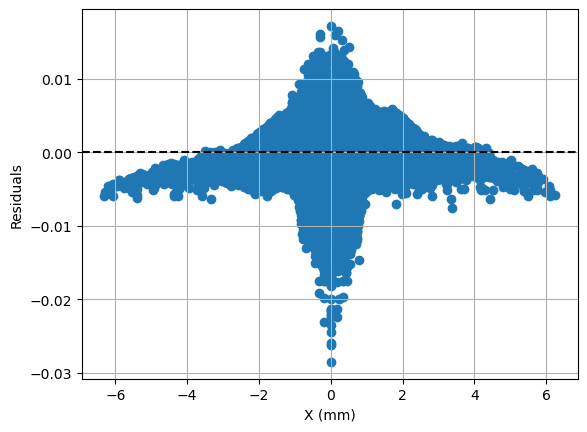

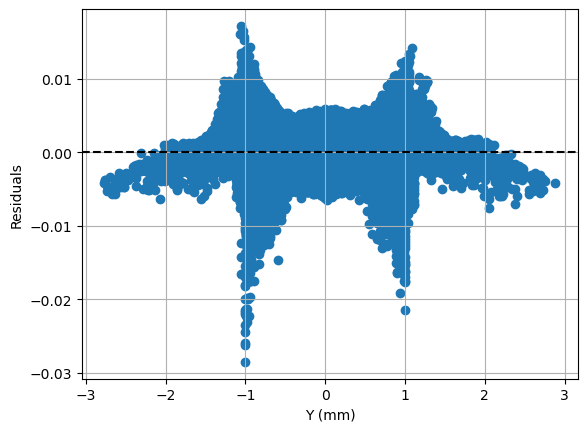

In [65]:
plot_residuals(X_test,y_hat,y_test,local_contact_data,Residual_variable_names,Output_names)

## Plots

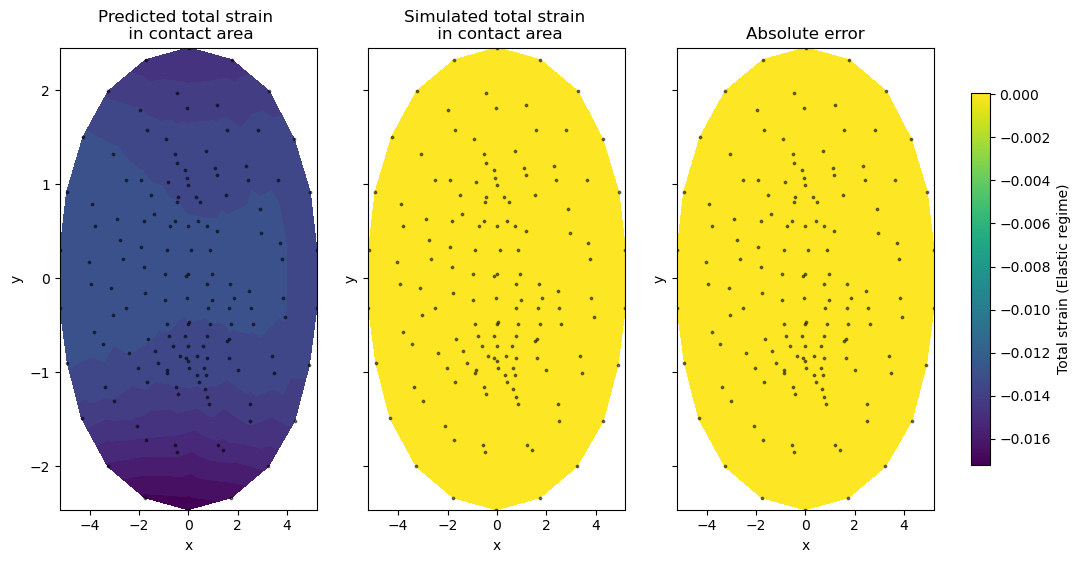

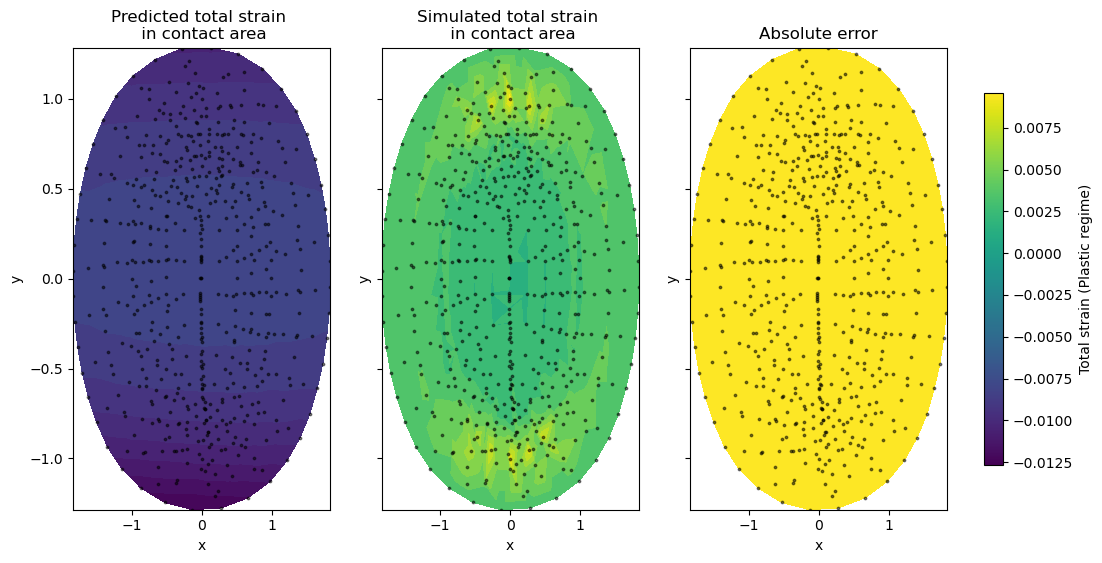

In [66]:
model_name = "SVR";predictor = SVR_model;des_lin = poly
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=0)
plot_example(Test_data_to_plot,local_contact_data,Input_names,model_name,predictor,des_lin,Epsilon_plasticity,index_data=1)

# Final Resutls and comparisons

In [67]:
Time_df["Prediction time per point"] = Time_df["Prediction time"]/len(y_test)

In [68]:
Metrics_df

Model       MSE       MAE        R2    Adj_R2  \
0   Support vector Regression  0.001835  0.035164  0.601090  0.601075   
1              Neural Network  0.000271  0.006718  0.941144  0.941141   
2                        K-NN  0.000401  0.006961  0.912817  0.912814   
3                     Bagging  0.000122  0.003877  0.973589  0.973588   
4                    Boosting  0.000293  0.007013  0.936285  0.936283   
5               Random Forest  0.000124  0.003961  0.972966  0.972965   
6               Decision Tree  0.000390  0.007447  0.915285  0.915282   
7       Polynomial Regression  0.000522  0.009878  0.886473  0.886469   
8                  ElasticNet  0.001541  0.022229  0.665058  0.665046   
9                       Ridge  0.001541  0.022228  0.665059  0.665047   
10                      LASSO  0.001541  0.022227  0.665056  0.665044   
11                     Linear  0.001541  0.022232  0.665059  0.665047   

            MSPE         MAPE  
0   9.287920e+06  2607.125245  
1   2.806630e+01    36.854208  
2   6.230952e+02    42.117502  
3   9.755231e-01     6.142851  
4   3.493163e+03    91.014471  
5   9.901601e-01     6.218763  
6   4.363896e+00    12.802325  
7   5.179508e+04   342.721964  
8   1.105488e+06  1582.890563  
9   1.106694e+06  1583.071852  
10  1.103797e+06  1582.031865  
11  1.108020e+06  1583.994146

In [69]:
Time_df

Model  Fitting time  Prediction time  Prediction time per point
0             SVR      3522.187           26.266               1.844989e-04
1   NeuralNetwork      1070.734            2.610               1.833329e-05
2             KNN         0.594            3.812               2.677643e-05
3         Bagging      1884.016           23.515               1.651752e-04
4        Boosting       181.266            0.109               7.656430e-07
5    RandomForest      1614.656           23.312               1.637493e-04
6   Decision Tree         2.938            0.015               1.053637e-07
7            Poly        43.437            4.954               3.479812e-05
8      ElasticNet        90.750            0.016               1.123880e-07
9           Ridge         2.562            0.000               0.000000e+00
10          LASSO         3.156            0.016               1.123880e-07
11         Linear         0.063            0.016               1.123880e-07

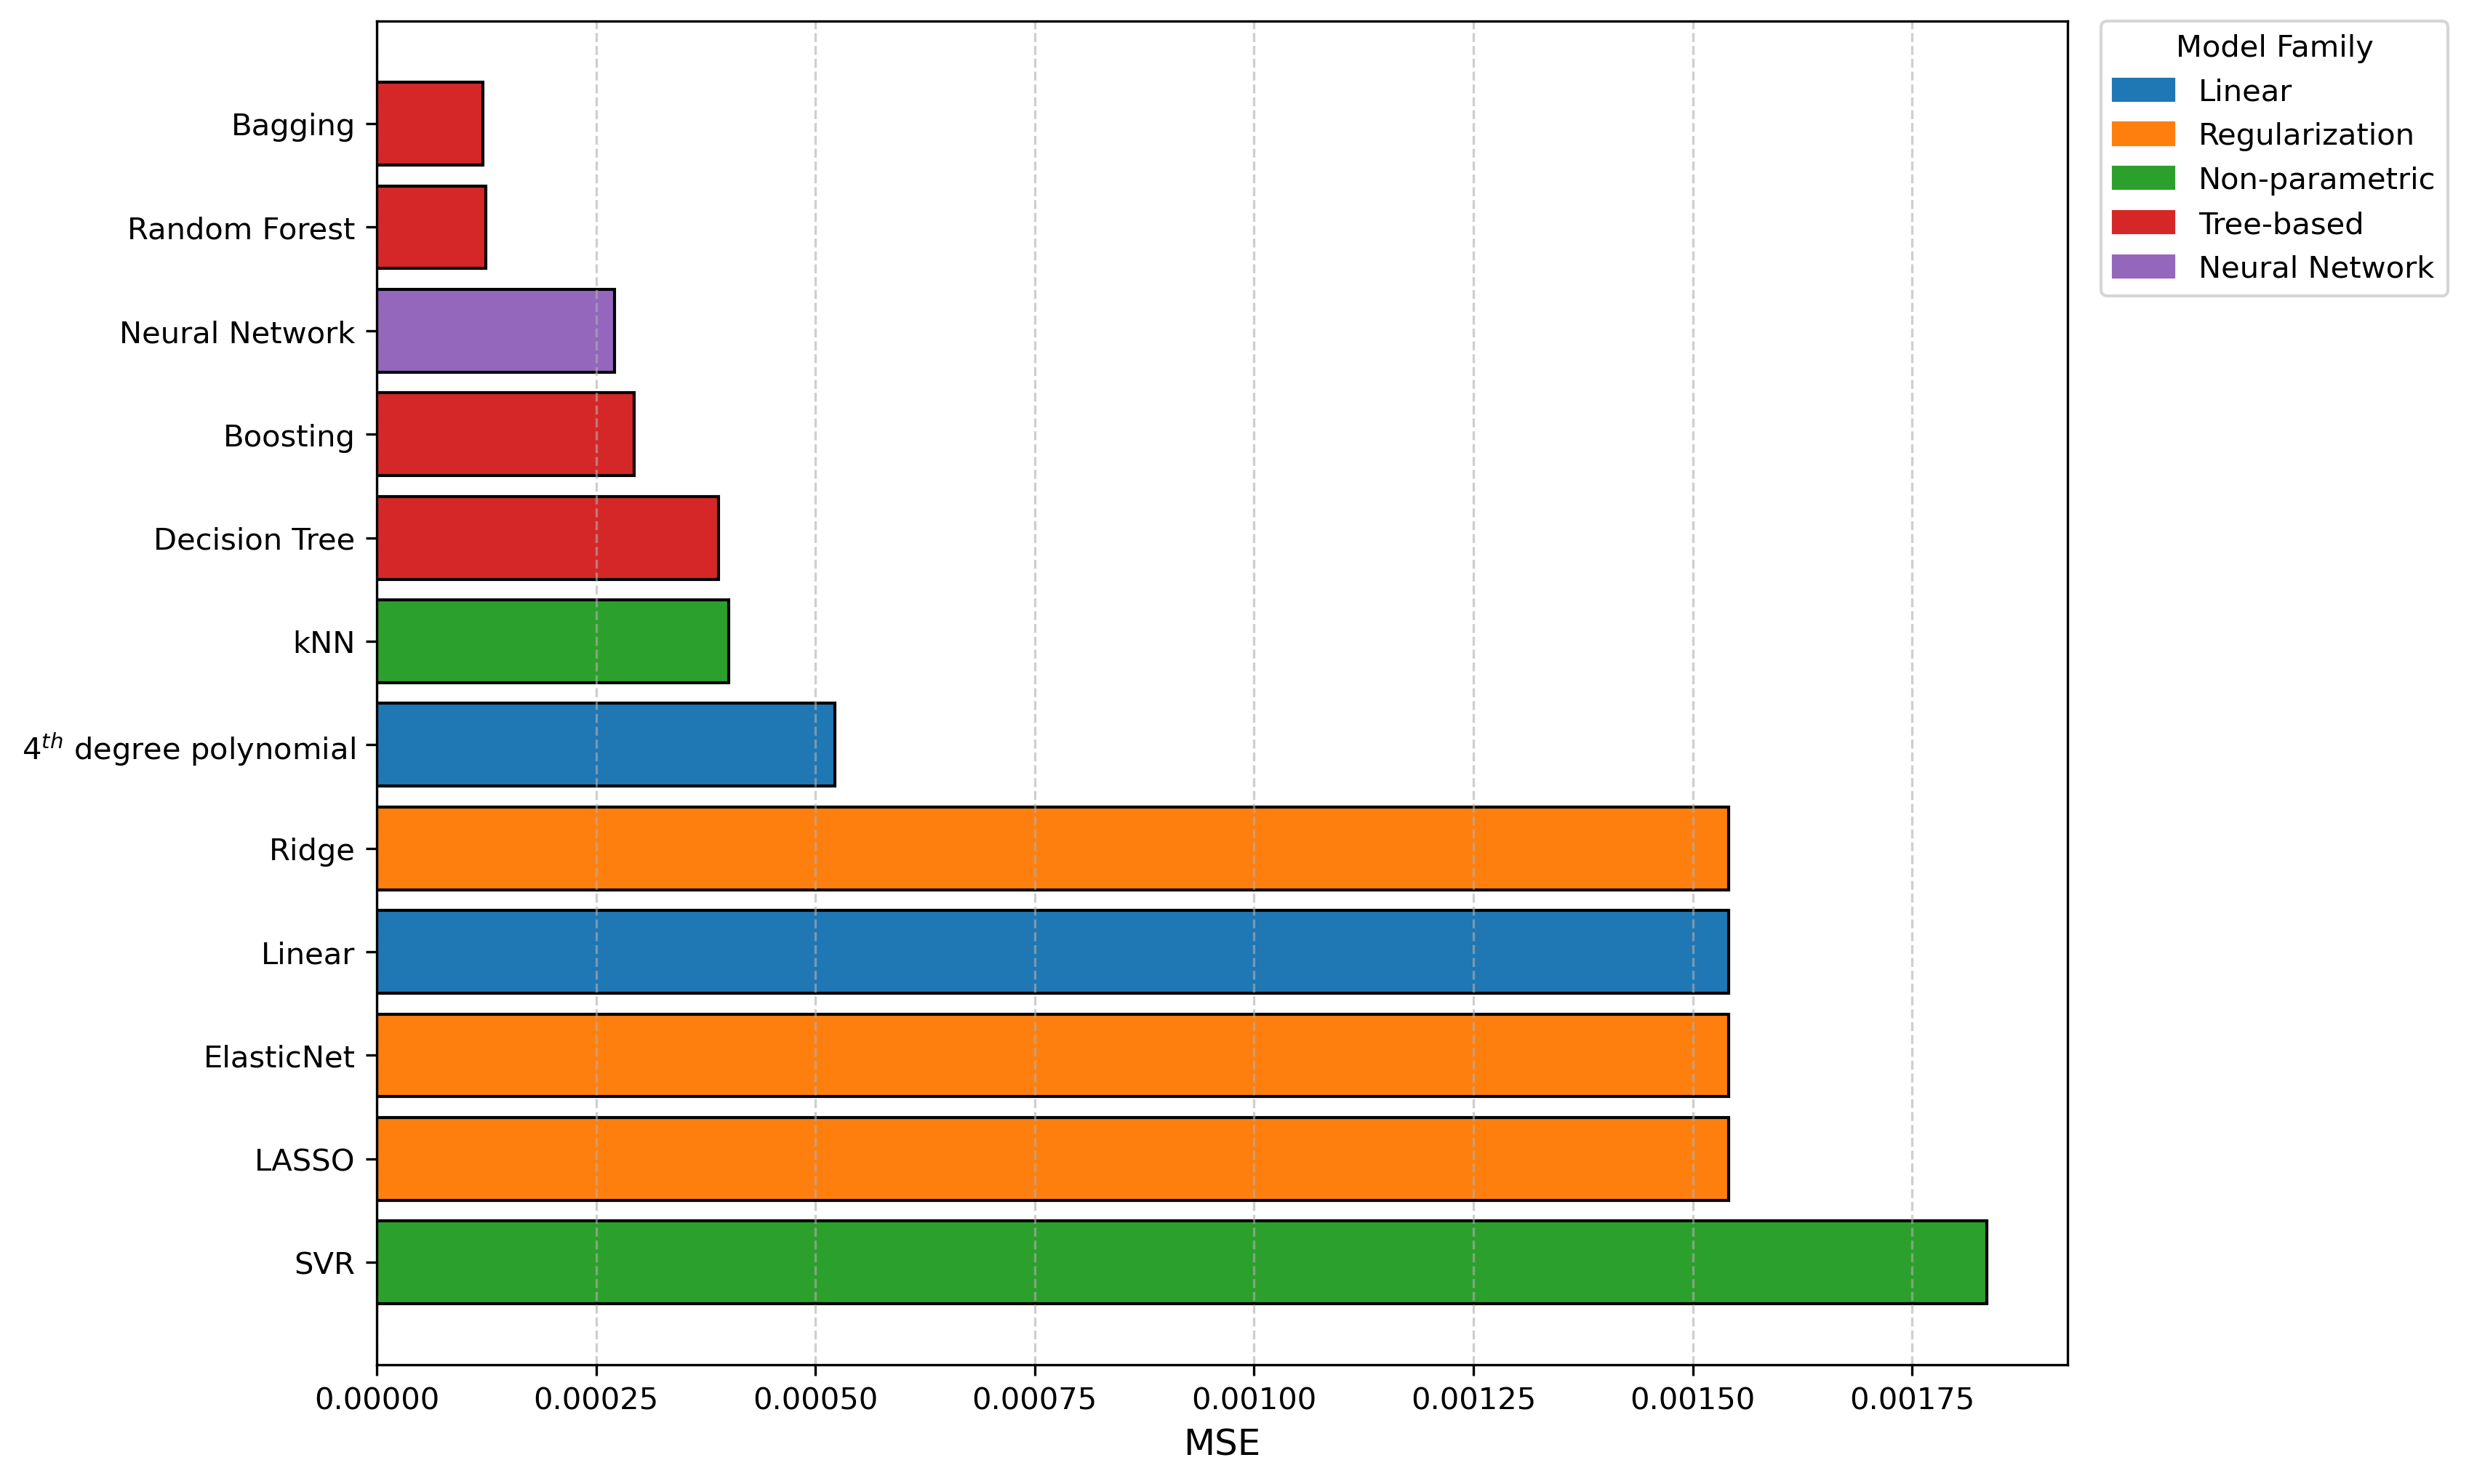

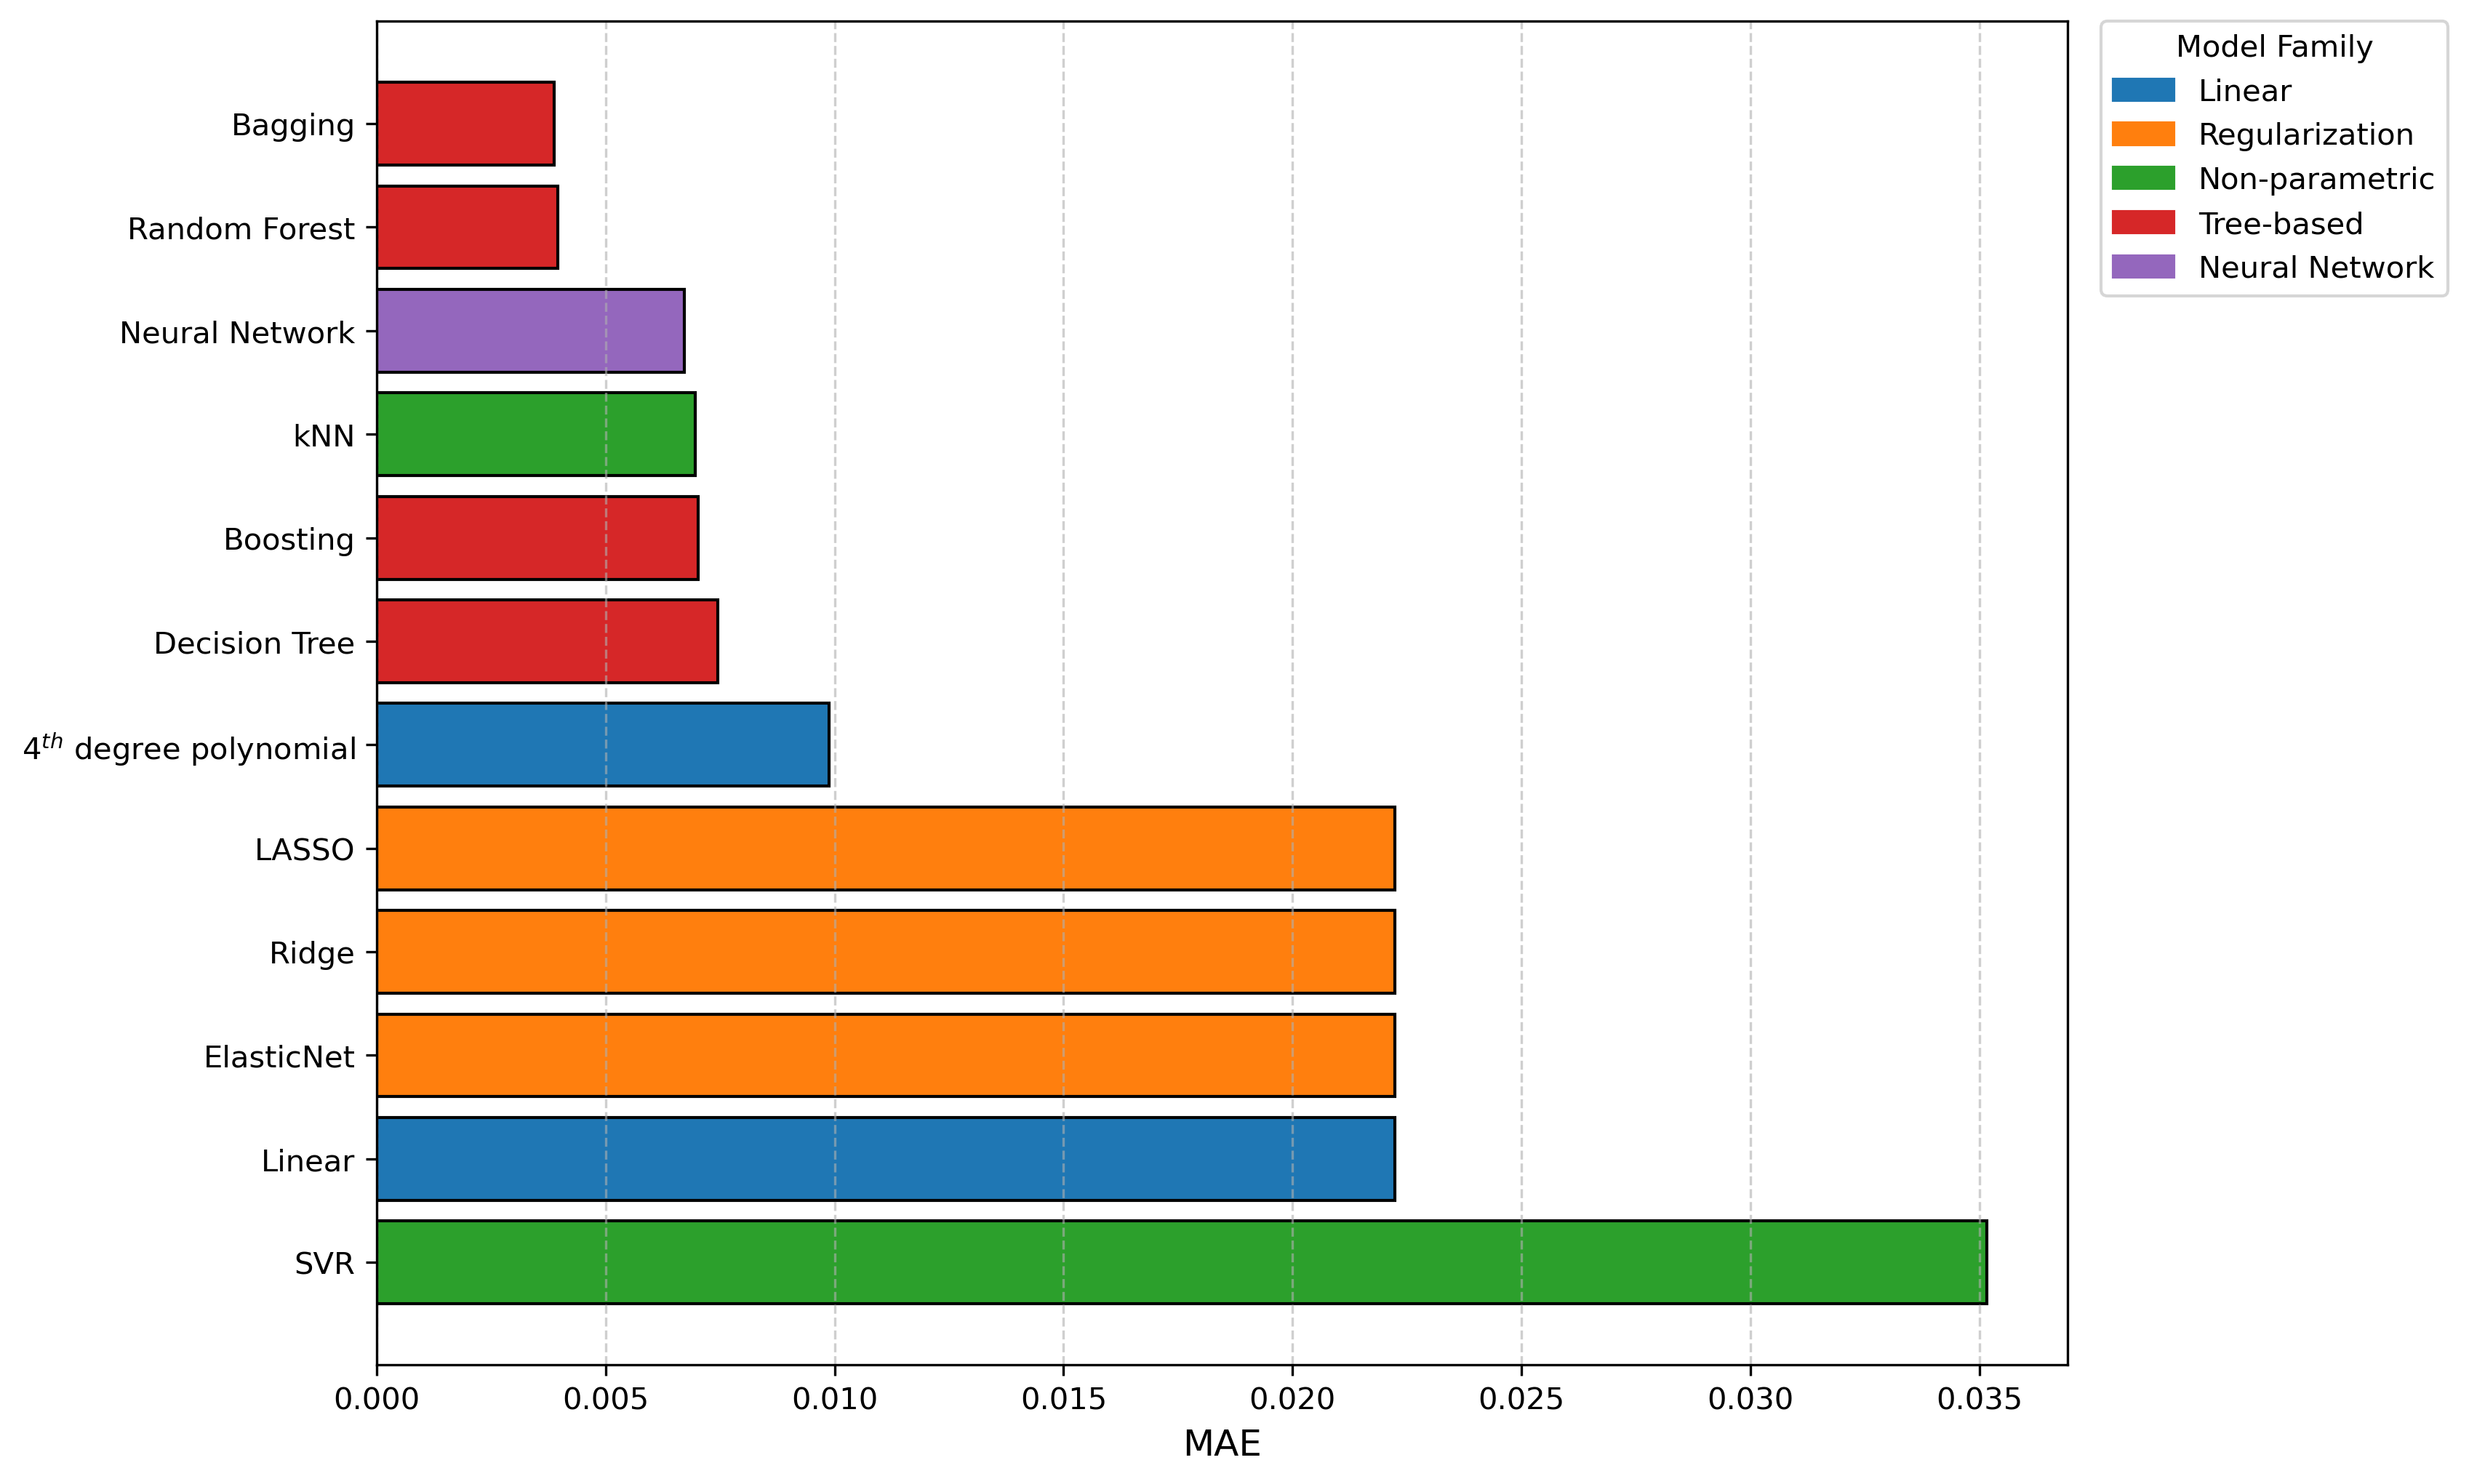

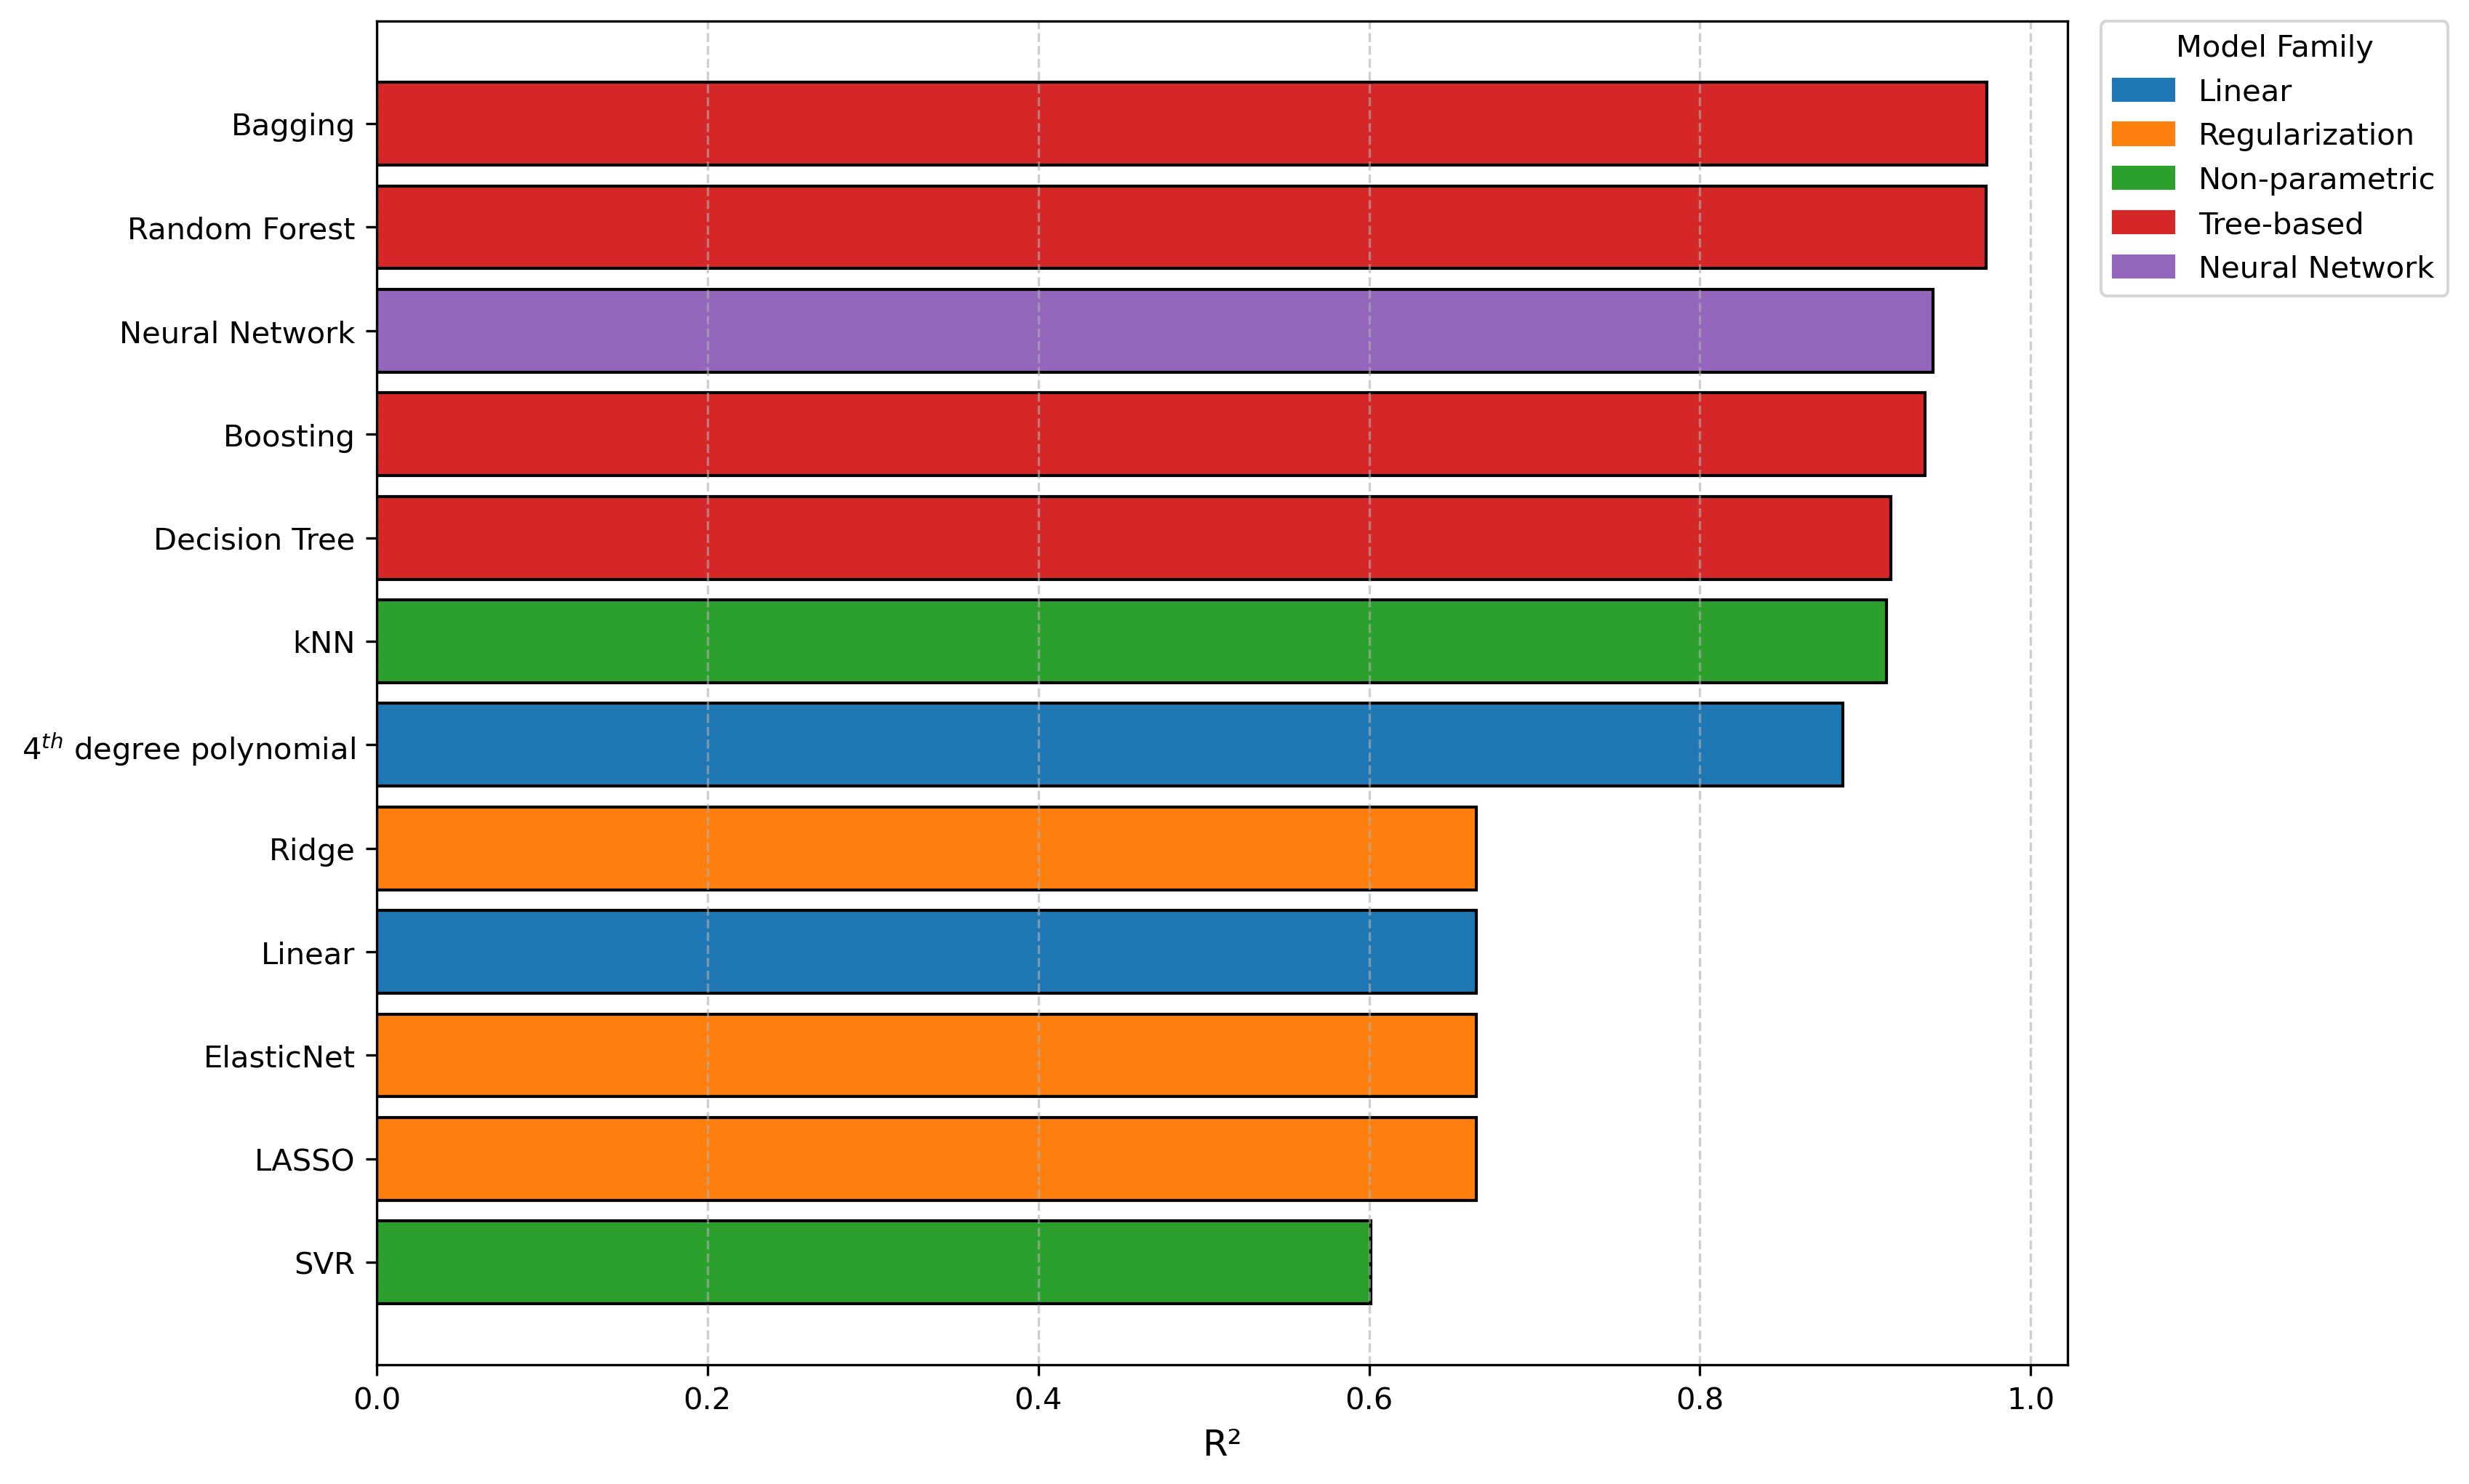

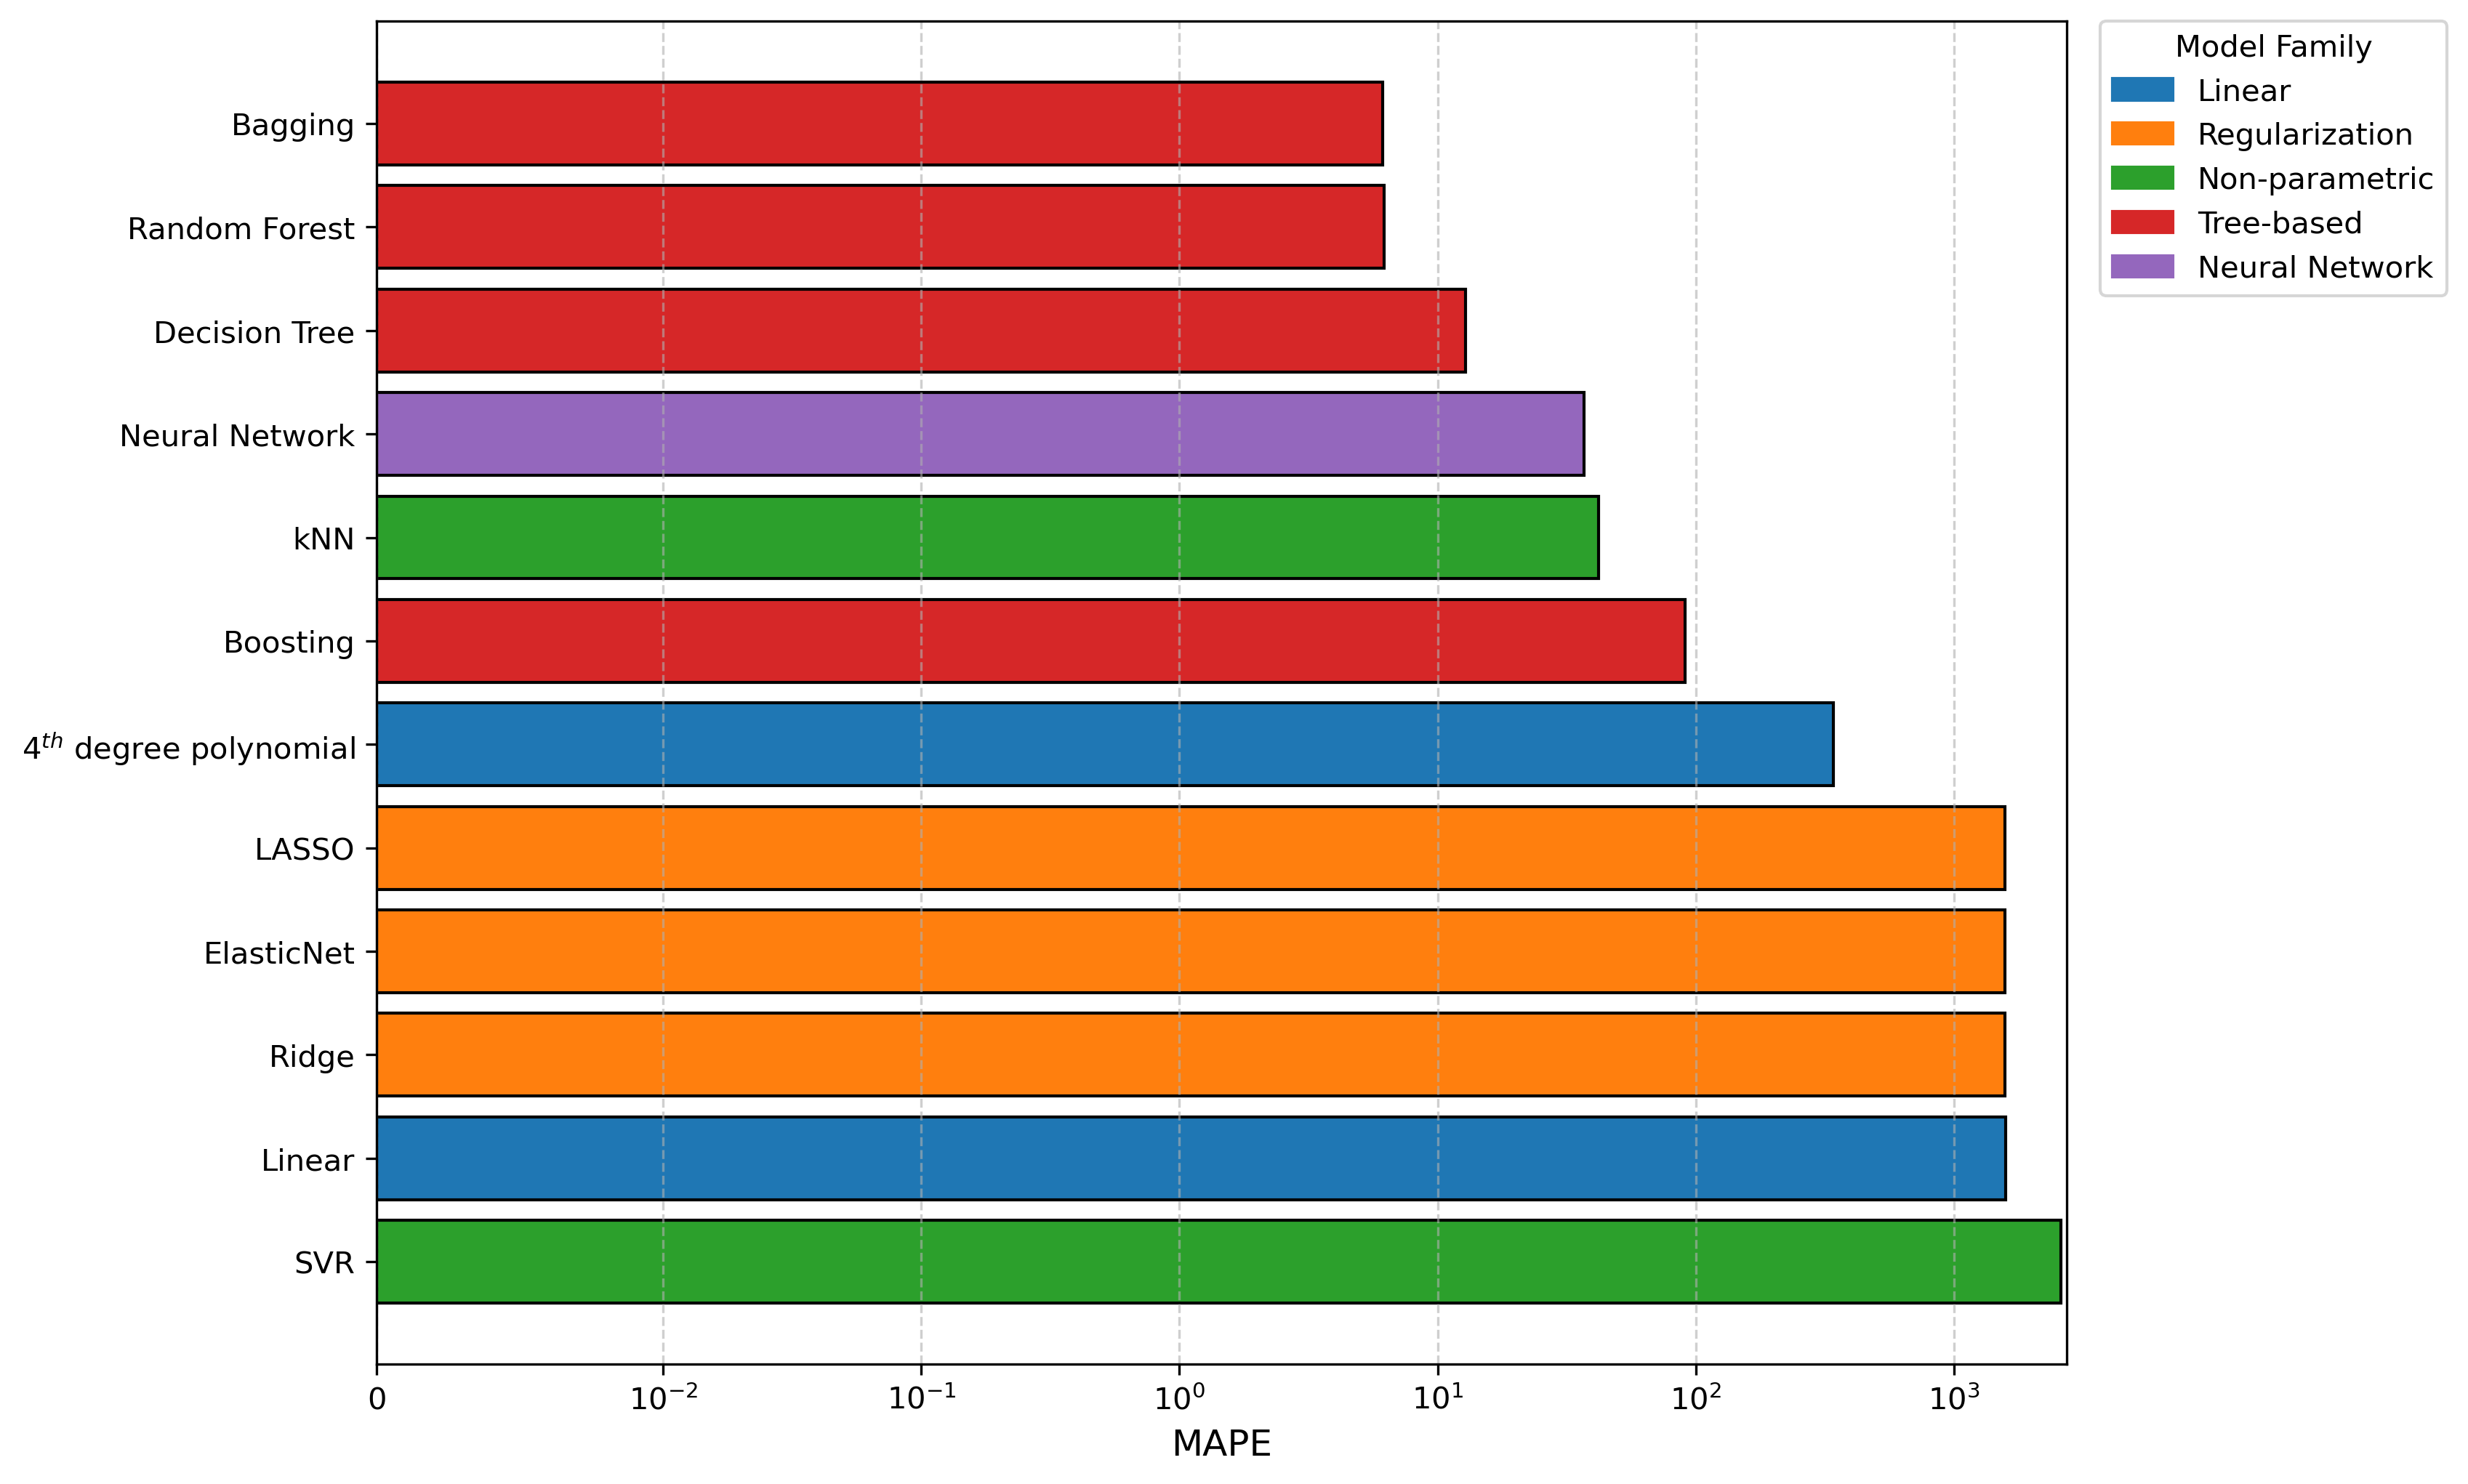

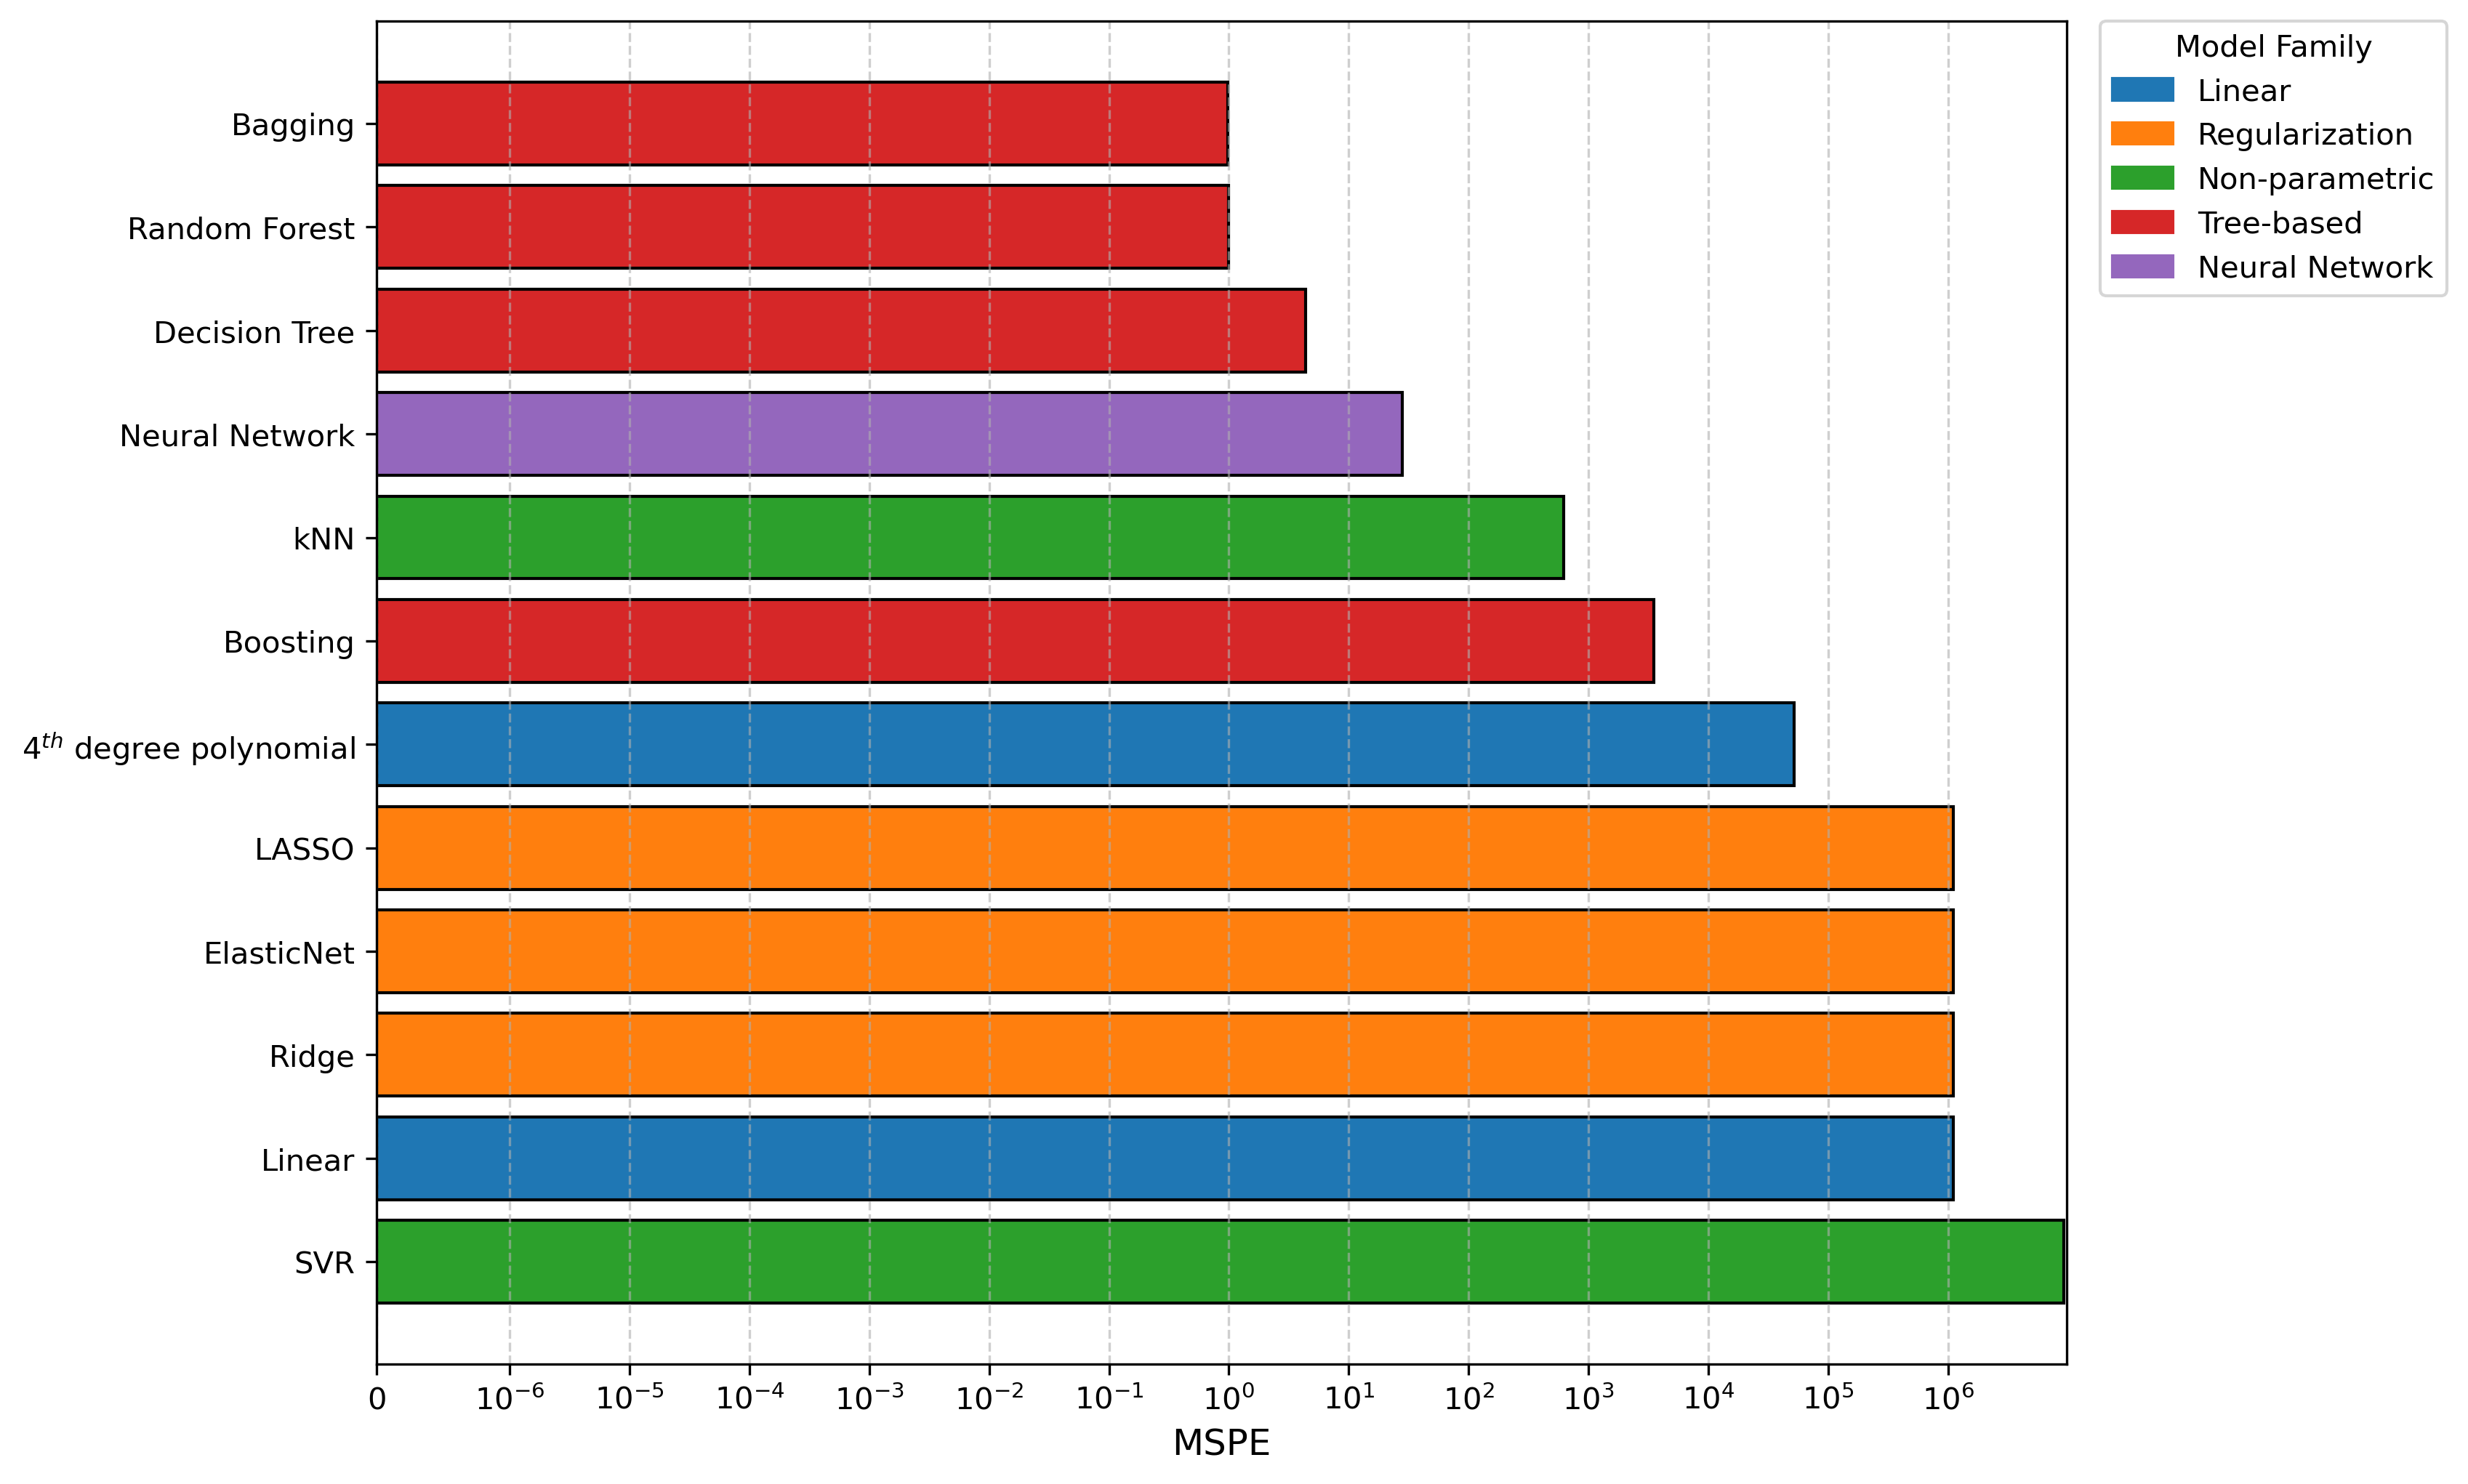

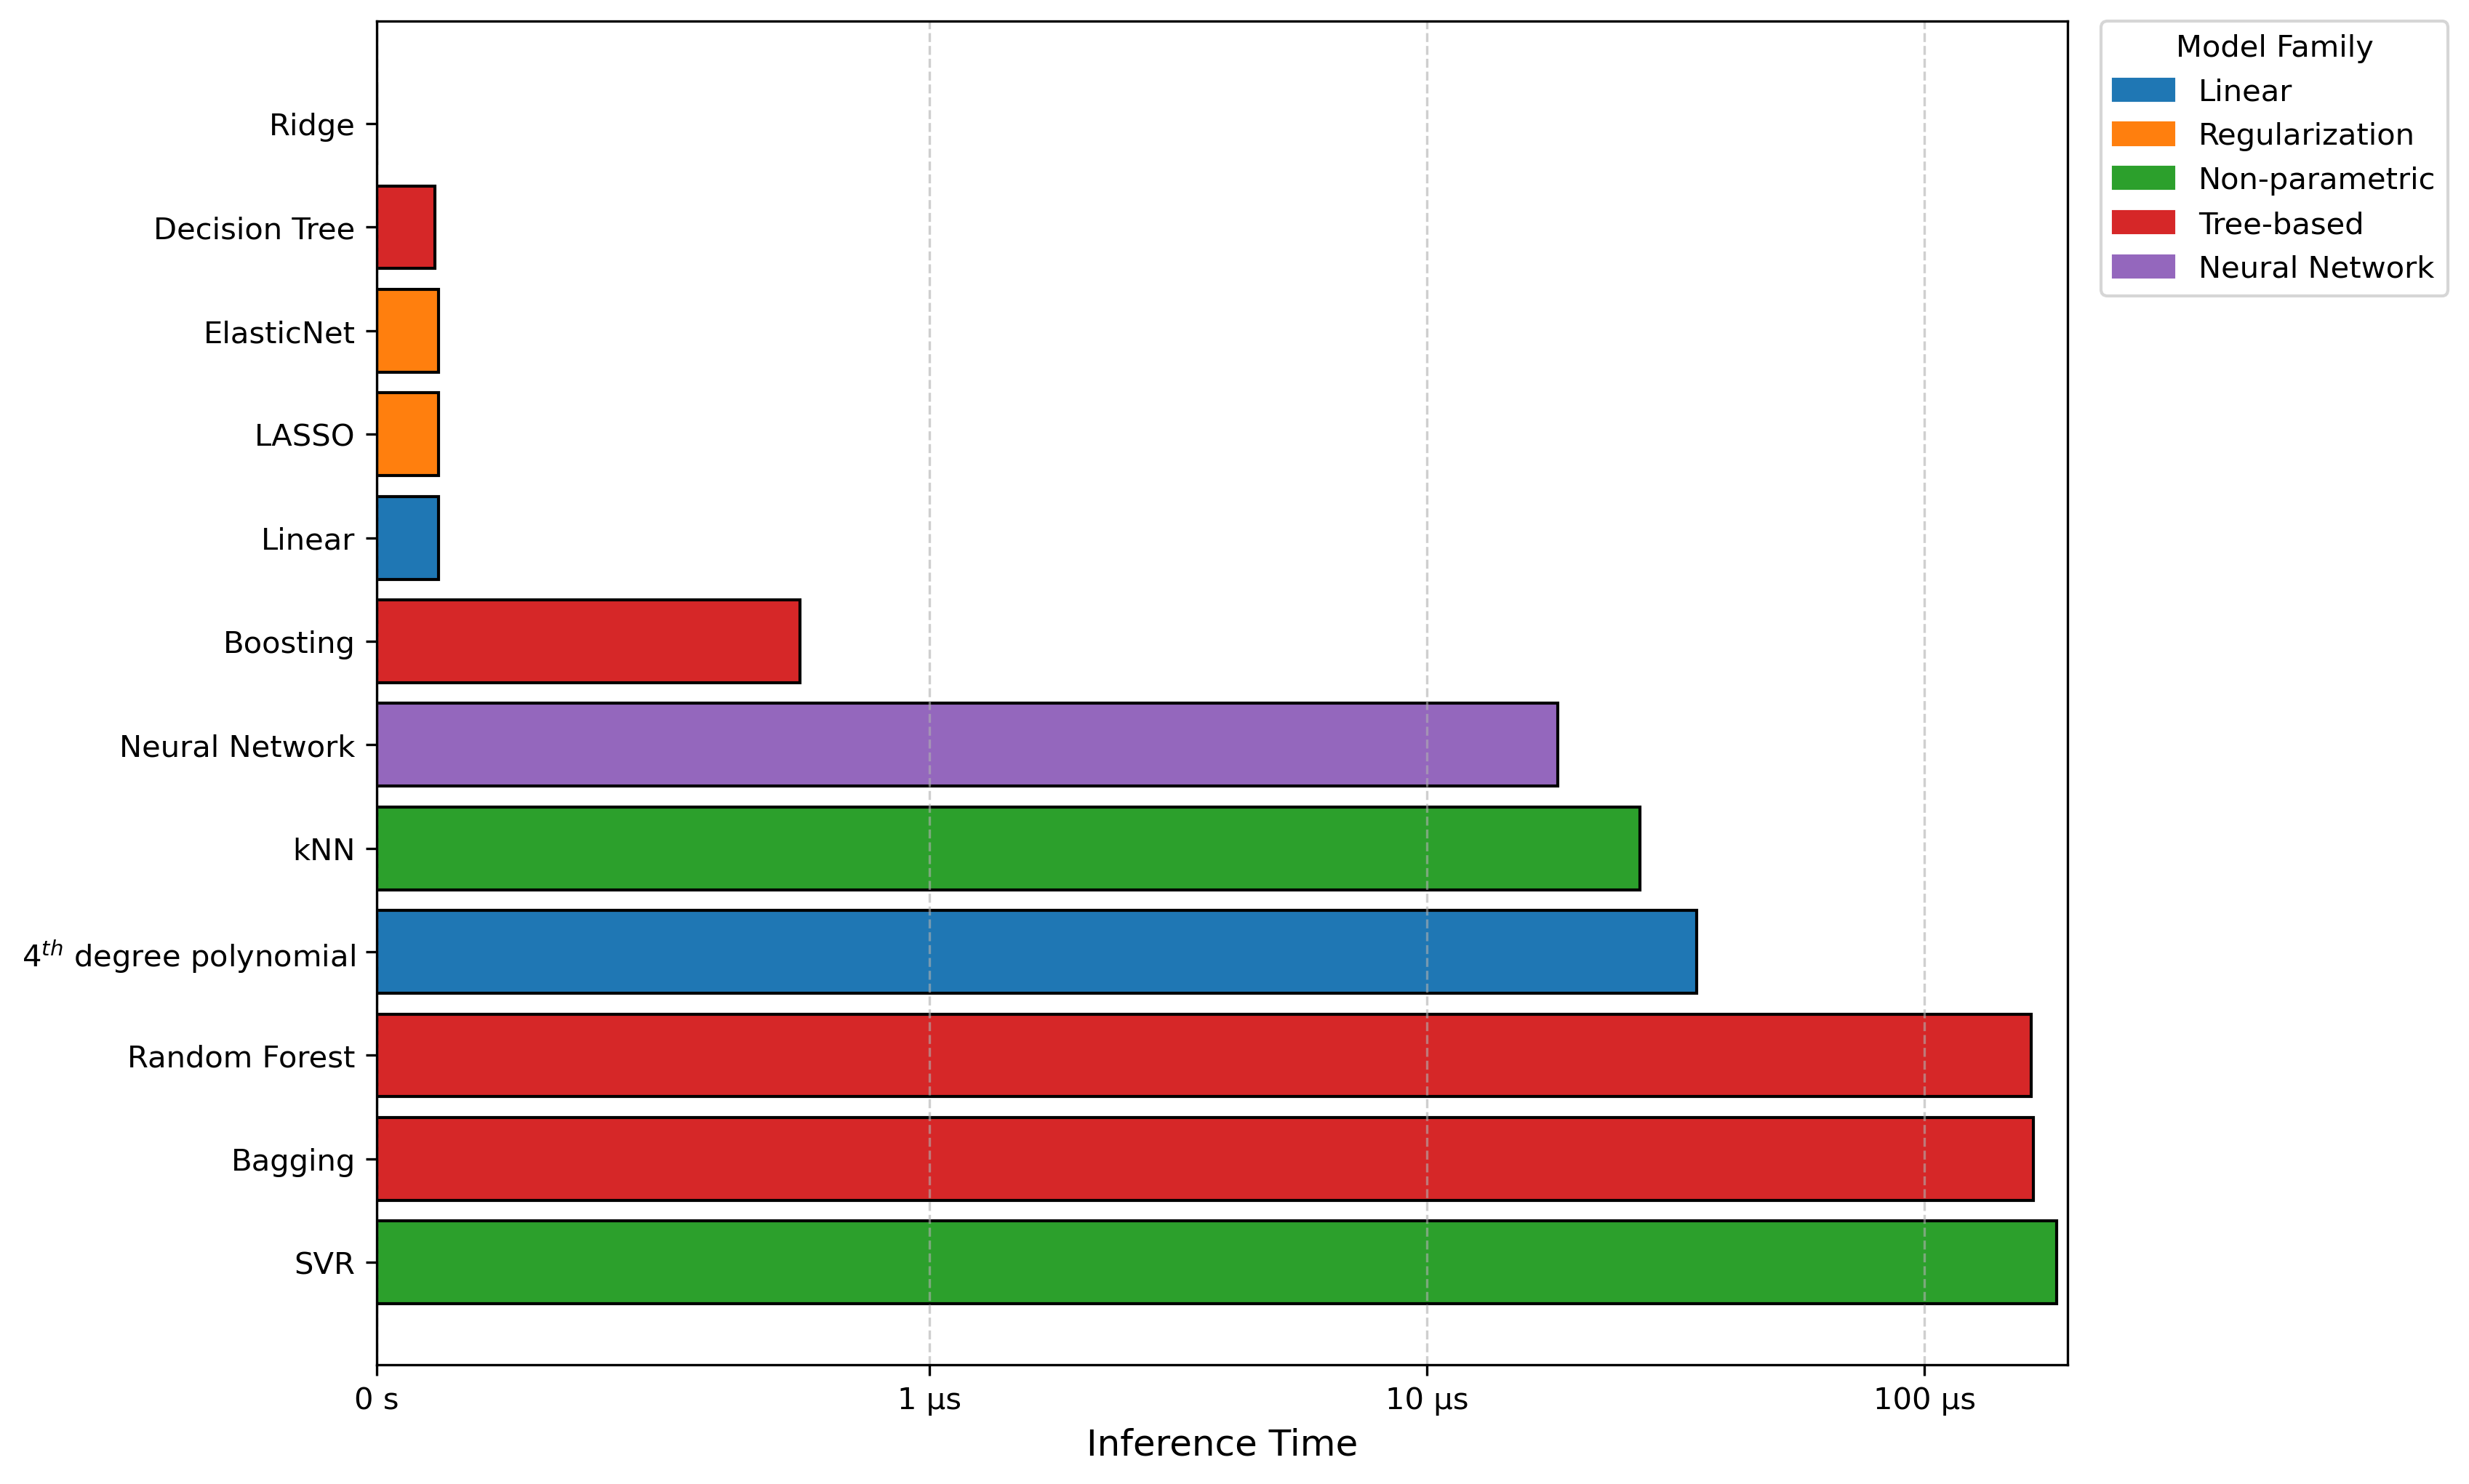

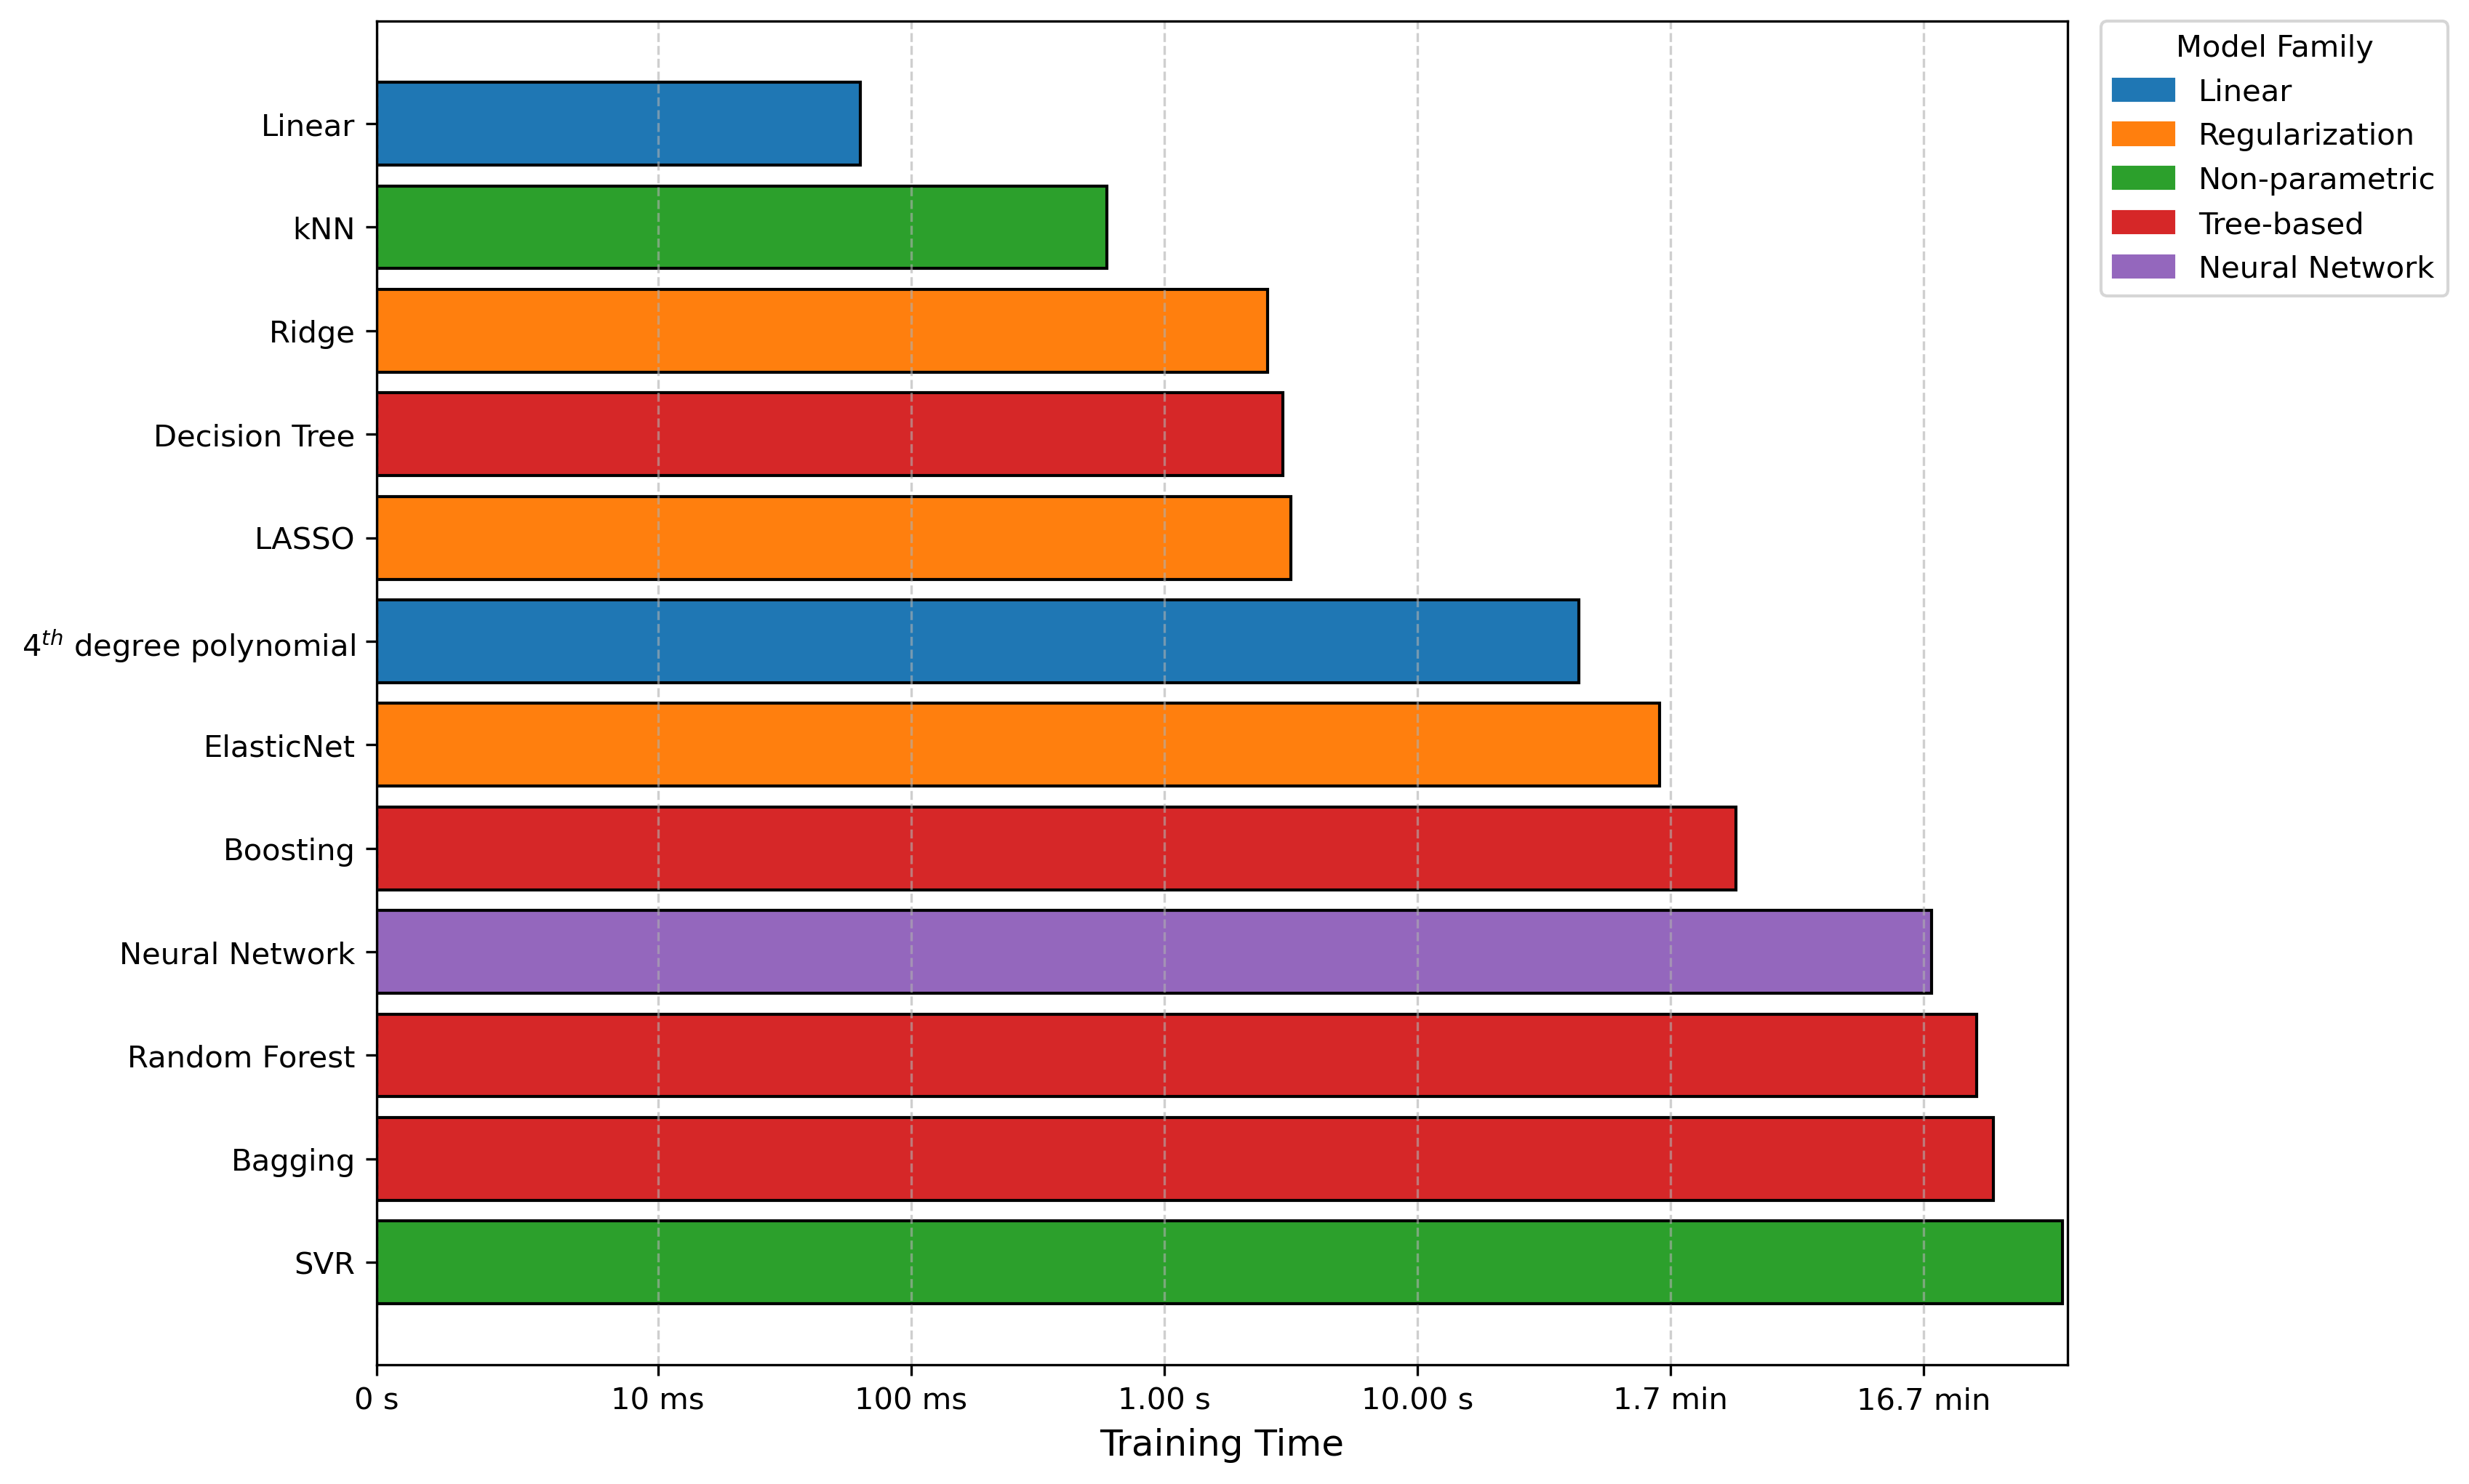

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

data_metrics = {
    'Model': ['SVR','Neural Network','kNN','Bagging','Boosting','Random Forest','Decision Tree', '$4^{th}$ degree polynomial','ElasticNet','Ridge','LASSO','Linear'],
    'MSE': list(np.array(Metrics_df["MSE"])),
    'MAE': list(np.array(Metrics_df["MAE"])),
    'R²':  list(np.array(Metrics_df["R2"])),
    'MSPE' : list(np.array(Metrics_df["MSPE"])),
    'MAPE' : list(np.array(Metrics_df["MAPE"])),
    'Training Time': list(np.array(Time_df["Fitting time"])),
    'Inference Time':  list(np.array(Time_df["Prediction time per point"])),
}


# --- Data Preparation ---

df_metrics = pd.DataFrame(data_metrics).set_index('Model')

# Define model families for consistent coloring
families = {
    'Linear': 'Linear', '$4^{th}$ degree polynomial': 'Linear',
    'LASSO': 'Regularization', 'Ridge': 'Regularization', 'ElasticNet': 'Regularization',
    'kNN': 'Non-parametric', 'SVR': 'Non-parametric',
    'Decision Tree': 'Tree-based', 'Random Forest': 'Tree-based',
    'Bagging': 'Tree-based', 'Boosting': 'Tree-based',
    'Neural Network': 'Neural Network'
}

# Color palette by family
family_palette = {
    'Linear': '#1f77b4', 'Regularization': '#ff7f0e',
    'Non-parametric': '#2ca02c', 'Tree-based': '#d62728',
    'Neural Network': '#9467bd'
}

# --- Plotting Configuration ---

metrics_to_plot = {
    'MSE': {'lower_is_better': True, 'scale': 'linear'},
    'MAE': {'lower_is_better': True, 'scale': 'linear'},
    'R²': {'lower_is_better': False, 'scale': 'linear'},
    'MAPE': {'lower_is_better': True, 'scale': 'symlog', 'linthresh': 1e-2},
    'MSPE': {'lower_is_better': True, 'scale':  'symlog', 'linthresh': 1e-6},
    'Inference Time': {'lower_is_better': True, 'scale': 'symlog', 'linthresh': 1e-6},
    'Training Time': {'lower_is_better': True, 'scale': 'symlog', 'linthresh': 1e-2}
}

# --- Helper Function for Time Formatting ---
def time_formatter(x, pos):
    if x == 0:
        return '0 s'
    if abs(x) < 1e-6:
        return f'{x * 1e9:.0f} ns'
    if abs(x) < 1e-3:
        return f'{x * 1e6:.0f} µs'
    if abs(x) < 1:
        return f'{x * 1e3:.0f} ms'
    if abs(x) < 60:
        return f'{x:.2f} s'
    return f'{x / 60:.1f} min'

# --- Plotting Loop ---

for metric, config in metrics_to_plot.items():

    # Sort models by the performance
    sorted_models = df_metrics.sort_values(by=metric, ascending=config['lower_is_better']).index

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

    # --- Manual Bar Plotting for Full Control ---
    y_pos = np.arange(len(sorted_models))
    bar_height = 0.8

    for i, model_name in enumerate(sorted_models):
        family = families[model_name]
        color = family_palette[family]

        val = df_metrics.loc[model_name, metric]

        ax.barh(y_pos[i], val, height=bar_height,
                align='center', color=color, edgecolor='black')

    # --- Set Y-axis labels and ticks ---
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_models, fontsize=10)
    ax.invert_yaxis()  # Puts the best model on top

    # --- Apply Appropriate X-axis Scale (FIXED) ---
    if config['scale'] == 'symlog':
        ax.set_xscale(config['scale'], linthresh=config.get('linthresh'))
    else:
        ax.set_xscale(config['scale'])

    # --- Formatting and Labels ---
    xlabel = metric
    if 'Time' in metric:
        ax.xaxis.set_major_formatter(FuncFormatter(time_formatter))

    ax.set_xlabel(xlabel, fontsize=12)
    ax.tick_params(axis='x', labelsize=10)

    # --- Create Custom Legend for family colors ---
    family_legend_patches = [mpatches.Patch(color=color, label=family) for family, color in family_palette.items()]
    ax.legend(handles=family_legend_patches, title='Model Family',
              loc='upper left', bbox_to_anchor=(1.02, 1),
              borderaxespad=0., fontsize=10)

    # Add a grid for easier value reading
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # ax.set_title(f'Model Performance (Original Features): {metric}', fontsize=14, pad=15)

    # Use bbox_inches='tight' to ensure external legends are included in the saved figure
    plt.savefig(f"original_{metric.replace('²', '2')}.png", dpi=300, bbox_inches='tight')
    plt.show()
